In [720]:
import xarray as xr
import pandas as pd
import numpy as np

In [721]:
ds = xr.open_dataset('pnwrain.50km.daily.4994.nc', decode_times=False)

In [722]:
ds.info()

xarray.Dataset {
dimensions:
	lat = 17 ;
	lon = 16 ;
	time = 16801 ;

variables:
	float32 lat(lat) ;
		lat:title = Latitude ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:title = Longitude ;
		lon:units = degrees_east ;
	float64 time(time) ;
		time:title = Time ;
		time:units = days    since 1949- 1- 1  0: 0: 0 ;
	float32 data(time, lat, lon) ;
		data:long_name = mm/day ;
		data:units = mm/day ;

// global attributes:
}

### Manually decode time variable since it fails when opening dataset

the extra spaces of the attribute unit string of the time variable is causing this issue

In [723]:
print(ds['time'])

<xarray.DataArray 'time' (time: 16801)>
array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 1.6798e+04, 1.6799e+04,
       1.6800e+04])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 1.68e+04 1.68e+04 1.68e+04
Attributes:
    title:    Time
    units:    days    since 1949- 1- 1  0: 0: 0


Extract time values and units

In [724]:
time_values = ds.time.values

# Empty spaces in the unit string will cause issue on num2date function
# time_units = ds.time.attrs['units']

In [725]:
# Manually Parse the units string instead
reference_date = '1949-01-01 00:00:00'
time_units = 'days since ' + reference_date

Decode time values (assume Gregorian calendar )

In [726]:
from cftime import num2date

time_index = num2date(time_values, units=time_units)

In [727]:
# Create a Dataset with the time_index variable
time_ds = xr.Dataset({'time_index': ('time', time_index)})

# Merge the time_ds Dataset with the original dataset
ds = xr.merge([ds, time_ds], combine_attrs='override')

In [728]:
# Set 'time_index' as the new coordinate for 'time'
ds = ds.assign_coords({'time': ds['time_index']})

In [729]:
ds = ds.drop_vars('time_index')

In [730]:
ds['time'].attrs = {
    'title': 'Time',
    'units': 'days since 1949-01-01 00:00:00'
}

In [731]:
# convert cftime.DatetimeGregorian to datetime
datetimeindex = ds.indexes['time'].to_datetimeindex()
ds['time'] = datetimeindex

In [732]:
# Set time as the index
ds = ds.set_index(time='time')

In [733]:
ds.info()

xarray.Dataset {
dimensions:
	lat = 17 ;
	lon = 16 ;
	time = 16801 ;

variables:
	float32 lat(lat) ;
		lat:title = Latitude ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:title = Longitude ;
		lon:units = degrees_east ;
	datetime64[ns] time(time) ;
	float32 data(time, lat, lon) ;
		data:long_name = mm/day ;
		data:units = mm/day ;

// global attributes:
}

Check gap in dates

In [14]:
# Calculate the differences between consecutive time points
time_diff = ds['time'].diff(dim='time')

# Convert time differences to a more interpretable format, like days
time_diff_in_days = time_diff / pd.to_timedelta(1, unit='D')

In [15]:
# more than 1 day is consider a gap
large_gap_threshold = 1  # days

# Find where the gaps exceed this threshold
large_gaps = time_diff_in_days.where(time_diff_in_days > large_gap_threshold, drop=True)

In [16]:
# Check if there are gaps
if len(large_gaps) > 0:
    print("Large gaps found at the following times:")
    print(large_gaps)
else:
    print("No large gaps found in the dates.")

No large gaps found in the dates.


Flatten data

In [734]:
# Stack 'lat' and 'lon' to create a single 'spatial' dimension
data_flat = ds['data'].stack(all_points=('time', 'lat', 'lon'))

In [735]:
data_flat

<xarray.DataArray 'data' (all_points: 4569872)>
array([nan, nan, nan, ..., 7.4, nan, nan], dtype=float32)
Coordinates:
  * all_points  (all_points) object MultiIndex
  * time        (all_points) datetime64[ns] 1949-01-01 1949-01-01 ... 1994-12-31
  * lat         (all_points) float32 49.76 49.76 49.76 ... 42.14 42.14 42.14
  * lon         (all_points) float32 -125.6 -125.0 -124.4 ... -116.9 -116.2
Attributes:
    long_name:  mm/day
    units:      mm/day

In [736]:
df_flat = data_flat.to_dataframe(name='precipitation').reset_index(drop=True)

In [737]:
print(df_flat.columns)

Index(['time', 'lat', 'lon', 'precipitation'], dtype='object')


In [738]:
df_flat.head(10)

time        lat      lon  precipitation
0 1949-01-01  49.760941 -125.625            NaN
1 1949-01-01  49.760941 -125.000            NaN
2 1949-01-01  49.760941 -124.375            NaN
3 1949-01-01  49.760941 -123.750            NaN
4 1949-01-01  49.760941 -123.125            NaN
5 1949-01-01  49.760941 -122.500            NaN
6 1949-01-01  49.760941 -121.875            NaN
7 1949-01-01  49.760941 -121.250            NaN
8 1949-01-01  49.760941 -120.625            NaN
9 1949-01-01  49.760941 -120.000            NaN

## Handle missing value in data

In [23]:
df_flat['precipitation']

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
             ...    
4569867    23.900000
4569868    25.800001
4569869     7.400000
4569870          NaN
4569871          NaN
Name: precipitation, Length: 4569872, dtype: float32

In [24]:
df_flat['precipitation'].isnull().sum()

1439154

In [25]:
precipitation_zero = df_flat[df_flat['precipitation'] == 0]
print(precipitation_zero)

              time        lat      lon  precipitation
42      1949-01-01  48.808578 -119.375            0.0
43      1949-01-01  48.808578 -118.750            0.0
58      1949-01-01  48.332401 -119.375            0.0
59      1949-01-01  48.332401 -118.750            0.0
73      1949-01-01  47.856220 -120.000            0.0
...            ...        ...      ...            ...
4569860 1994-12-31  42.142059 -123.125            0.0
4569861 1994-12-31  42.142059 -122.500            0.0
4569864 1994-12-31  42.142059 -120.625            0.0
4569865 1994-12-31  42.142059 -120.000            0.0
4569866 1994-12-31  42.142059 -119.375            0.0

[1800839 rows x 4 columns]


Filling with 0

In [31]:
# df_flat['precipitation'].fillna(0, inplace=True)

Resample

In [26]:
# df_flatten = df_flat.copy()

In [33]:
# # Convert 'time' column to datetime format if it's not already
# df_flatten['time'] = pd.to_datetime(df_flatten['time'])

# # Set 'time' column as the index
# df_flatten.set_index(['time'], inplace=True)

In [34]:
# # Resample to monthly frequency and calculate the mean precipitation
# monthly_mean_precipitation = df_flatten['precipitation'].resample('M').mean()

# # Resample to weekly frequency and calculate the sum precipitation
# weekly_sum_precipitation = df_flatten['precipitation'].resample('W').sum()

Spatial Interpolation

In [739]:
df_flatten = df_flat.copy()

IDW

In [36]:
from scipy.interpolate import Rbf

# IDW interpolation
def idw_interpolation(df, time, lat, lon):
    # Filter data for the specific time point
    df_time = df[df['time'] == time]
    
    # Filter out NaN values and create arrays for lat, lon, and precipitation
    lat_known = df_time['lat'][~df_time['precipitation'].isnull()].values
    lon_known = df_time['lon'][~df_time['precipitation'].isnull()].values
    prec_known = df_time['precipitation'][~df_time['precipitation'].isnull()].values
    
    # Perform IDW interpolation
    rbfi = Rbf(lon_known, lat_known, prec_known, function='linear')
    interp_prec = rbfi(lon, lat)
    
    return interp_prec

In [38]:
# # Find indices of NaN values in the 'precipitation' column
# nan_indices = df_flatten[df_flatten['precipitation'].isnull()].index

# # Fill NaN values using IDW interpolation
# for idx in nan_indices:
#     time = df_flatten.loc[idx, 'time']
#     lat = df_flatten.loc[idx, 'lat']
#     lon = df_flatten.loc[idx, 'lon']
#     interpolated_prec = idw_interpolation(df_flatten, time, lat, lon)
#     df_flatten.loc[idx, 'precipitation'] = interpolated_prec


Kriging

In [53]:
from pykrige.ok import OrdinaryKriging

def kriging_interpolation(df, time, lat, lon):
    # Filter data to include only non-NaN values
    df_filtered = df.dropna(subset=['precipitation'])
    
    # Extract coordinates and values
    X = df_filtered[['lon', 'lat', 'time']].values
    values = df_filtered['precipitation'].values
    
    # Perform kriging interpolation
    OK = OrdinaryKriging(
        X[:, 0], X[:, 1], values,
        variogram_model='linear', # Specify the variogram model here
        verbose=False, enable_plotting=False
    )
    interpolated_prec, _ = OK.execute('points', lon, lat, time)
    
    # Update the 'precipitation' value in the DataFrame
    df.loc[df['time'] == time, 'precipitation'] = interpolated_prec
    
    return df


KNN Imputation

In [ ]:
from scipy.spatial import cKDTree

# Convert 'time' column to Unix timestamps (seconds since the Unix epoch)
df_flatten['time_unix'] = df_flatten['time'].astype(np.int64) // 10**9

# Find indices of NaN values in the 'precipitation' column
nan_indices = df_flatten[df_flatten['precipitation'].isnull()].index

# Filter out rows with NaN values
df_filtered = df_flatten.dropna(subset=['lon', 'lat', 'time_unix', 'precipitation'])

# KDTree for nearest neighbor search
tree = cKDTree(df_filtered[['lon', 'lat', 'time_unix']].values)

# Batch size
batch_size = 1000

# Process NaN values in batches
for i in range(0, len(nan_indices), batch_size):
    batch_indices = nan_indices[i:i+batch_size]
    for idx in batch_indices:
        time = df_flatten.loc[idx, 'time_unix']
        lat = df_flatten.loc[idx, 'lat']
        lon = df_flatten.loc[idx, 'lon']
    
        # Find the nearest neighbor
        _, ind = tree.query([lon, lat, time], k=1)
        if isinstance(ind, int):  # Convert to list if it's an integer
            ind = [ind]
        neighbor_idx = df_filtered.iloc[ind[0]].name
    
        # Interpolate the missing value using the neighbor's value
        df_flatten.loc[idx, 'precipitation'] = df_filtered.loc[neighbor_idx, 'precipitation']

    # Print progress
    batches_completed = (i + batch_size) // batch_size
    batches_left = (len(nan_indices) + batch_size - 1) // batch_size - batches_completed
    print(f"Processed {batches_completed}/{len(nan_indices) // batch_size} batches. {batches_left} batches left.")

print("Remaining NaN count:", df_flatten['precipitation'].isnull().sum())

In [63]:
df_flatten['precipitation'].isnull().sum()

0

In [62]:
if df_flatten['precipitation'].isnull().sum() == 0:
    print("All NaN values filled successfully.")
else:
    print("Some NaN values remain after interpolation.")

All NaN values filled successfully.


In [259]:
# Check for any duplicate rows based on all columns
duplicate_rows = df_flat.duplicated()
print("Number of duplicate rows:", duplicate_rows.sum())

# To see the actual duplicate rows
if duplicate_rows.sum() > 0:
    print(df_flat[duplicate_rows])

Number of duplicate rows: 0


In [65]:
df_flatten.to_csv('nn_filled_precipitation.csv')

In [741]:
df_flatten = pd.read_csv('../nn_filled_precipitation.csv')

Check duplicated rows

In [742]:
df_flatten = df_flatten.drop(['Unnamed: 0', 'time_unix'], axis=1)

df_flat = df_flatten.copy()

In [35]:
df_flat

time       lat      lon  precipitation
0        1949-01-01  49.76094 -125.625      12.451237
1        1949-01-01  49.76094 -125.000      10.839300
2        1949-01-01  49.76094 -124.375       9.390542
3        1949-01-01  49.76094 -123.750       7.837927
4        1949-01-01  49.76094 -123.125       6.168290
...             ...       ...      ...            ...
4569867  1994-12-31  42.14206 -118.750      23.900000
4569868  1994-12-31  42.14206 -118.125      25.800001
4569869  1994-12-31  42.14206 -117.500       7.400000
4569870  1994-12-31  42.14206 -116.875       0.000000
4569871  1994-12-31  42.14206 -116.250       0.000000

[4569872 rows x 4 columns]

Get ranges

In [36]:
min_date = df_flat['time'].min()
max_date = df_flat['time'].max()

print(f"The dataset covers from {min_date} to {max_date}.")

The dataset covers from 1949-01-01 to 1994-12-31.


In [37]:
# latitude
min_lat = df_flat['lat'].min()
max_lat = df_flat['lat'].max()

# longitude
min_lon = df_flat['lon'].min()
max_lon = df_flat['lon'].max()

print(f"The latitude range of the dataset is from {min_lat} to {max_lat}.")
print(f"The longitude range of the dataset is from {min_lon} to {max_lon}.")

The latitude range of the dataset is from 42.14206 to 49.76094.
The longitude range of the dataset is from -125.625 to -116.25.


## Features

In [438]:
def derive_temporal_features(df):
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['week_of_year'] = df['time'].dt.isocalendar().week
    df['day_of_week'] = df['time'].dt.dayofweek
    df['day_of_year'] = df['time'].dt.dayofyear
    df['quarter'] = df['time'].dt.quarter

    df['season'] = df['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Fall')
    df['season'] = df['season'].astype('category')

    # Cyclical features
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    return df

In [85]:
df_flat['time'] = pd.to_datetime(df_flat['time'])

In [86]:
df_flat = derive_temporal_features(df_flat)

In [87]:
df_flat

time       lat      lon  precipitation  year  month  day  \
0       1949-01-01  49.76094 -125.625      12.451237  1949      1    1   
1       1949-01-01  49.76094 -125.000      10.839300  1949      1    1   
2       1949-01-01  49.76094 -124.375       9.390542  1949      1    1   
3       1949-01-01  49.76094 -123.750       7.837927  1949      1    1   
4       1949-01-01  49.76094 -123.125       6.168290  1949      1    1   
...            ...       ...      ...            ...   ...    ...  ...   
4569867 1994-12-31  42.14206 -118.750      23.900000  1994     12   31   
4569868 1994-12-31  42.14206 -118.125      25.800001  1994     12   31   
4569869 1994-12-31  42.14206 -117.500       7.400000  1994     12   31   
4569870 1994-12-31  42.14206 -116.875       0.000000  1994     12   31   
4569871 1994-12-31  42.14206 -116.250       0.000000  1994     12   31   

         week_of_year  day_of_week  day_of_year  quarter  month_cos  \
0                  53            5            1        1   0.866025   
1                  53            5            1        1   0.866025   
2                  53            5            1        1   0.866025   
3                  53            5            1        1   0.866025   
4                  53            5            1        1   0.866025   
...               ...          ...          ...      ...        ...   
4569867            52            5          365        4   1.000000   
4569868            52            5          365        4   1.000000   
4569869            52            5          365        4   1.000000   
4569870            52            5          365        4   1.000000   
4569871            52            5          365        4   1.000000   

         day_of_week_cos  location_cluster  
0              -0.222521                 0  
1              -0.222521                 0  
2              -0.222521                 0  
3              -0.222521                 0  
4              -0.222521                 0  
...                  ...               ...  
4569867        -0.222521                 1  
4569868        -0.222521                 1  
4569869        -0.222521                 1  
4569870        -0.222521                 1  
4569871        -0.222521                 1  

[4569872 rows x 14 columns]

Check Non zero

In [37]:
len(df_flat)

4569872

In [38]:
non_zero_precipitation_count = df_flat[df_flat['precipitation'].notna() & (df_flat['precipitation'] != 0)].shape[0]

In [39]:
non_zero_precipitation_count

2120818

Extract non zero df

In [40]:
df_non_zero = df_flat[df_flat['precipitation'] > 0.0]

# Visualization

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature

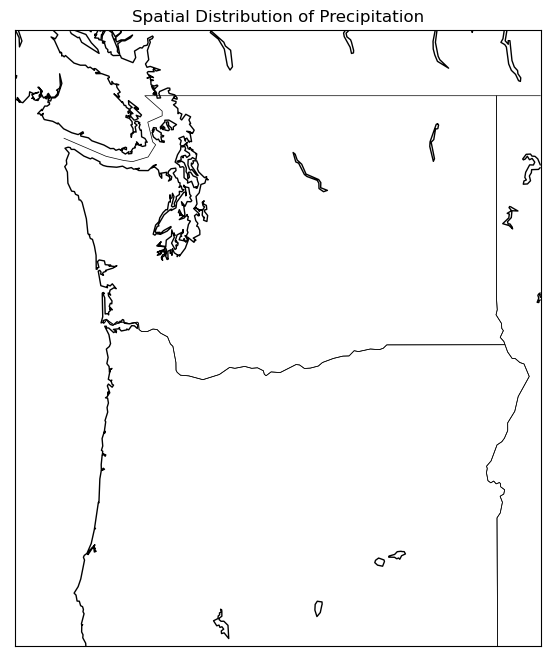

In [42]:
# Define the boundaries of the map and resolution
fig, ax = plt.subplots(figsize=(10, 8))
m = Basemap(projection='merc', llcrnrlat=df_flat['lat'].min(), urcrnrlat=df_flat['lat'].max(),
            llcrnrlon=df_flat['lon'].min(), urcrnrlon=df_flat['lon'].max(), resolution='i')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Convert lat and lon to map projection coordinates
lons, lats = m(df_flat['lon'].values, df_flat['lat'].values)

plt.title('Spatial Distribution of Precipitation')
plt.show()

### Functions

In [43]:
def filter_data(df, min_lon, max_lon, min_lat, max_lat):
    """
    Filters the DataFrame for non-zero precipitation and within the specified bounds.

    Parameters:
    - df: pandas DataFrame containing the dataset
    - min_lon, max_lon: Minimum and maximum longitude of the bounding box
    - min_lat, max_lat: Minimum and maximum latitude of the bounding box

    Returns:
    - A pandas DataFrame filtered according to the specified parameters
    """
    filtered_df = df[(df['precipitation'] > 0) &
              (df['lon'] >= min_lon) & (df['lon'] <= max_lon) &
              (df['lat'] >= min_lat) & (df['lat'] <= max_lat)]

    return filtered_df.copy()

In [44]:
def filter_data_with_zero(df, min_lon, max_lon, min_lat, max_lat):
    """
    Filters the DataFrame for non-zero precipitation and within the specified bounds.

    Parameters:
    - df: pandas DataFrame containing the dataset
    - min_lon, max_lon: Minimum and maximum longitude of the bounding box
    - min_lat, max_lat: Minimum and maximum latitude of the bounding box

    Returns:
    - A pandas DataFrame filtered according to the specified parameters
    """
    filtered_df = df[
              (df['lon'] >= min_lon) & (df['lon'] <= max_lon) &
              (df['lat'] >= min_lat) & (df['lat'] <= max_lat)]

    return filtered_df.copy()

In [45]:
def filter_data_within_range(df, central_lat, central_lon, lat_range, lon_range):
    """
    Selects data within a specified range around a central latitude and longitude.

    Parameters:
    - df: pandas DataFrame to filter.
    - central_lat: Central latitude of the target area.
    - central_lon: Central longitude of the target area.
    - lat_range: Latitude range (extent) around the central latitude.
    - lon_range: Longitude range (extent) around the central longitude.

    Returns:
    - A pandas DataFrame containing only the data within the specified range.
    """
    min_lat = central_lat - lat_range / 2
    max_lat = central_lat + lat_range / 2
    min_lon = central_lon - lon_range / 2
    max_lon = central_lon + lon_range / 2

    filtered_df = df[(df['lat'] >= min_lat) & (df['lat'] <= max_lat) &
                     (df['lon'] >= min_lon) & (df['lon'] <= max_lon)]
    return filtered_df

In [46]:
central_lat = 47.0
central_lon = -122.0
lat_range = 3.0
lon_range = 3.0

selected_data = filter_data_within_range(df_non_zero, central_lat, central_lon, lat_range, lon_range)

In [47]:
print(f"Data points longitude range: {selected_data['lon'].min()} to {selected_data['lon'].max()}")
print(f"Data points latitude range: {selected_data['lat'].min()} to {selected_data['lat'].max()}")

Data points longitude range: -123.125 to -120.625
Data points latitude range: 45.9515 to 48.3324


In [48]:
def calculate_average_precipitation(df):
    """
    Groups the DataFrame by latitude and longitude and calculates the mean precipitation.

    Parameters:
    - df: pandas DataFrame with the filtered dataset

    Returns:
    - A pandas DataFrame with the mean precipitation for each group
    """
    return df.groupby(['lat', 'lon'])['precipitation'].mean().reset_index()

In [50]:
def plot_precipitation_heatmap(grouped_data, title, extent=None):
    """
    Creates a geospatial plot of the average precipitation data.

    Parameters:
    - grouped_data: pandas DataFrame with average precipitation data
    - title: Title for the plot
    - extent: Optional. A tuple of (min_lon, max_lon, min_lat, max_lat) for the map extent.
              If None, the extent is determined automatically.
    """
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    size_factor = 20
    point_sizes = grouped_data['precipitation'] * size_factor

    if not grouped_data.empty:
        sc = ax.scatter(grouped_data['lon'], grouped_data['lat'], c=grouped_data['precipitation'],
                        cmap='cool', s=point_sizes, edgecolor='black', linewidth=1,
                        transform=ccrs.PlateCarree())
        plt.colorbar(sc, label='Average Precipitation (mm/day)')
    else:
        print("No data available to plot.")

    print(f"Data points longitude range: {grouped_data['lon'].min()} to {grouped_data['lon'].max()}")
    print(f"Data points latitude range: {grouped_data['lat'].min()} to {grouped_data['lat'].max()}")

    if extent:
        print(f"Setting extent to: {extent}")
        # Set the extent using the set_extent method
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        # ax.set_xlim(extent[0], extent[1])
        # ax.set_ylim(extent[2], extent[3])
    else:
        print("Auto-adjusting extent based on data.")

    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    plt.title(title)
    plt.show()

Data points longitude range: -125.625 to -116.25
Data points latitude range: 42.142059326171875 to 49.76094055175781
Auto-adjusting extent based on data.


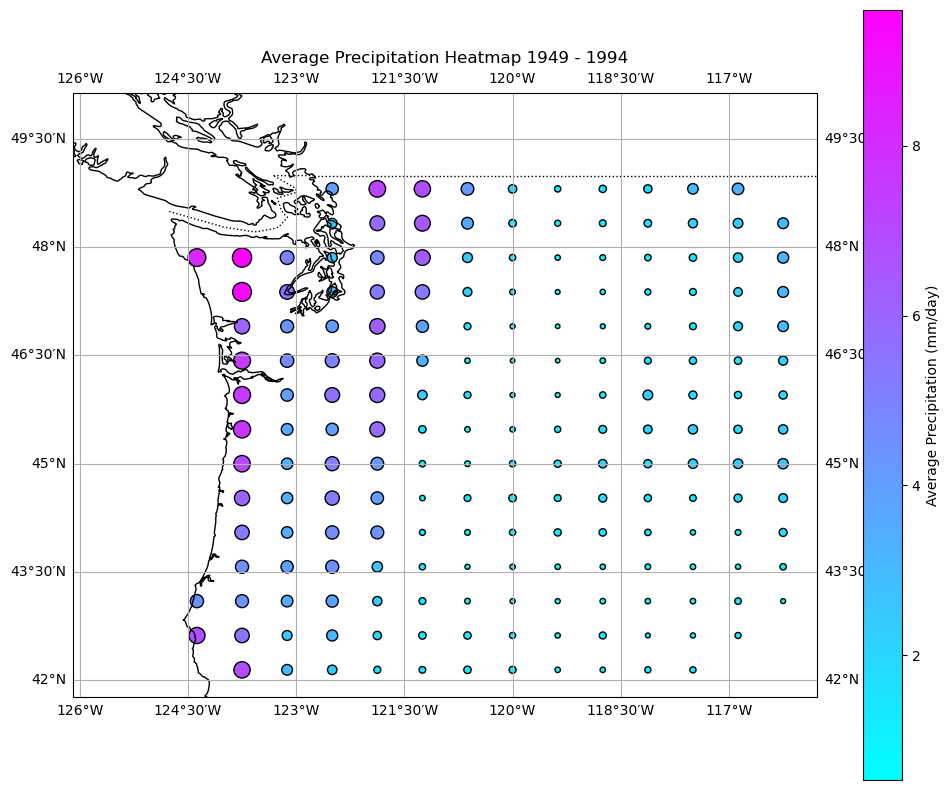

In [740]:
# Group by latitude and longitude to calculate the mean precipitation
grouped_data = calculate_average_precipitation(df_flat)

plot_title = 'Average Precipitation Heatmap 1949 - 1994'
plot_precipitation_heatmap(grouped_data, plot_title)

In [52]:
# The bounds of the area to zoom into
min_lon, max_lon = -123, -121
min_lat, max_lat = 46, 48

In [53]:
# Filter data within the specified area.
filtered_df = filter_data(df_non_zero, min_lon, max_lon, min_lat, max_lat)

# Calculate the average precipitation
average_precip = calculate_average_precipitation(filtered_df)

Data points longitude range: -122.5 to -121.25
Data points latitude range: 46.42768 to 47.85622
Setting extent to: (-123, -121, 46, 48)


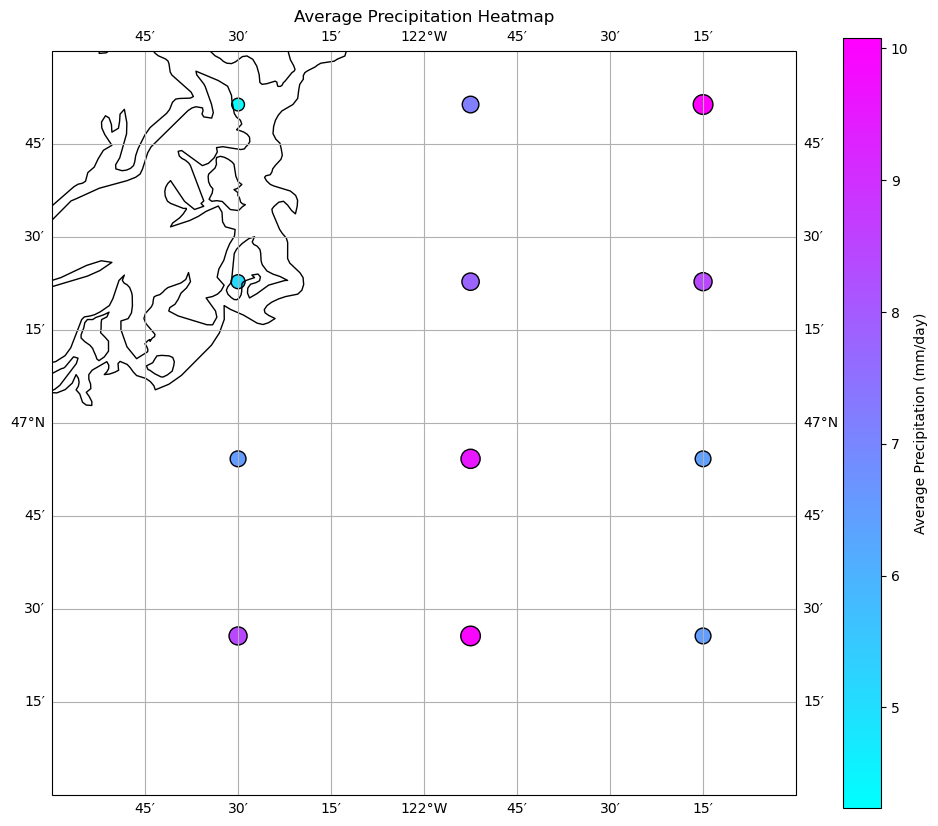

In [54]:
# Plot the results with a specified extent
plot_title = 'Average Precipitation Heatmap'
plot_precipitation_heatmap(average_precip, plot_title, extent=(min_lon, max_lon, min_lat, max_lat))

In [55]:
# df_filtered = df_non_zero

# # Group by latitude and longitude to calculate the mean precipitation
# grouped = df_filtered.groupby(['lat', 'lon'])['precipitation'].mean().reset_index()

# # Create a figure with an projection
# fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')

# if not grouped.empty:
#     # Scatter plot for average precipitation
#     sc = ax.scatter(grouped['lon'], grouped['lat'], c=grouped['precipitation'],
#                     cmap='cool', s=150, edgecolor='black', linewidth=1,
#                     transform=ccrs.PlateCarree())  # Ensure the transform is correct
#     plt.colorbar(sc, label='Average Precipitation (mm/day)')
# else:
#     print("No non-zero precipitation data available to plot.")

# # Set the geographic extent to encompass all points or focus on a particular region
# # ax.set_extent([min longitude, max longitude, min latitude, max latitude], crs=ccrs.PlateCarree())
# ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# plt.title('Average Precipitation Heatmap 1949 - 1994')
# plt.show()

Plot specific area

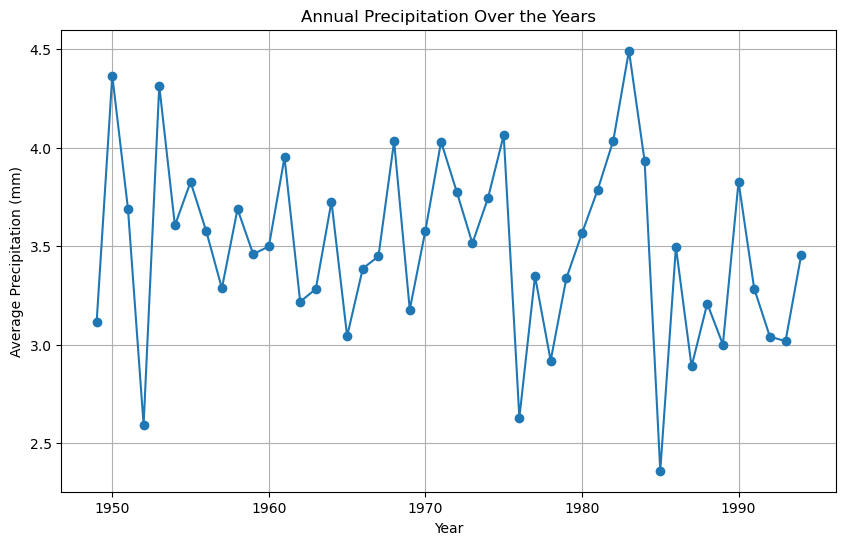

In [56]:
average_precipitation_df = df_flat.groupby('year')['precipitation'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(average_precipitation_df['year'], average_precipitation_df['precipitation'], marker='o', linestyle='-')
plt.title('Annual Precipitation Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm)')
plt.grid(True)
plt.show()

In [57]:
central_lat = 46.0
central_lon = -123.0
lat_range = 1.0
lon_range = 1.0

selected_data = filter_data_within_range(df_flat, central_lat, central_lon, lat_range, lon_range)

In [58]:
selected_data

time       lat      lon  precipitation  year  month  day  \
116     1949-01-01  46.42768 -123.125       4.600000  1949      1    1   
117     1949-01-01  46.42768 -122.500      20.200001  1949      1    1   
132     1949-01-01  45.95150 -123.125      20.600000  1949      1    1   
133     1949-01-01  45.95150 -122.500      18.200001  1949      1    1   
388     1949-01-02  46.42768 -123.125       3.300000  1949      1    2   
...            ...       ...      ...            ...   ...    ...  ...   
4569461 1994-12-30  45.95150 -122.500       0.000000  1994     12   30   
4569716 1994-12-31  46.42768 -123.125       0.000000  1994     12   31   
4569717 1994-12-31  46.42768 -122.500       0.000000  1994     12   31   
4569732 1994-12-31  45.95150 -123.125       0.000000  1994     12   31   
4569733 1994-12-31  45.95150 -122.500       0.000000  1994     12   31   

         week_of_year  day_of_week  day_of_year  quarter  month_cos  \
116                53            5            1        1   0.866025   
117                53            5            1        1   0.866025   
132                53            5            1        1   0.866025   
133                53            5            1        1   0.866025   
388                53            6            2        1   0.866025   
...               ...          ...          ...      ...        ...   
4569461            52            4          364        4   1.000000   
4569716            52            5          365        4   1.000000   
4569717            52            5          365        4   1.000000   
4569732            52            5          365        4   1.000000   
4569733            52            5          365        4   1.000000   

         day_of_week_cos  
116            -0.222521  
117            -0.222521  
132            -0.222521  
133            -0.222521  
388             0.623490  
...                  ...  
4569461        -0.900969  
4569716        -0.222521  
4569717        -0.222521  
4569732        -0.222521  
4569733        -0.222521  

[67204 rows x 13 columns]

In [59]:
# Group by year and calculate average precipitation
average_precipitation_per_year = selected_data.groupby('year')['precipitation'].mean().reset_index()

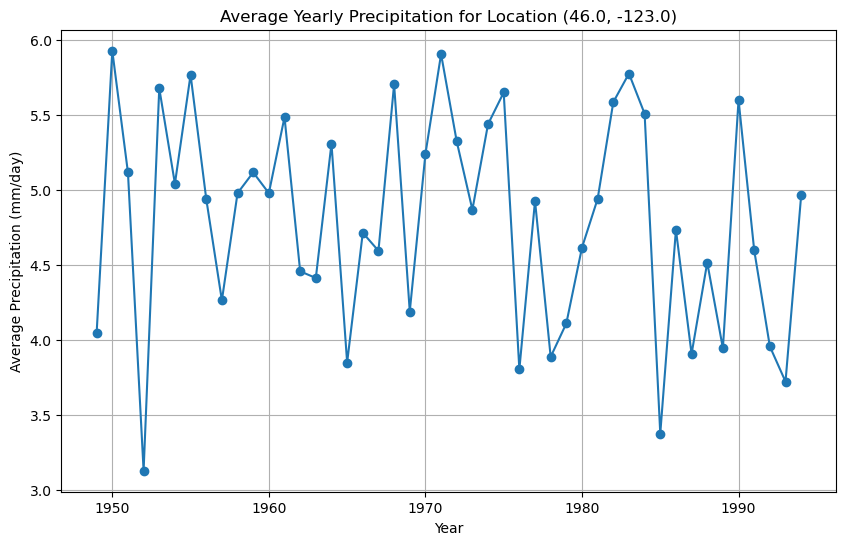

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(average_precipitation_per_year['year'], average_precipitation_per_year['precipitation'], marker='o')
plt.title(f"Average Yearly Precipitation for Location ({central_lat}, {central_lon})")
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm/day)')
plt.grid(True)
plt.show()

 zoom into the specific geographic zone

In [61]:
# Define the bounds of the area to zoom into
min_lon, max_lon = -117, -0
min_lat, max_lat = 43, 44

df_to_fliter = df_flat
# Filter the data for the specified zone
zone_data = df_to_fliter[(df_to_fliter['lon'] >= min_lon) & (df_to_fliter['lon'] <= max_lon) &
               (df_to_fliter['lat'] >= min_lat) & (df_to_fliter['lat'] <= max_lat)]

In [62]:
annual_precip = zone_data.groupby('year')['precipitation'].mean().reset_index()

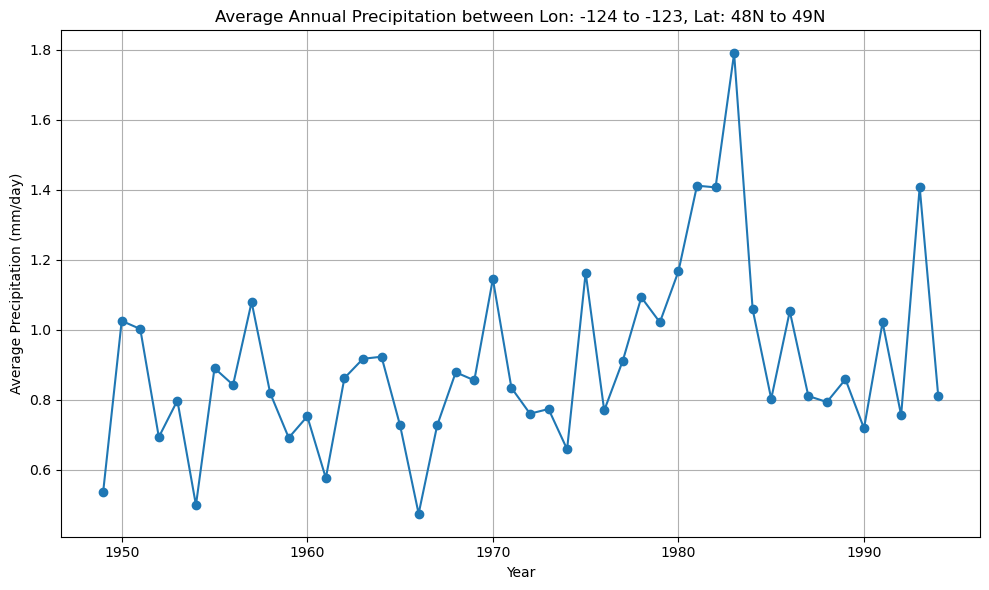

In [63]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(annual_precip['year'], annual_precip['precipitation'], marker='o')
plt.title('Average Annual Precipitation between Lon: -124 to -123, Lat: 48N to 49N')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm/day)')
plt.grid(True)
plt.tight_layout()
plt.show()

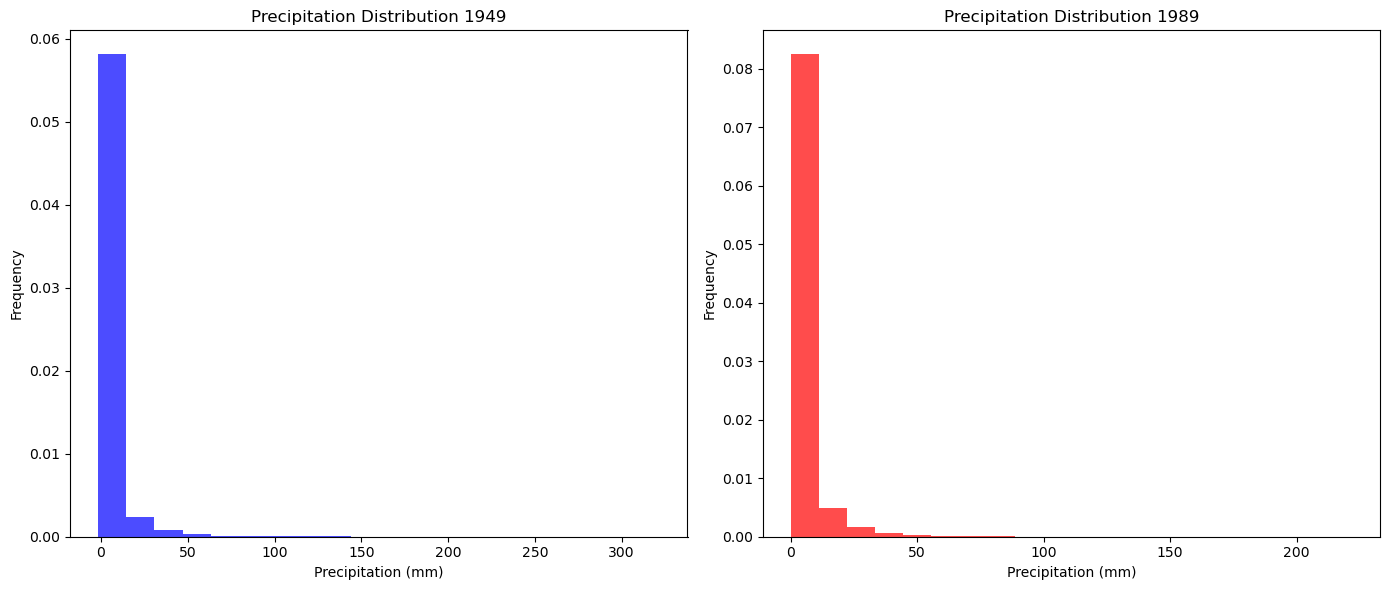

In [64]:
data_year1 = df_flat[df_flat['year'] == 1949]['precipitation']
data_year2 = df_flat[df_flat['year'] == 1989]['precipitation']

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].hist(data_year1, bins=20, density=True, color='blue', alpha=0.7)
ax[0].set_title('Precipitation Distribution 1949')
ax[0].set_xlabel('Precipitation (mm)')
ax[0].set_ylabel('Frequency')

ax[1].hist(data_year2, bins=20, density=True, color='red', alpha=0.7)
ax[1].set_title('Precipitation Distribution 1989')
ax[1].set_xlabel('Precipitation (mm)')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### K Means Clustering (Lat, Lon)

In [68]:
from sklearn.cluster import KMeans

In [70]:
import os
os.environ["OMP_NUM_THREADS"] = "2"
# os.environ["OPENBLAS_NUM_THREADS"] = "4" # export OPENBLAS_NUM_THREADS=4 
# os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
# os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4
# os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

In [ ]:
# Calculate the sum of squared distances (SSD) for a range of number of clusters
ssd = []
coords = df_flat[['lat', 'lon']].drop_duplicates().values
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init='auto' ,random_state=42)
    kmeans.fit(coords)
    ssd.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, ssd, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [72]:
coords = df_flat[['lat', 'lon']].drop_duplicates().values
unique_coords_df = pd.DataFrame(coords, columns=['lat', 'lon'])

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, n_init='auto', random_state=42)

cluster_labels = kmeans.fit_predict(unique_coords_df)

unique_coords_df['location_cluster'] = cluster_labels

df_flat = df_flat.merge(unique_coords_df, on=['lat', 'lon'], how='left')

c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [80]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import MultiPoint

def plot_precipitation_heatmap_with_clusters(df_clusters, title, extent=None):
    """
    Creates a geospatial plot of the average precipitation data with extended cluster boundaries.

    Parameters:
    - df_clusters: pandas DataFrame with time-indexed precipitation data for each location cluster
    - title: Title for the plot
    - extent: Optional. A tuple of (min_lon, max_lon, min_lat, max_lat) for the map extent.
              If None, the extent is determined automatically.
    """
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Group by 'location_cluster', 'lat', and 'lon', and calculate mean precipitation
    grouped_data = df_clusters.groupby(['location_cluster', 'lat', 'lon'])['precipitation'].mean().reset_index()

    size_factor = 20
    point_sizes = grouped_data['precipitation'] * size_factor

    if not grouped_data.empty:
        sc = ax.scatter(grouped_data['lon'], grouped_data['lat'], c=grouped_data['precipitation'],
                        cmap='cool', s=point_sizes, edgecolor='black', linewidth=1,
                        transform=ccrs.PlateCarree())
        plt.colorbar(sc, label='Average Precipitation (mm/day)')

        # Calculate cluster boundaries
        clusters = []
        for cluster_label, cluster_group in grouped_data.groupby('location_cluster'):
            cluster_lon = cluster_group['lon']
            cluster_lat = cluster_group['lat']
            cluster_points = MultiPoint(list(zip(cluster_lon, cluster_lat)))
            cluster_boundary = cluster_points.convex_hull
            clusters.append((cluster_label, cluster_boundary))

        # Plot cluster boundaries
        for cluster_label, cluster_boundary in clusters:
            if cluster_boundary.geom_type == 'Polygon':
                extended_boundary = cluster_boundary.buffer(0.1)
                coords = np.array(extended_boundary.exterior.coords)
                ax.plot(coords[:, 0], coords[:, 1], label=f'Cluster {cluster_label}', linewidth=2)

        ax.legend()
    else:
        print("No data available to plot.")

    if extent:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    else:
        print("Auto-adjusting extent based on data.")

    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    plt.title(title)
    plt.show()

Auto-adjusting extent based on data.


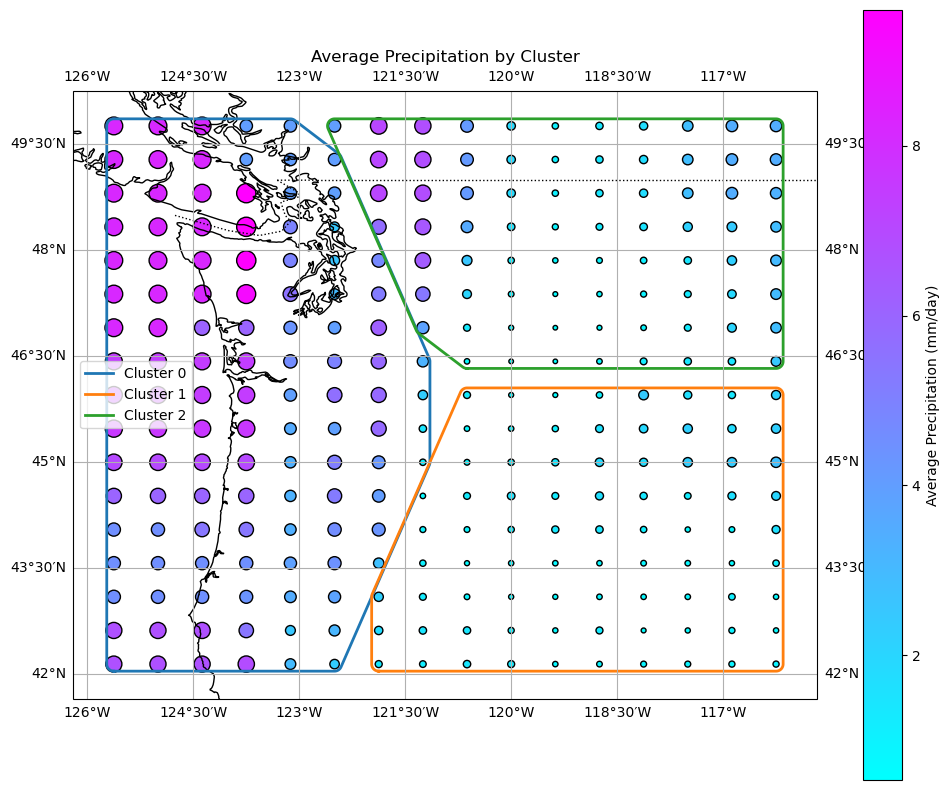

In [81]:
df_clusters = df_flat[['lat','lon','precipitation', 'location_cluster']]

df_clusters = df_clusters.reset_index(drop=True)
plot_precipitation_heatmap_with_clusters(df_clusters, 'Average Precipitation by Cluster')

In [82]:
def plot_precipitation_changes(df_clusters, cluster_label, start_year, end_year):
    """
    Plots the changes in precipitation for a specific cluster over consecutive periods.

    Parameters:
    - df_clusters: pandas DataFrame with time-indexed precipitation data for each location cluster
    - cluster_label: The label of the cluster to plot
    - start_year: The starting year for the first period
    - end_year: The ending year for the last period
    """

    interval = end_year - start_year

    cluster_data = df_clusters[df_clusters['location_cluster'] == cluster_label]

    # Filter data for the specified years
    period_data = cluster_data[(cluster_data['year'] >= start_year) & (cluster_data['year'] <= end_year)]

    # Group by year and calculate mean precipitation
    grouped_data = period_data.groupby('year')['precipitation'].mean()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(grouped_data.index, grouped_data.values, marker='o')
    plt.xlabel('Year')
    plt.ylabel('Average Precipitation (mm/day)')
    plt.title(f'Changes in Precipitation for Cluster {cluster_label} over Consecutive {interval}-Year Periods')
    plt.grid(True)
    plt.xticks(grouped_data.index)
    plt.show()


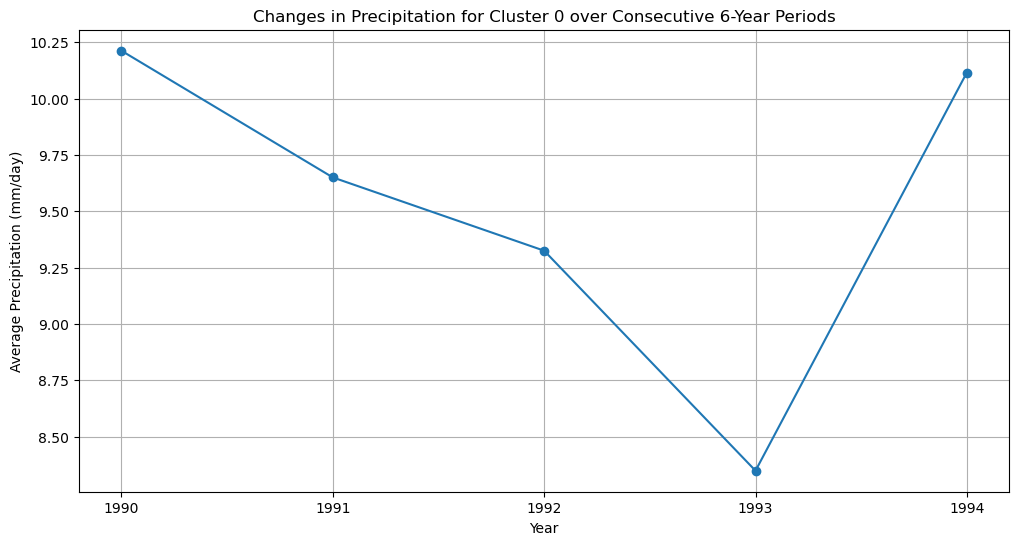

In [92]:
df_clusters = df_flat[['lat','lon','precipitation', 'location_cluster', 'year']]

df_clusters = df_clusters.reset_index(drop=True)

df_clusters_nonzero = df_clusters[df_clusters['precipitation'] > 0]

plot_precipitation_changes(df_clusters_nonzero, 0, 1990, 1996)

In [93]:
df_clusters.set_index('year')

lat      lon  precipitation  location_cluster
year                                                    
1949  49.76094 -125.625      12.451237                 0
1949  49.76094 -125.000      10.839300                 0
1949  49.76094 -124.375       9.390542                 0
1949  49.76094 -123.750       7.837927                 0
1949  49.76094 -123.125       6.168290                 0
...        ...      ...            ...               ...
1994  42.14206 -118.750      23.900000                 1
1994  42.14206 -118.125      25.800001                 1
1994  42.14206 -117.500       7.400000                 1
1994  42.14206 -116.875       0.000000                 1
1994  42.14206 -116.250       0.000000                 1

[4569872 rows x 4 columns]

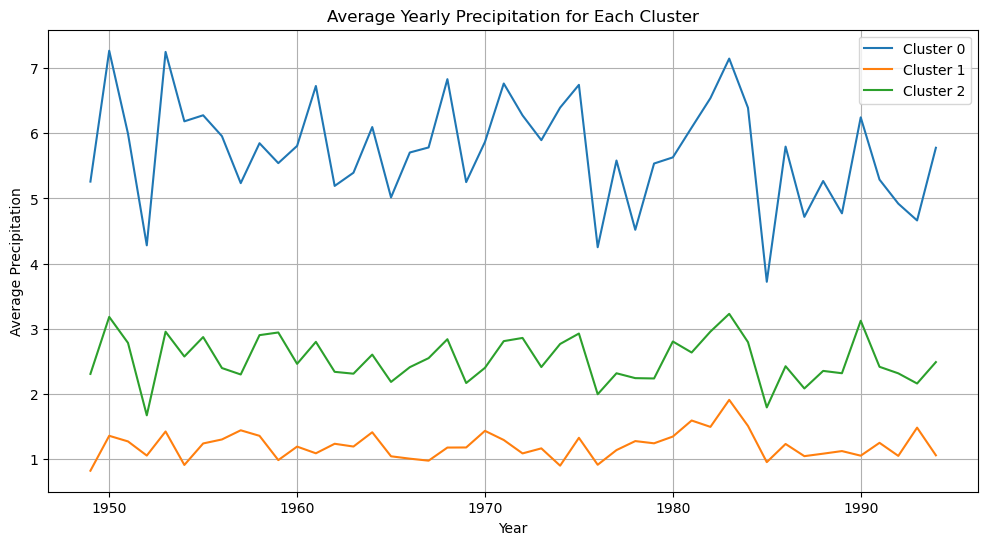

In [439]:
yearly_avg_precipitation = df_flat.groupby(['location_cluster', 'year'])['precipitation'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
for cluster_label, cluster_data in yearly_avg_precipitation.groupby('location_cluster'):
    plt.plot(cluster_data['year'], cluster_data['precipitation'], label=f'Cluster {cluster_label}')

plt.title('Average Yearly Precipitation for Each Cluster')
plt.xlabel('Year')
plt.ylabel('Average Precipitation')
plt.legend()
plt.grid(True)
plt.show()

In [440]:
yearly_avg_precipitation

location_cluster  year  precipitation
0                   0  1949       5.258961
1                   0  1950       7.265723
2                   0  1951       5.993017
3                   0  1952       4.281649
4                   0  1953       7.248019
..                ...   ...            ...
133                 2  1990       3.125270
134                 2  1991       2.419232
135                 2  1992       2.318946
136                 2  1993       2.163107
137                 2  1994       2.491471

[138 rows x 3 columns]

### Additive Decomposition

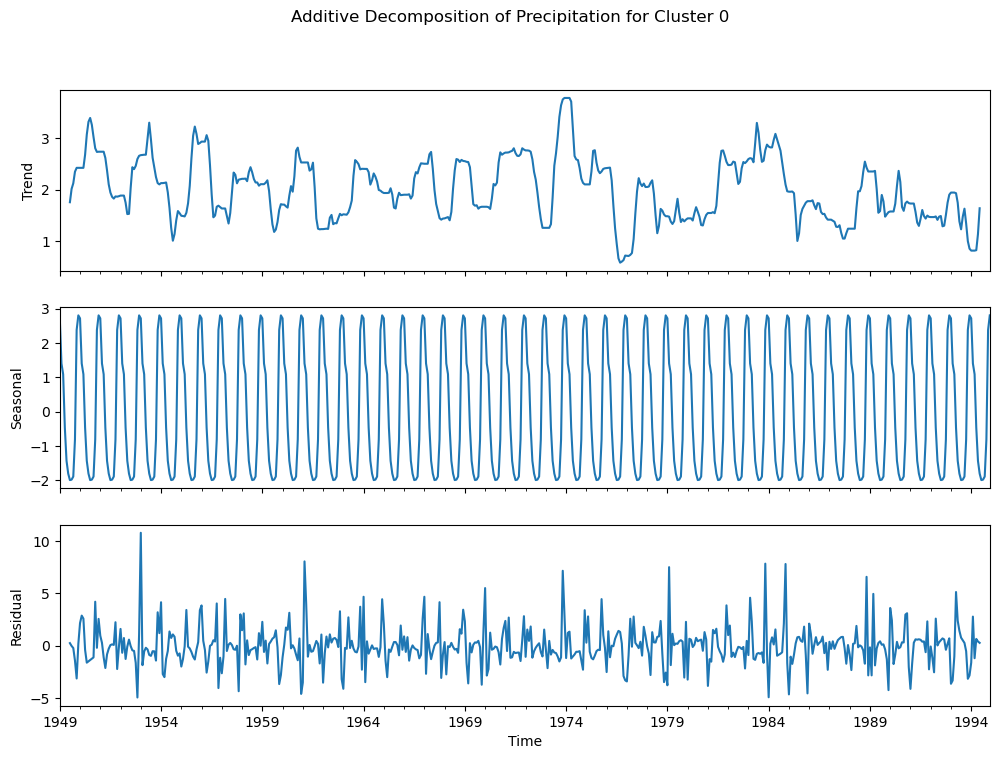

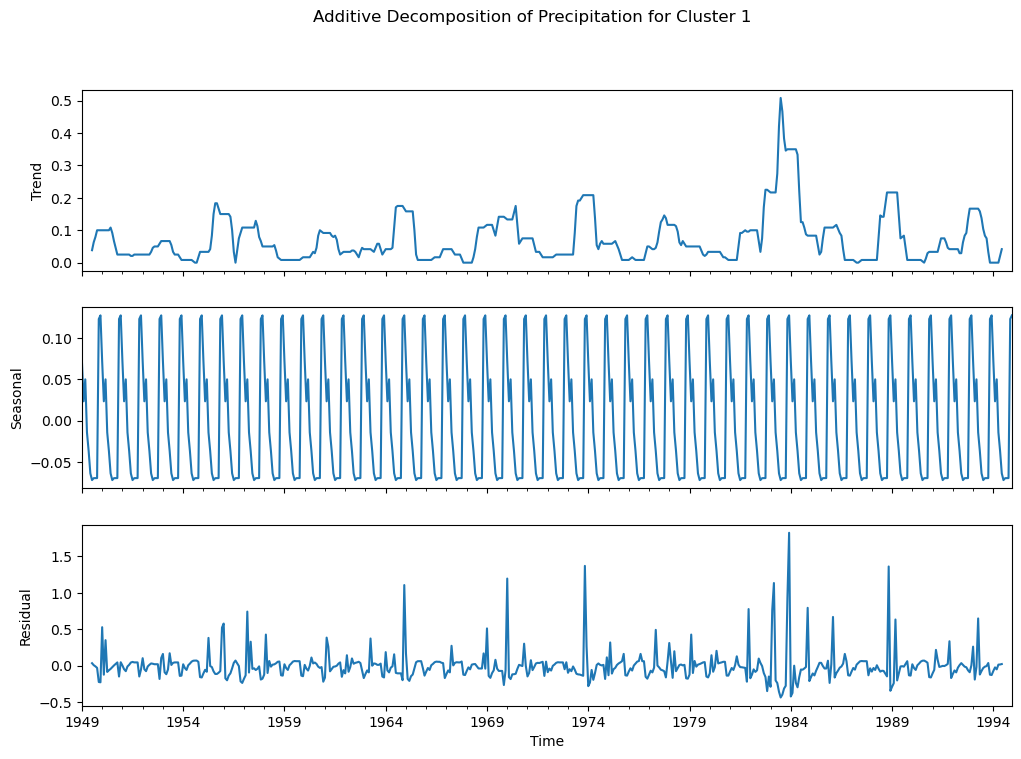

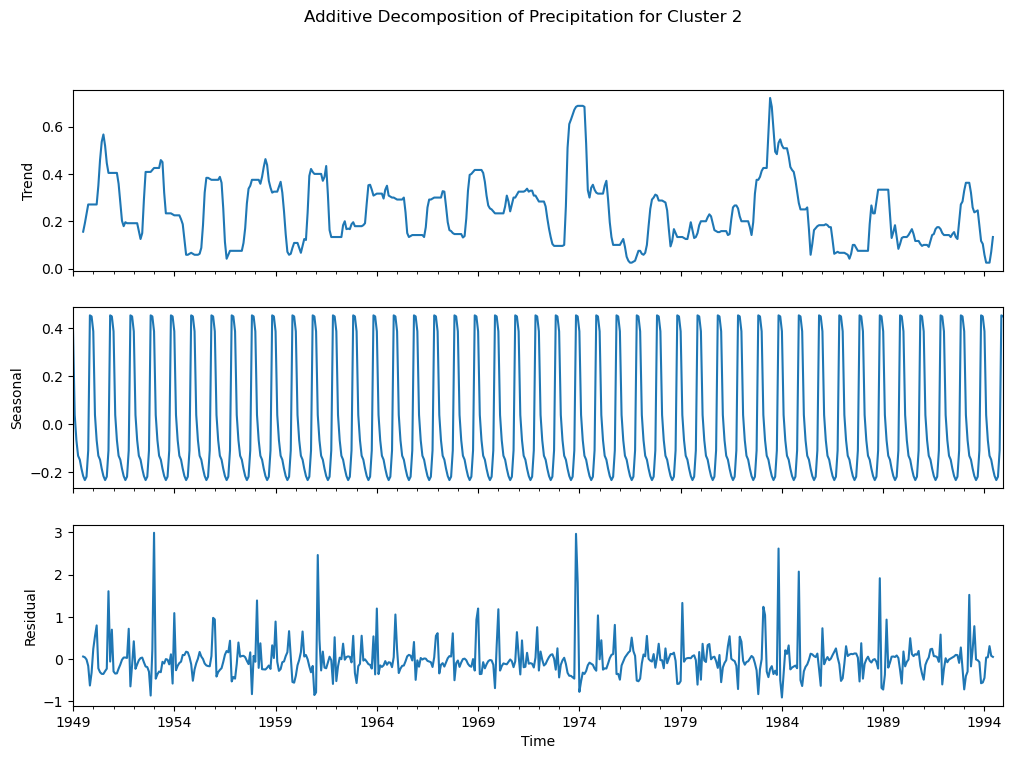

In [717]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_clusters = df_flat[['precipitation', 'location_cluster', 'time']]

for cluster_label, cluster_data in df_clusters.groupby('location_cluster'):
    # Resample to ensure there is data for every month
    # cluster_data_resampled = cluster_data.set_index('time').resample('M').mean().fillna(0)

    # cluster_data_resampled_sum = cluster_data.set_index('time').resample('M').sum().fillna(0)

    cluster_data_resampled_median = cluster_data.set_index('time').resample('M').median().fillna(0)
    
    # Decompose the resampled time series
    decomposition = seasonal_decompose(cluster_data_resampled_median ['precipitation'], model='additive')
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plot the decomposed components
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    trend.plot(ax=ax1, legend=False)
    ax1.set_ylabel('Trend')
    seasonal.plot(ax=ax2, legend=False)
    ax2.set_ylabel('Seasonal')
    residual.plot(ax=ax3, legend=False)
    ax3.set_ylabel('Residual')
    
    # Add titles, labels, etc.
    plt.suptitle(f"Additive Decomposition of Precipitation for Cluster {cluster_label}")
    plt.xlabel('Time')
    plt.show()


### Multiplicative Decomposition

multiplicative seasonal decomposition cannot handle zero or negative values
- some precipitation can be 0

C:\Users\User\AppData\Local\Temp\ipykernel_19132\1666973116.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters['precipitation'] += 0.01


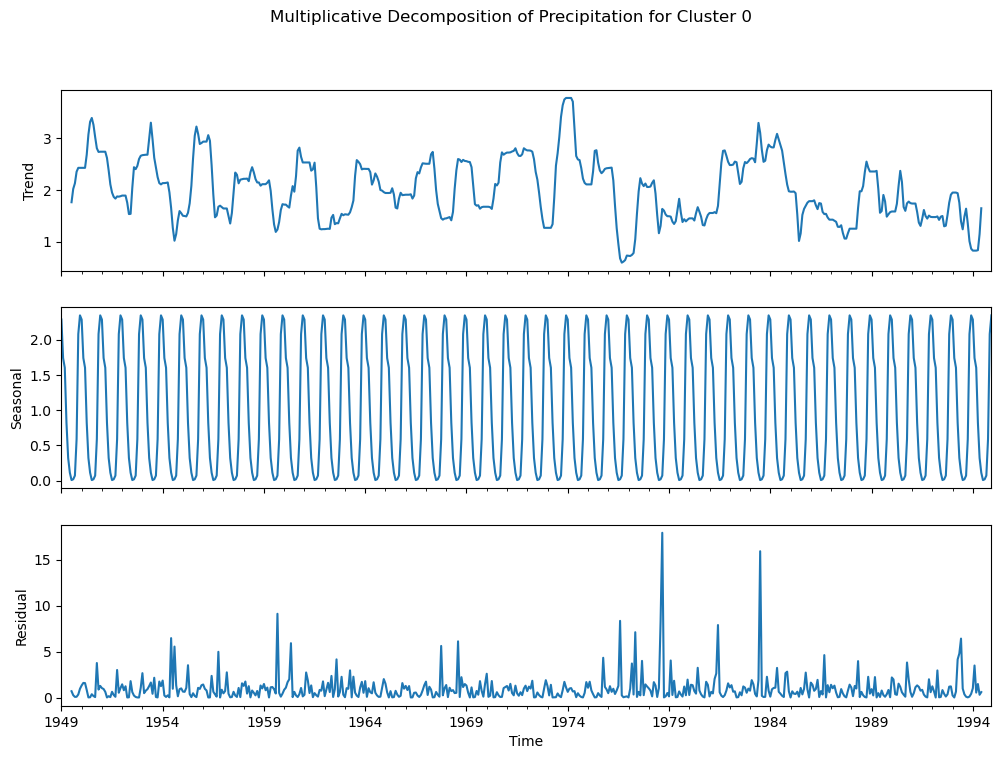

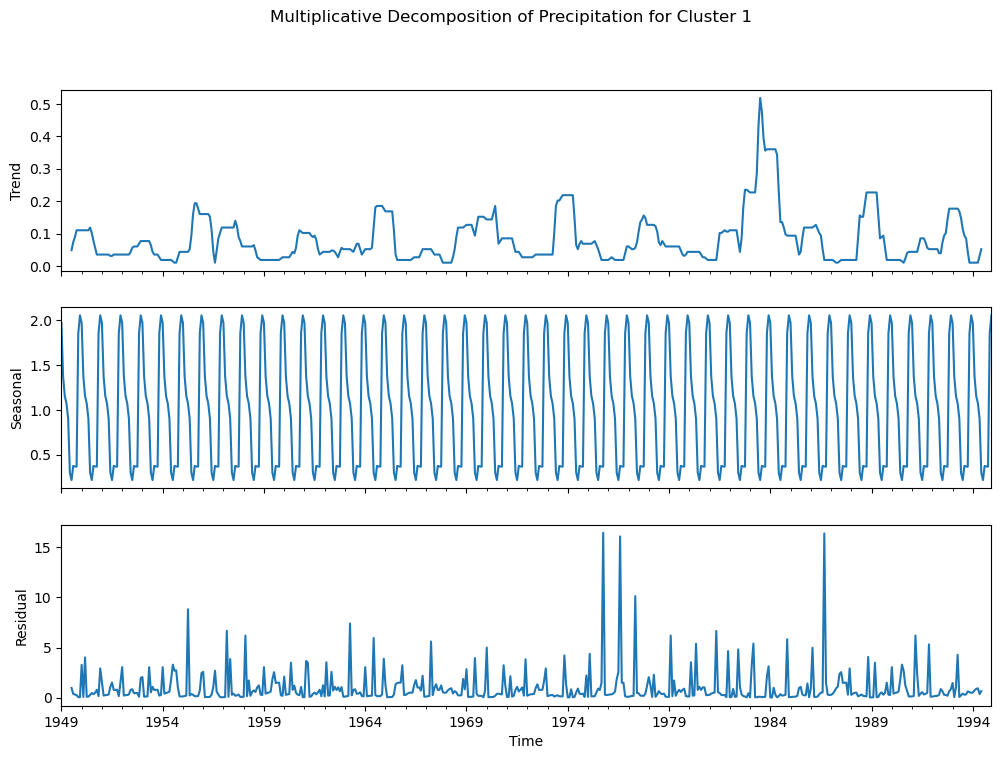

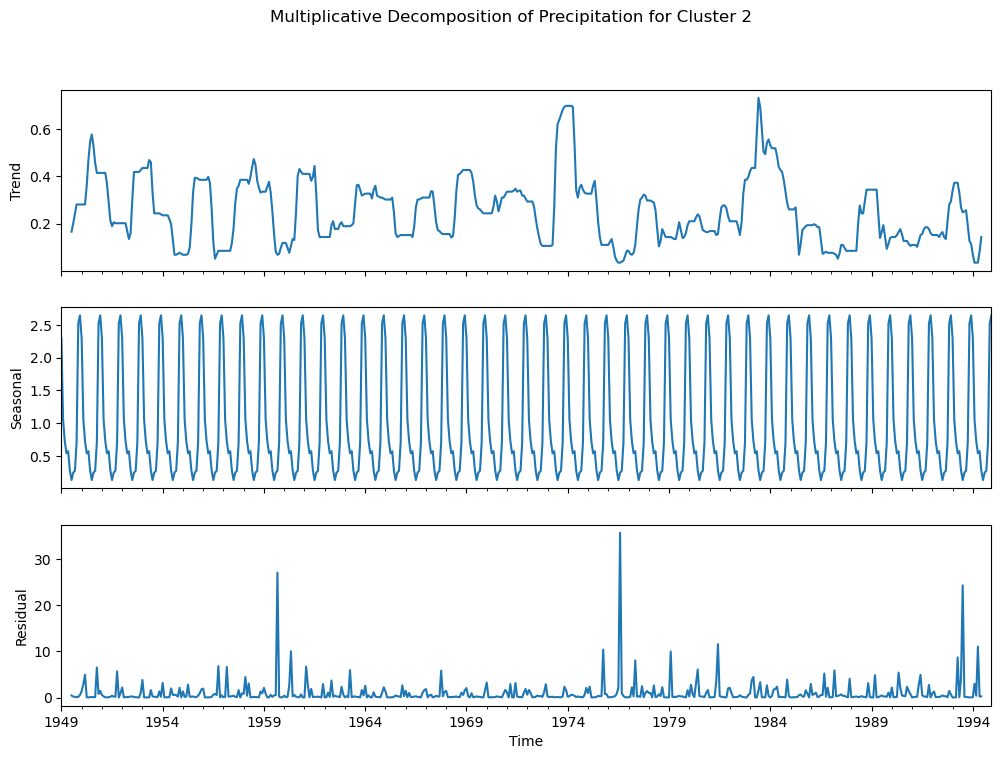

In [718]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_clusters = df_flat[['precipitation', 'location_cluster', 'time']]

df_clusters['precipitation'] += 0.01

for cluster_label, cluster_data in df_clusters.groupby('location_cluster'):
    # Resample to ensure there is data for every month
    # cluster_data_resampled = cluster_data.set_index('time').resample('M').mean().fillna(0)

    # cluster_data_resampled_sum = cluster_data.set_index('time').resample('M').sum().fillna(0)

    cluster_data_resampled_median = cluster_data.set_index('time').resample('M').median().fillna(0)
    
    # Decompose the resampled time series
    decomposition = seasonal_decompose(cluster_data_resampled_median['precipitation'], model='multiplicative')
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plot the decomposed components
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    trend.plot(ax=ax1, legend=False)
    ax1.set_ylabel('Trend')
    seasonal.plot(ax=ax2, legend=False)
    ax2.set_ylabel('Seasonal')
    residual.plot(ax=ax3, legend=False)
    ax3.set_ylabel('Residual')
    
    # Add titles, labels, etc.
    plt.suptitle(f"Multiplicative Decomposition of Precipitation for Cluster {cluster_label}")
    plt.xlabel('Time')
    plt.show()

### Augmented Dickey-Fuller test (Stationary test)

In [497]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(precipitation_df):

    target = 'precipitation_diff' if 'precipitation_diff' in precipitation_df.columns else 'precipitation'

    for cluster_label, cluster_data in precipitation_df.groupby('location_cluster'):
        result = adfuller(cluster_data[target])
        
        print(f"Cluster {cluster_label}:")
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'   {key}: {value}')
        print()


In [444]:
# Group by location_cluster and month, calculate the mean precipitation
monthly_avg_precipitation = df_flat.groupby(['location_cluster', df_flat['time'].dt.month])['precipitation'].mean().reset_index()

adfuller_test(monthly_avg_precipitation)

Cluster 0:
ADF Statistic: -2.965459202634706
p-value: 0.038248417424994796
Critical Values:
   1%: -4.331573
   5%: -3.23295
   10%: -2.7487

Cluster 1:
ADF Statistic: -3.158995229296673
p-value: 0.022484304647853972
Critical Values:
   1%: -4.9386902332361515
   5%: -3.477582857142857
   10%: -2.8438679591836733

Cluster 2:
ADF Statistic: -1.9876186745969395
p-value: 0.29202812627648356
Critical Values:
   1%: -4.331573
   5%: -3.23295
   10%: -2.7487



### ACF & PACF

In [384]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(df_clusters, target='precipitation', differencing=False):
    for cluster_label, cluster_data in df_clusters.groupby('location_cluster'):
        # Plot ACF
        fig, ax = plt.subplots(figsize=(12, 6))
        plot_acf(cluster_data[target], lags=40, ax=ax)
        ax.set_title(f'ACF for Cluster {cluster_label} (Differencing = {differencing})')
        plt.show()

        # Plot PACF
        fig, ax = plt.subplots(figsize=(12, 6))
        plot_pacf(cluster_data[target], lags=40, ax=ax)
        ax.set_title(f'PACF for Cluster {cluster_label} (Differencing = {differencing})')
        plt.show()

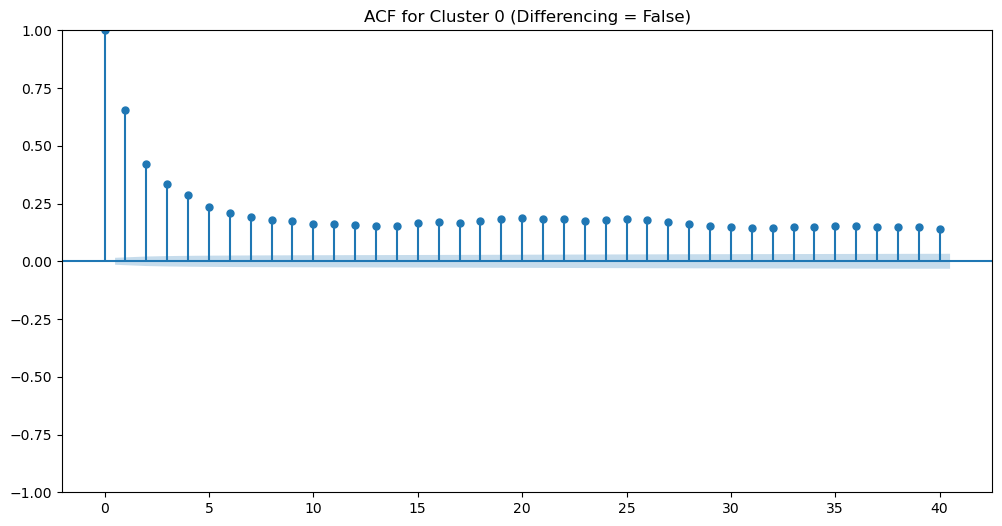

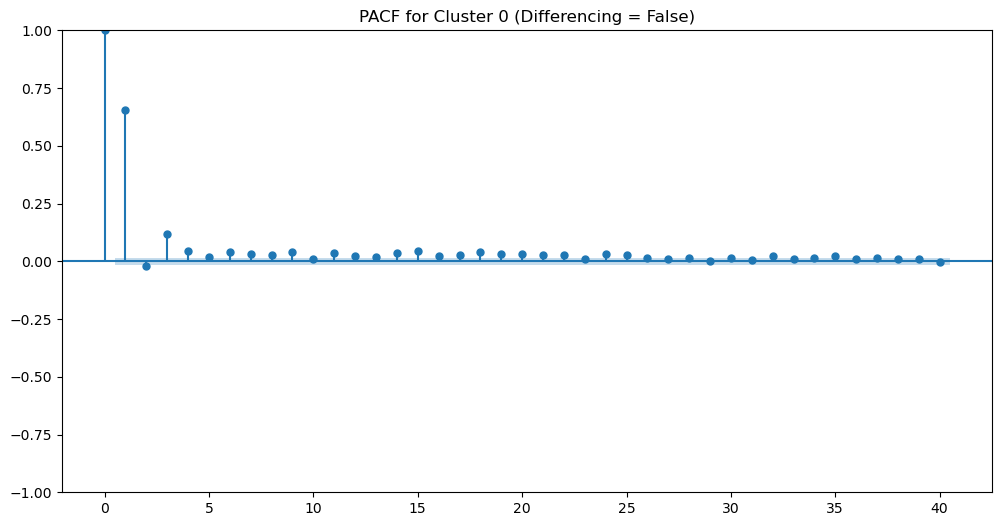

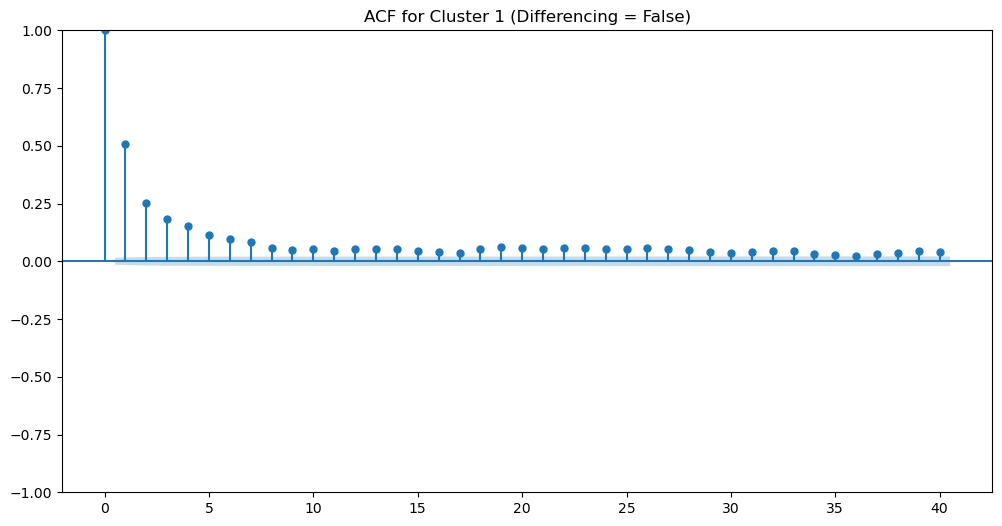

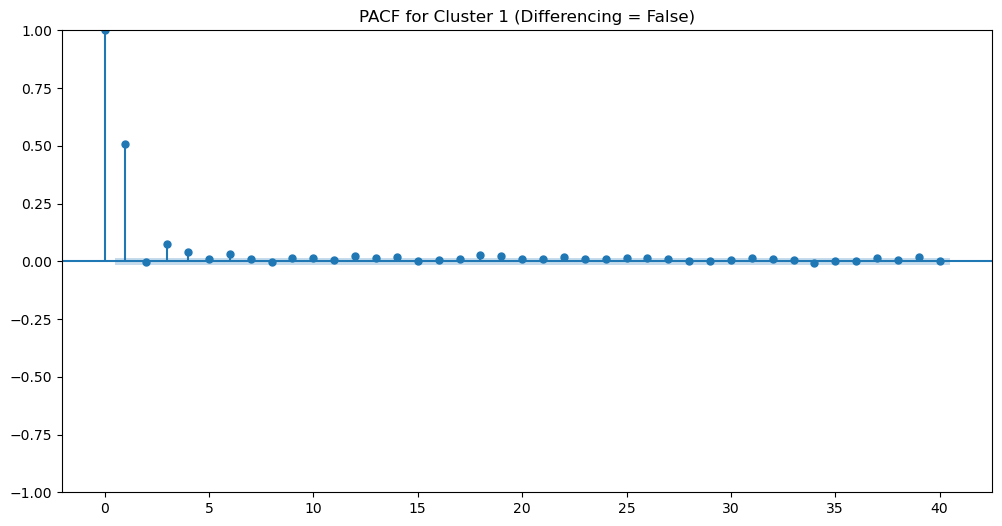

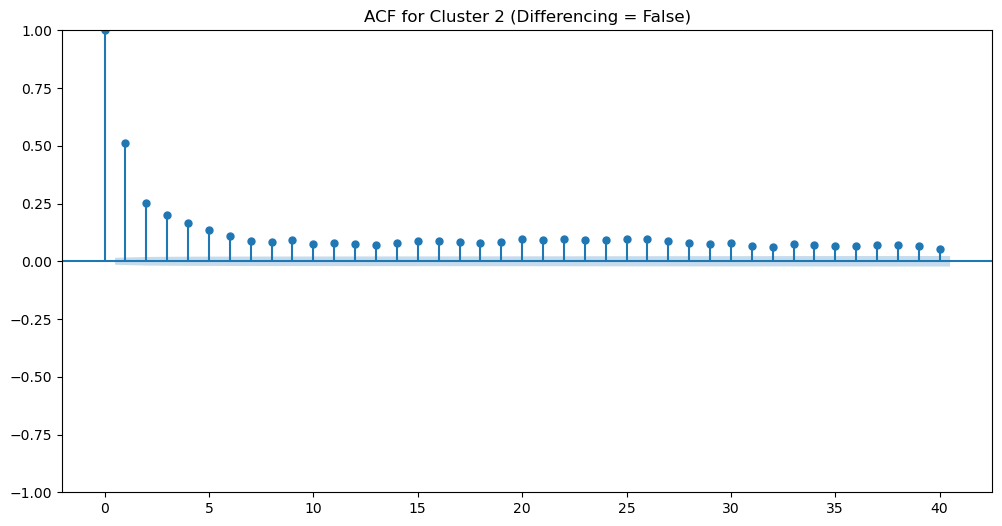

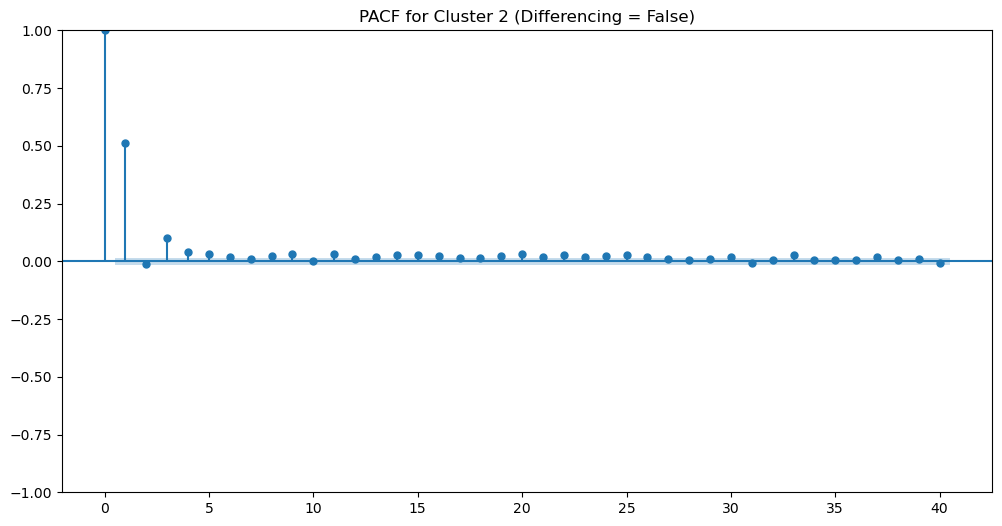

In [385]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df_clusters = df_flat[['precipitation', 'location_cluster', 'time']]

df_clusters = df_clusters.groupby(['time', 'location_cluster']).agg({'precipitation': 'mean'}).reset_index()

plot_acf_pacf(df_clusters, target='precipitation', differencing=False)

Corr heatmap

C:\Users\User\AppData\Local\Temp\ipykernel_21968\1076382932.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_flat.corr()


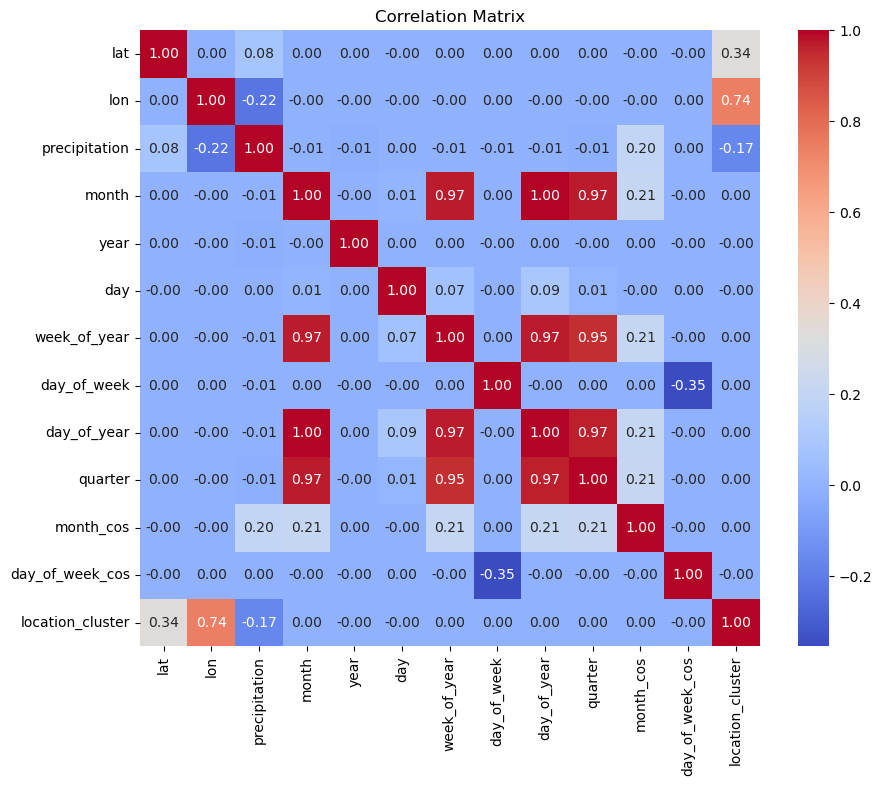

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df_flat.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

### Resample data into 3 month interval

In [321]:
def clip_negative_value(df, clip=True, lower_value=0):
    
    key = 'precipitation_diff' if 'precipitation_diff' in df.columns else 'precipitation'

    if clip:
        # Clip negative values in precipitation_diff to 0
        df[key] = df[key].clip(lower=lower_value).copy()
    else:
        df[key] = df[key]

    return df

In [322]:
def extract_process_cluster_data(df_clusters, cluster: int, clip=True):
    # Clip (Limit) negative value and extract specific cluster

    # Extract specific cluster
    cluster_data_clipped = df_clusters[df_clusters['location_cluster'] == cluster].copy()

    cluster_data_clipped = clip_negative_value(cluster_data_clipped, lower_value=0)

    # Drop precipitation and location_cluster columns
    # cluster_data_clipped.drop(['precipitation', 'location_cluster'], axis=1, inplace=True)

    if 'time' not in cluster_data_clipped.index.names:
        # Ensure the 'time' column is a datetime-like object
        cluster_data_clipped['time'] = pd.to_datetime(cluster_data_clipped['time'])
        # Set the 'time' column as the index
        cluster_data_clipped.set_index('time', inplace=True)    

    return cluster_data_clipped

In [490]:
def process_all_clusters(df_clusters, resample_interval ='3M', resample_calculation = 'mean', clip=True):
    # Clip negative values, resample time for each cluster data and combine

    # List to store processed cluster data
    processed_clusters = []

    # Iterate over each cluster
    for cluster_id in df_clusters['location_cluster'].unique():
        # Extract and process data for the current cluster
        cluster_data_clipped = extract_process_cluster_data(df_clusters, cluster_id, clip)

        # Check if 'precipitation_diff' is in the df
        key = 'precipitation_diff' if 'precipitation_diff' in df_clusters.columns else 'precipitation'

        # Resample data
        if resample_calculation.lower() == 'median':
            seasonal_precipitation = cluster_data_clipped[key].resample(resample_interval).median()     
        else:
            seasonal_precipitation = cluster_data_clipped[key].resample(resample_interval).mean()

        seasonal_precipitation = seasonal_precipitation.reset_index()
        seasonal_precipitation.set_index('time', inplace=True)

        # Add cluster_id column for identification
        seasonal_precipitation['location_cluster'] = cluster_id

        # Append processed cluster data to the list
        processed_clusters.append(seasonal_precipitation)

    # Concatenate processed cluster data into a single DataFrame
    processed_df = pd.concat(processed_clusters)

    return processed_df

## Differencing

In [530]:
# Sort the DataFrame by 'location_cluster' and 'time'
df_clusters_diff = df_clusters.sort_values(by=['location_cluster', 'time'])

# Perform differencing for each 'location_cluster'
df_clusters_diff['precipitation_diff'] = df_clusters_diff.groupby('location_cluster')['precipitation'].diff(1)

# Remove NaN
df_clusters_diff.sort_values('time', inplace=True)
df_clusters_diff = df_clusters_diff.iloc[3:]

In [386]:
# Sort the DataFrame by 'location_cluster' and 'time'
# df_clusters_diff = df_clusters_diff.sort_values(by=['location_cluster', 'time'])

# # Perform differencing for each 'location_cluster'
# df_clusters_diff['precipitation_diff'] = df_clusters_diff.groupby('location_cluster')['precipitation'].diff(1)

In [374]:
# df_clusters_diff = df_flat[['precipitation', 'location_cluster', 'time']]

# df_clusters_diff = df_clusters.groupby(['time', 'location_cluster']).agg({'precipitation': 'mean'}).reset_index()

# for cluster_label, cluster_data in df_clusters_diff.groupby('location_cluster'):
#     cluster_data.sort_values('time', inplace=True)
    
#     # Perform differencing
#     cluster_data['precipitation_diff'] = cluster_data['precipitation'].diff(1)
    
    # Merge back into the original DataFrame
    # df_clusters_diff.loc[(df_clusters['location_cluster'] == cluster_label) & (df_clusters['time'].isin(cluster_data['time'])), 'precipitation_diff'] = cluster_data['precipitation_diff'].values
    
    # print(f"Differenced data for Cluster {cluster_label}:")
    # print(cluster_data[['time', 'precipitation_diff']])

In [531]:
def reverse_diff_and_clip(df_clusters_diff, cluster):
    # Get the key for precipitation
    key = 'precipitation_diff' if 'precipitation_diff' in df_clusters_diff.columns else 'precipitation'
    
    # Extract data for the specific cluster
    cluster_data = df_clusters_diff[df_clusters_diff['location_cluster'] == cluster].copy()
    
    # Reverse the clipping
    cluster_data[key] = cluster_data[key].clip(0, None)
    
    # Reverse the differencing
    cluster_data['reversed_precipitation'] = cluster_data[key].cumsum()
    
    return cluster_data

In [532]:
def reverse_diff_and_clip_forecasts(forecasts):
    reversed_forecasts = {}
    for cluster, data in forecasts.items():
        # Reverse the clipping
        data = data.clip(0, None)
        
        # Reverse the differencing
        reversed_data = data.cumsum()
        
        # Store the reversed data
        reversed_forecasts[cluster] = reversed_data
    
    return reversed_forecasts

ADF on Diff Data

In [549]:
df_clusters_diff_adf = process_all_clusters(df_clusters_diff, resample_interval='D', resample_calculation='mean', clip=False)

In [550]:
df_clusters_diff_adf 

precipitation_diff  location_cluster
time                                            
1949-01-01            1.795999                 2
1949-01-02            0.772039                 2
1949-01-03            0.068093                 2
1949-01-04            0.000475                 2
1949-01-05            0.362506                 2
...                        ...               ...
1994-12-27            9.626087                 0
1994-12-28            2.161739                 0
1994-12-29            0.273913                 0
1994-12-30            0.420000                 0
1994-12-31            0.025217                 0

[50403 rows x 2 columns]

In [551]:
adfuller_test(df_clusters_diff_adf)

Cluster 0:
ADF Statistic: -11.316704912059308
p-value: 1.2016797825851572e-20
Critical Values:
   1%: -3.43074023280633
   5%: -2.8617124673489167
   10%: -2.566861799976219

Cluster 1:
ADF Statistic: -18.630707581902556
p-value: 2.057694456202894e-30
Critical Values:
   1%: -3.4307399070584057
   5%: -2.861712323390769
   10%: -2.5668617233493234

Cluster 2:
ADF Statistic: -14.824674886497547
p-value: 1.9398228951372044e-27
Critical Values:
   1%: -3.430740046598043
   5%: -2.86171238505768
   10%: -2.566861756173752



ACF & PACF after differencing

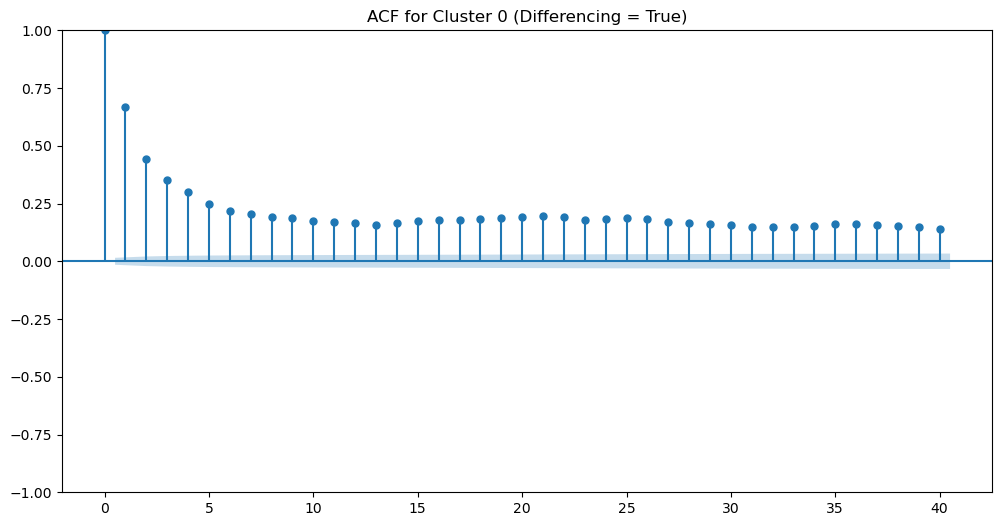

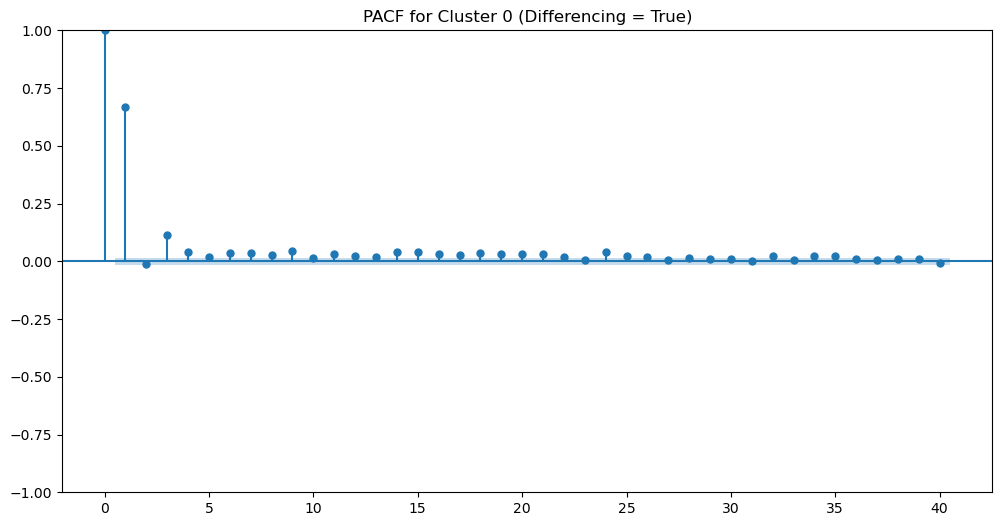

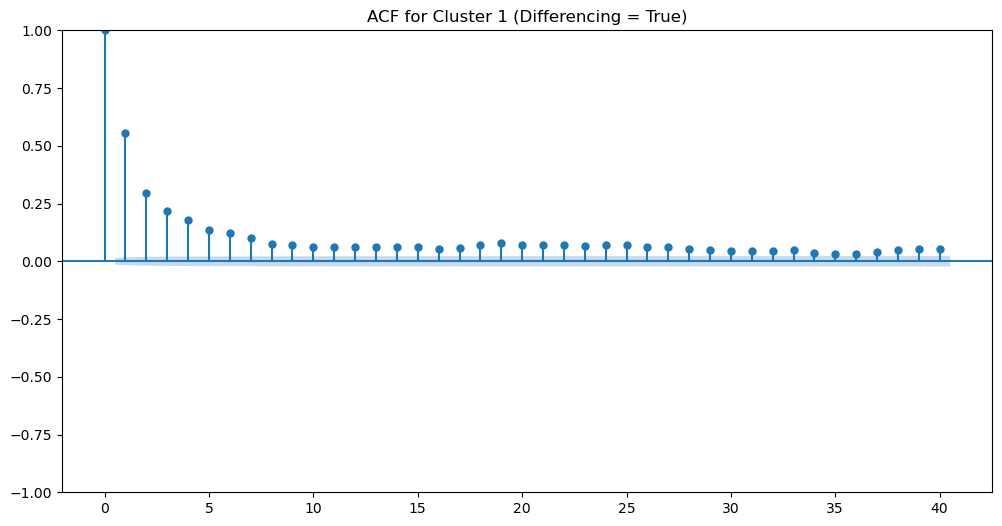

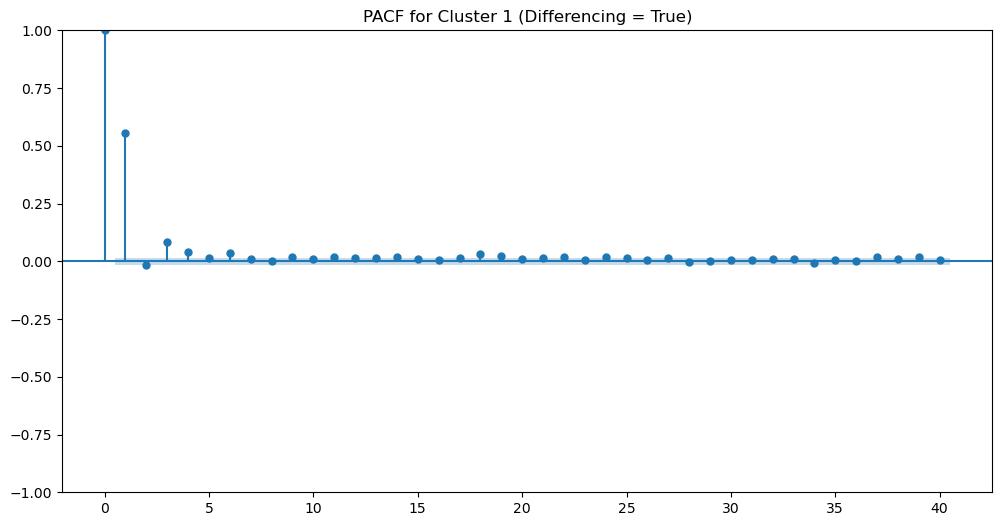

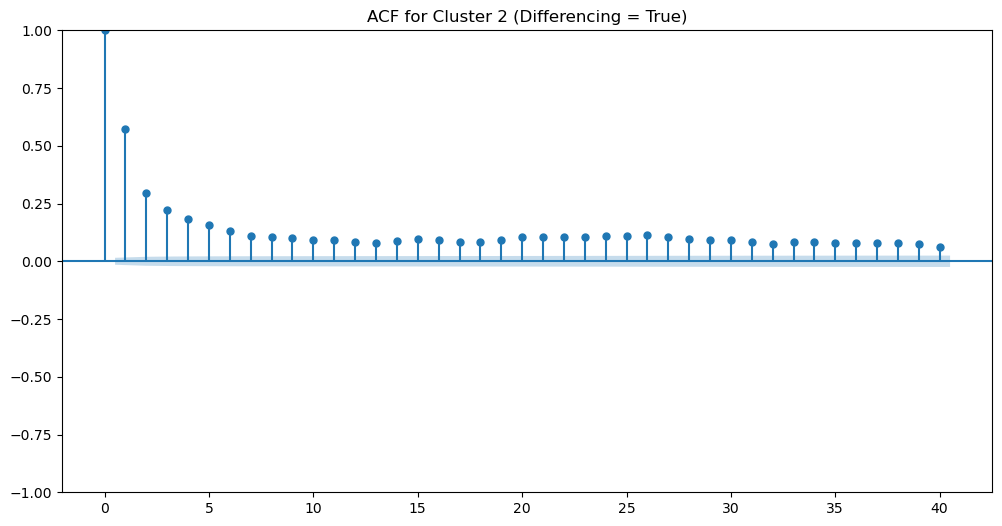

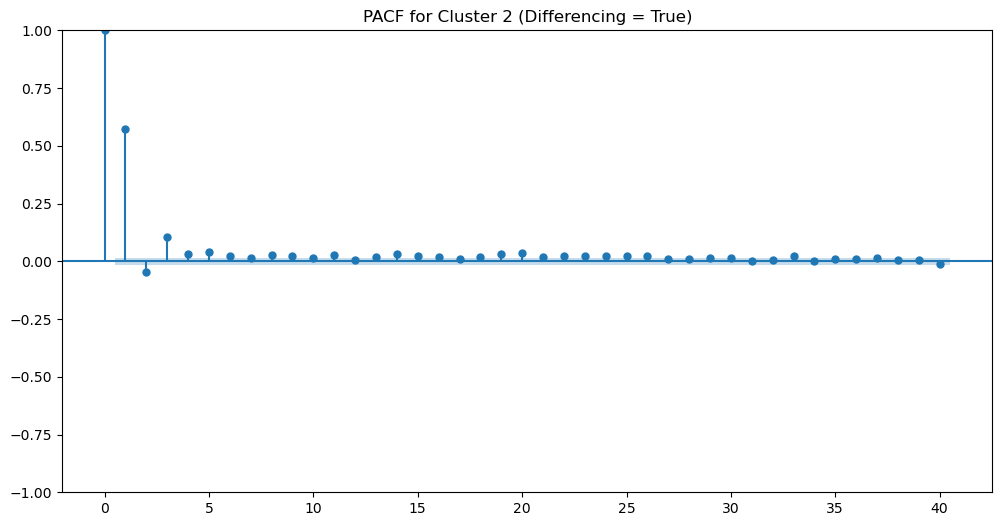

In [552]:
# df_clusters_diff_clipped = clip_negative_value(df_clusters_diff)

plot_acf_pacf(df_clusters_diff_adf, target='precipitation_diff', differencing=True)

# Training Models

In [469]:
import numpy as np
import warnings
import itertools
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, KFold, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
warnings.filterwarnings("ignore", message="No frequency information was provided.*")


Only specific location

In [406]:
df_flat['lat'].unique()

array([49.76094, 49.28476, 48.80858, 48.3324 , 47.85622, 47.38004,
       46.90386, 46.42768, 45.9515 , 45.47532, 44.99914, 44.52296,
       44.04678, 43.5706 , 43.09442, 42.61824, 42.14206])

In [407]:
df_flat['lon'].unique()

array([-125.625, -125.   , -124.375, -123.75 , -123.125, -122.5  ,
       -121.875, -121.25 , -120.625, -120.   , -119.375, -118.75 ,
       -118.125, -117.5  , -116.875, -116.25 ])

Baseline

In [421]:
baseline_df = process_all_clusters(df_clusters_diff)

In [422]:
target = 'precipitation_diff' if 'precipitation_diff' in baseline_df.columns else 'precipitation'

for cluster_id in baseline_df['location_cluster'].unique():
    # Filter data for the current cluster
    cluster_data = baseline_df[baseline_df['location_cluster'] == cluster_id]
    
    # Calculate mean and median for the target variable within this cluster
    mean_value = cluster_data[target].mean()
    median_value = cluster_data[target].median()
    
    # Store these baseline predictions back into the DataFrame
    baseline_df.loc[baseline_df['location_cluster'] == cluster_id, 'mean_prediction'] = mean_value
    baseline_df.loc[baseline_df['location_cluster'] == cluster_id, 'median_prediction'] = median_value

if target in baseline_df.columns:
    overall_rmse_mean = np.sqrt(mean_squared_error(baseline_df[target], baseline_df['mean_prediction']))
    overall_rmse_median = np.sqrt(mean_squared_error(baseline_df[target], baseline_df['median_prediction']))
    
    print(f'Overall Mean Predictor RMSE: {overall_rmse_mean}')
    print(f'Overall Median Predictor RMSE: {overall_rmse_median}')

Overall Mean Predictor RMSE: 0.7108699612104261
Overall Median Predictor RMSE: 0.7225585530851291


In [423]:
if target in baseline_df.columns:
    # Calculate RMSE for each cluster and overall
    for cluster_id in baseline_df['location_cluster'].unique():
        cluster_data = baseline_df[baseline_df['location_cluster'] == cluster_id]
        rmse_mean = np.sqrt(mean_squared_error(cluster_data[target], cluster_data['mean_prediction']))
        rmse_median = np.sqrt(mean_squared_error(cluster_data[target], cluster_data['median_prediction']))
        
        print(f'Cluster {cluster_id} - Mean Predictor RMSE: {rmse_mean:.4f}, Median Predictor RMSE: {rmse_median:.4f}')

Cluster 0 - Mean Predictor RMSE: 1.1146, Median Predictor RMSE: 1.1316
Cluster 1 - Mean Predictor RMSE: 0.2384, Median Predictor RMSE: 0.2397
Cluster 2 - Mean Predictor RMSE: 0.4658, Median Predictor RMSE: 0.4778


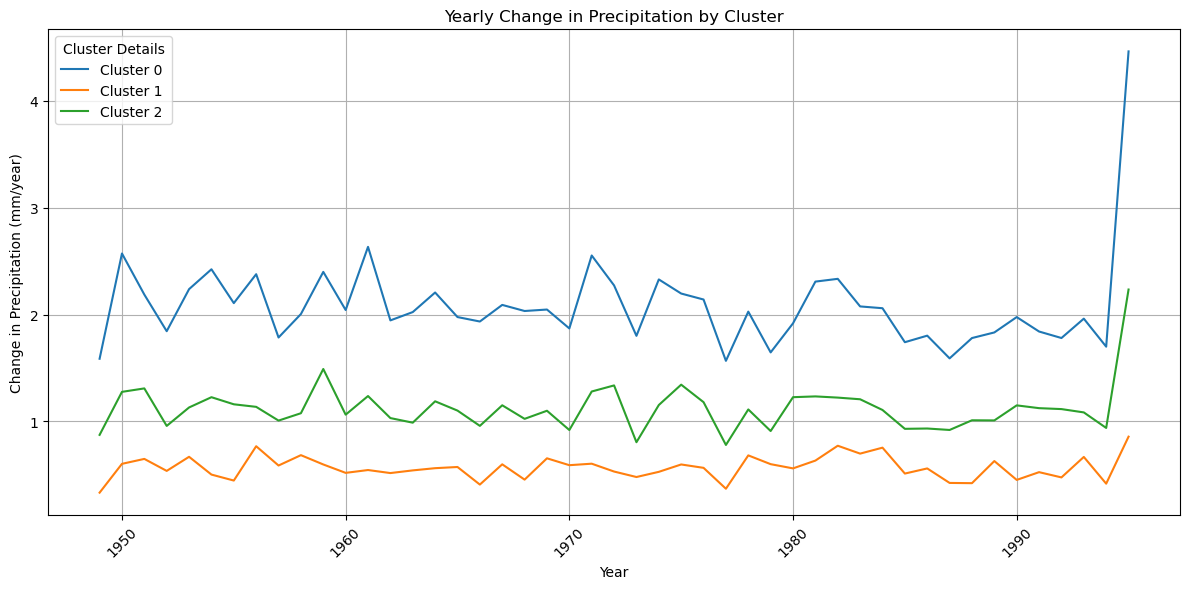

In [424]:
baseline_df = derive_temporal_features(baseline_df.reset_index())

yearly_avg_precipitation = baseline_df.groupby(['location_cluster', 'year'])[target].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
for cluster_label, cluster_data in yearly_avg_precipitation.groupby('location_cluster'):
    plt.plot(cluster_data['year'], cluster_data[target], label=f'Cluster {cluster_label} ')

plt.title('Yearly Change in Precipitation by Cluster')
plt.xlabel('Year')
plt.ylabel('Change in Precipitation (mm/year)')
plt.legend(title='Cluster Details')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Machine Learning Models

Functions

In [425]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

In [426]:
def calculate_average_metrics(rmse_values : list, mae_values : list, r2_values : list):
    avg_rmse = np.mean(rmse_values)
    avg_mae = np.mean(mae_values)
    avg_r2 = np.mean(r2_values)
    return avg_rmse, avg_mae, avg_r2

In [427]:
def plot_model_scores(model, X_train, y_train, X_test, y_test, model_name):
    # Make predictions
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)

    # Calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(y_train, trainPredict))
    testScore = np.sqrt(mean_squared_error(y_test, testPredict))
    
    # Print RMSE
    # print(f'Train Score ({model_name}): {trainScore:.2f} RMSE')
    # print(f'Test Score ({model_name}): {testScore:.2f} RMSE')

    # Plot RMSE
    plt.figure(figsize=(6, 4))
    plt.bar(['Training', 'Testing'], [trainScore, testScore], color=['blue', 'orange'])
    plt.title(f'RMSE Comparison ({model_name})')
    plt.ylabel('RMSE')
    plt.ylim(0, max(trainScore, testScore) * 1.2)
    plt.show()

    return trainScore, testScore

In [428]:
def calc_residuals(observed, predicted):
    """
    Calculate residuals given observed and predicted values.

    Args:
    - observed (list or numpy array): The observed values.
    - predicted (list or numpy array): The predicted values.

    Returns:
    - residuals (numpy array): The residuals.
    """
    import numpy as np

    observed = np.array(observed)
    predicted = np.array(predicted)
    residuals = observed - predicted

    return residuals

In [429]:
def plot_sampled_predictions(model_name, y_test, y_pred, sample_size, plot_residuals_line=True):

    sample_size = min(sample_size, len(y_pred))
    # Sample the indices from y_pred
    sample_indices = np.random.choice(len(y_pred), size=sample_size, replace=False)
    y_test_sampled = y_test.iloc[sample_indices]
    y_pred_sampled = y_pred[sample_indices]
    residuals_sampled = y_pred_sampled - y_test_sampled

    # Calculate average residual
    avg_residual = residuals_sampled.mean()

    # Plot the sampled actual values and predicted values with lines connecting them
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_sampled.index, y_test_sampled, color='blue', label='Observed', alpha=0.6)
    plt.scatter(y_test_sampled.index, y_pred_sampled, color='red', label='Predicted', alpha=0.6)
    if plot_residuals_line:
        for i in range(sample_size):
            plt.plot([y_test_sampled.index[i], y_test_sampled.index[i]], [y_test_sampled.iloc[i], y_pred_sampled[i]], color='black', linestyle='-', linewidth=1)
        plt.text(y_test_sampled.index.min(), avg_residual, f'Avg Residual: {avg_residual:.2f}', ha='left', va='center', backgroundcolor='white')
    plt.xlabel('Index')
    plt.ylabel('Precipitation')
    plt.title(f'{sample_size} Sampled Observed vs Predicted Precipitation ({model_name})')
    plt.legend()
    plt.show()

In [430]:
# Function to plot learning curves
def plot_learning_curves(model, X, y, model_name=None):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_root_mean_squared_error'
    )
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training error')
    plt.plot(train_sizes, test_scores_mean, label='Validation error')
    plt.xlabel('Training')
    plt.ylabel('Root Mean Squared Error')
    plt.title(f'Learning Curves ({model_name})')
    plt.legend()
    plt.show()

In [431]:
# Function to plot learning curves with TimeSeriesSplit
def plot_learning_curves_time_series(model, X, y, model_name=None):
    tscv = TimeSeriesSplit(n_splits=5)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=tscv, scoring='neg_mean_squared_error'
    )
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label='Training error')
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label='Validation error')
    plt.title(f'Learning Curves ({model_name})' if model_name else 'Learning Curves')
    plt.xlabel('Training examples')
    plt.ylabel('Mean Squared Error')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [432]:
def update_results_csv(cluster_label, model_name, best_params, metrics, best_metric_score, results_csv_path='parameter_tuning_time_series_results.csv'):
    if not Path(results_csv_path).is_file():
        results_df = pd.DataFrame(columns=['Cluster', 'Model', 'Best Parameters', 'Metrics', 'Best Metric Score'])
    else:
        results_df = pd.read_csv(results_csv_path)
        
    new_row = {'Cluster': cluster_label,
               'Model': model_name,
               'Best Parameters': best_params,
               'Metrics': metrics,
               'Best Metric Score': best_metric_score}
    
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
    
    results_df.to_csv(results_csv_path, index=False)

In [433]:
def update_ml_results_csv(cluster_label, model_name, best_params, metrics, best_metric_score, results_csv_path='parameter_tuning_results.csv'):
    # Check if the results CSV file exists
    if not Path(results_csv_path).is_file():
        # If the file doesn't exist, create a new DataFrame
        results_df = pd.DataFrame(columns=['Cluster', 'Model', 'Best Parameters', 'Metrics', 'Best Metric Score'])
    else:
        # If the file exists, load the existing DataFrame
        results_df = pd.read_csv(results_csv_path)
    
    # Create a new row with the results
    new_row = {'Cluster': cluster_label,
               'Model': model_name,
               'Best Parameters': str(best_params),
               'Metrics': metrics,
               'Best Metric Score': best_metric_score}
    
    # Add the new row to the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
    
    # Save the updated DataFrame to the results CSV file
    results_df.to_csv(results_csv_path, index=False)

### Data For Training

In [802]:
processed_cluster_data = process_all_clusters(df_clusters_diff)

In [803]:
processed_cluster_data = derive_temporal_features(processed_cluster_data.reset_index())

In [447]:
# processed_cluster_data['quarter'] = processed_cluster_data['quarter'].astype('category')
# processed_cluster_data['location_cluster'] = processed_cluster_data['location_cluster'].astype('category')

In [804]:
processed_cluster_data = processed_cluster_data.drop(['month', 'day_of_week'], axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_19132\727414949.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = processed_cluster_data.corr()


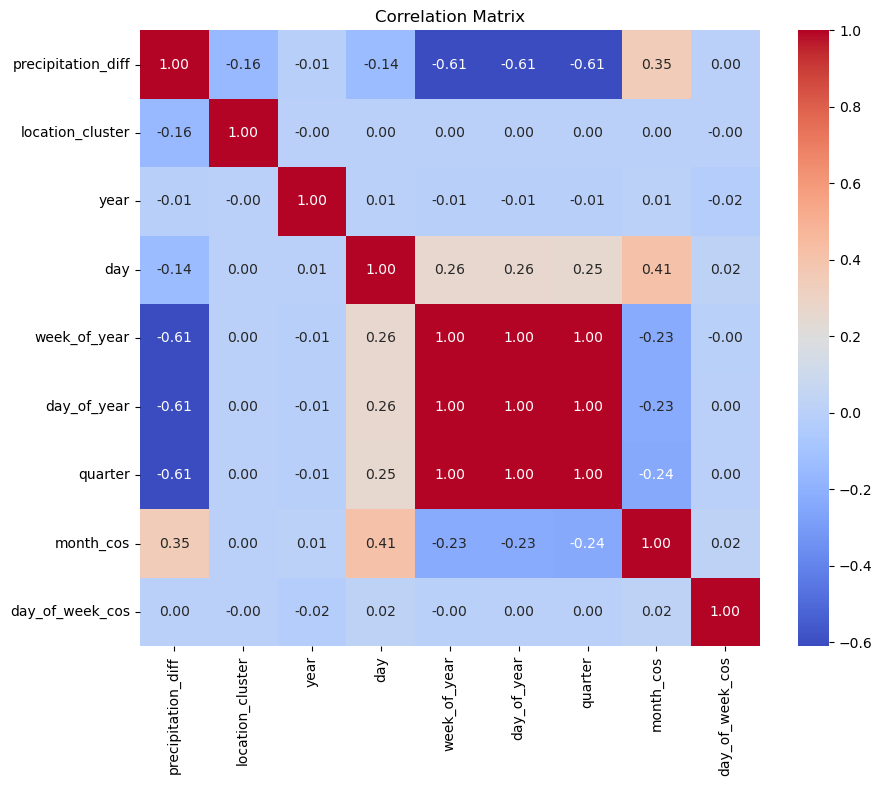

In [805]:
# Compute the correlation matrix
corr = processed_cluster_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

Label Encoding

In [806]:
def label_encode_feature(df, feature):
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    return df

One Hot Encoding

In [807]:
def one_hot_encode_feature(df, feature):
    df_encoded = pd.get_dummies(df, columns=[feature], prefix=[feature])
    return pd.concat([df, df_encoded], axis=1)

In [833]:
seasonal_VAR = processed_cluster_data

seasonal_VAR['year'] = seasonal_VAR['year'].astype('category')
# seasonal_VAR['quarter'] = seasonal_VAR['quarter'].astype('category')
# seasonal_VAR['location_cluster'] = seasonal_VAR['location_cluster'].astype('category')

seasonal_VAR['time'] = pd.to_datetime(seasonal_VAR['time'])
seasonal_VAR = seasonal_VAR.sort_values('time')

seasonal_VAR = label_encode_feature(seasonal_VAR, 'season')

seasonal_VAR = seasonal_VAR.drop(['year','day_of_week_cos'], axis=1)

target = 'precipitation_diff' if 'precipitation_diff' in seasonal_VAR.columns else 'precipitation'

In [834]:
seasonal_VAR

time  precipitation_diff  location_cluster  day  week_of_year  \
0   1949-01-31            0.401841                 2   31             5   
185 1949-01-31            0.209754                 1   31             5   
370 1949-01-31            0.555730                 0   31             5   
1   1949-04-30            1.094839                 2   30            17   
186 1949-04-30            0.507573                 1   30            17   
..         ...                 ...               ...  ...           ...   
183 1994-10-31            0.603704                 2   31            44   
368 1994-10-31            0.186192                 1   31            44   
369 1995-01-31            0.800931                 1   31             5   
184 1995-01-31            1.730091                 2   31             5   
554 1995-01-31            2.749879                 0   31             5   

     day_of_year  quarter  season  month_cos  
0             31        1       3   0.866025  
185           31        1       3   0.866025  
370           31        1       3   0.866025  
1            120        2       1  -0.500000  
186          120        2       1  -0.500000  
..           ...      ...     ...        ...  
183          304        4       0   0.500000  
368          304        4       0   0.500000  
369           31        1       3   0.866025  
184           31        1       3   0.866025  
554           31        1       3   0.866025  

[555 rows x 9 columns]

In [847]:
X = seasonal_VAR.drop([target, 'time'], axis=1)
y = seasonal_VAR[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression 

In [837]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Get coefficients
coefficients = linear_model.coef_
feature_names = X.columns

# feature importance
for feature, coef in zip(feature_names, coefficients):
    print(f'{feature}: {coef}')

location_cluster: -0.11948934693496271
day: -0.12356026052443794
week_of_year: -0.0620416084244739
day_of_year: -0.01804862771335957
quarter: 2.189949597306391
month_cos: 0.2523240597467252


In [838]:
y_pred = linear_model.predict(X_test)

rmse, mae, r2 = evaluate_model(y_pred, y_test)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

RMSE: 0.4212
MAE: 0.3339
R-squared: -0.2278


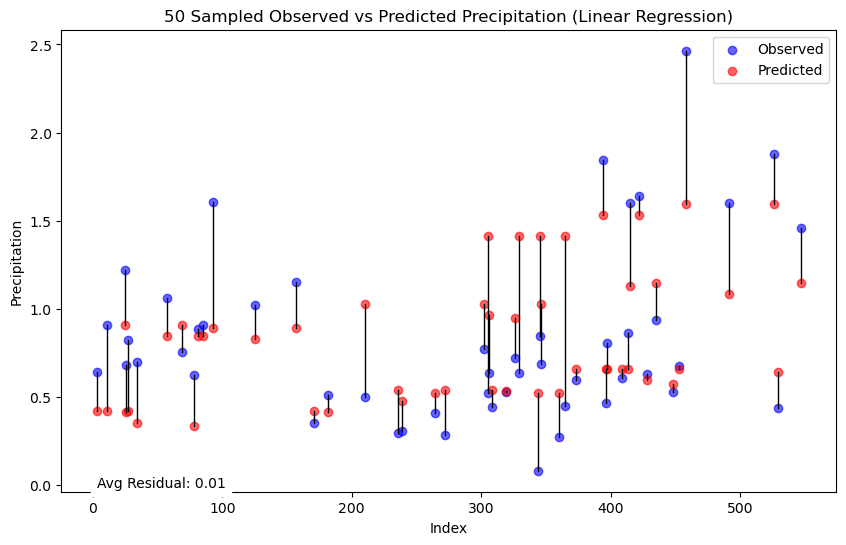

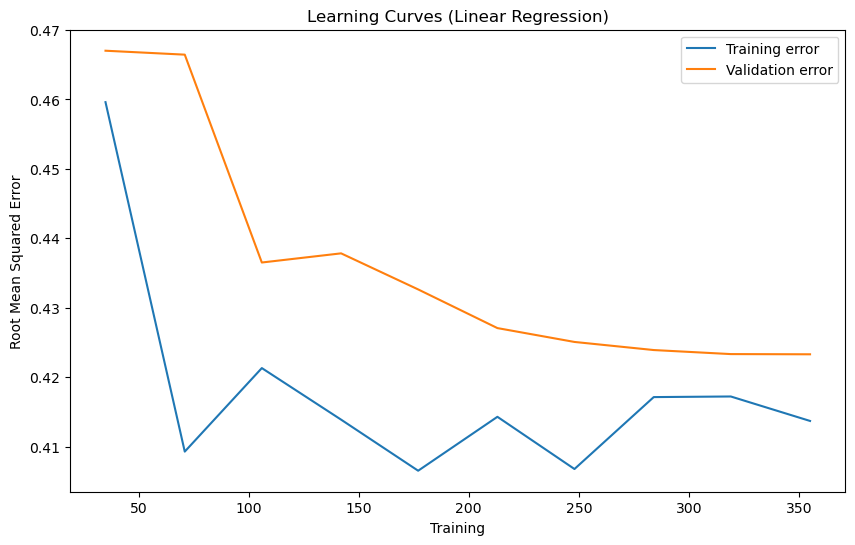

In [839]:
plot_sampled_predictions("Linear Regression", y_test, y_pred, 50)

plot_learning_curves(linear_model, X_train, y_train, 'Linear Regression')

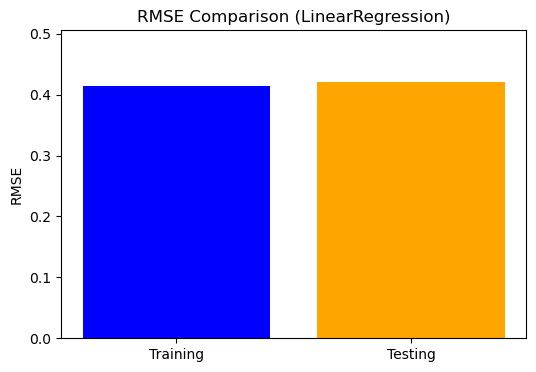

In [825]:
train_score, test_score = plot_model_scores(linear_model, X_train, y_train, X_test, y_test, 'LinearRegression')

### Random Forest

In [877]:
seasonal_VAR 

time  precipitation_diff  location_cluster  day  week_of_year  \
0   1949-01-31            0.401841                 2   31             5   
185 1949-01-31            0.209754                 1   31             5   
370 1949-01-31            0.555730                 0   31             5   
1   1949-04-30            1.094839                 2   30            17   
186 1949-04-30            0.507573                 1   30            17   
..         ...                 ...               ...  ...           ...   
183 1994-10-31            0.603704                 2   31            44   
368 1994-10-31            0.186192                 1   31            44   
369 1995-01-31            0.800931                 1   31             5   
184 1995-01-31            1.730091                 2   31             5   
554 1995-01-31            2.749879                 0   31             5   

     day_of_year  quarter  season  month_cos  
0             31        1       3   0.866025  
185           31        1       3   0.866025  
370           31        1       3   0.866025  
1            120        2       1  -0.500000  
186          120        2       1  -0.500000  
..           ...      ...     ...        ...  
183          304        4       0   0.500000  
368          304        4       0   0.500000  
369           31        1       3   0.866025  
184           31        1       3   0.866025  
554           31        1       3   0.866025  

[555 rows x 9 columns]

In [878]:
# X = seasonal_VAR[['location_cluster', 'month_cos', 'year', 'day_of_year', 'quarter', 'week_of_year', 'day_of_week_cos']]
X = seasonal_VAR.drop([target, 'time'], axis=1)
y = seasonal_VAR[target]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [842]:
tscv = TimeSeriesSplit(n_splits=5)

rmse_values = []
mae_values = []
r2_values = []
fold_count = 0

actual_values = []
predicted_values = []

# Iterate over each fold
for train_index, test_index in tscv.split(X):
    # Create training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model = RandomForestRegressor(max_depth=12,
                                  min_samples_leaf=1,
                                  min_samples_split=2,
                                  n_estimators=
                                  random_state=42)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    actual_values.append(y_test)
    predicted_values.append(y_pred)

    # Evaluate the model
    rmse, mae, r2 = evaluate_model(y_pred, y_test)
    rmse_values.append(rmse)
    mae_values.append(mae)
    r2_values.append(r2)
    fold_count += 1
    print(f"Fold {fold_count}: RMSE = {rmse}, MAE = {mae}, R-squared = {r2}")

avg_rmse, avg_mae, avg_r2 = calculate_average_metrics(rmse_values, mae_values, r2_values)
print(f"Average RMSE: {avg_rmse:.4f}, Average MAE: {avg_mae:.4f}, Average R-squared: {avg_r2:.4f} ")

Fold 1: RMSE = 0.22195191811296003, MAE = 0.15237726882109048, R-squared = 0.8266554793640203
Fold 2: RMSE = 0.22753958705908003, MAE = 0.1740139937672817, R-squared = 0.8222052555519981
Fold 3: RMSE = 0.3146746369186109, MAE = 0.21103090203742209, R-squared = 0.6261856020056631
Fold 4: RMSE = 0.19348486139509632, MAE = 0.15752641026941194, R-squared = 0.8663701836483345
Fold 5: RMSE = 0.24125810320731886, MAE = 0.17863087601387495, R-squared = 0.7991921715256486
Average RMSE: 0.2398, Average MAE: 0.1747, Average R-squared: 0.7881 


In [843]:
def combine_and_sort_actual_predicted(sorted_actual_values, sorted_predicted_values):
    combined_actual_values = pd.concat([pd.Series(arr) for arr in sorted_actual_values], axis=1)
    combined_predicted_values = pd.concat([pd.Series(arr) for arr in sorted_predicted_values], axis=1)

    combined_actual_values = combined_actual_values.stack().reset_index(drop=True)
    combined_predicted_values = combined_predicted_values.stack().reset_index(drop=True)

    # Sort combined values by index
    combined_actual_values = combined_actual_values.sort_index()
    combined_predicted_values = combined_predicted_values.sort_index()

    return combined_actual_values, combined_predicted_values

sorted_actual_values, sorted_predicted_values = combine_and_sort_actual_predicted(actual_values, predicted_values)

In [844]:
sorted_actual_values

0      0.368062
1      1.156035
2      0.422155
3      1.320085
4      0.761881
         ...   
455    0.603704
456    0.186192
457    0.800931
458    1.730091
459    2.749879
Length: 460, dtype: float64

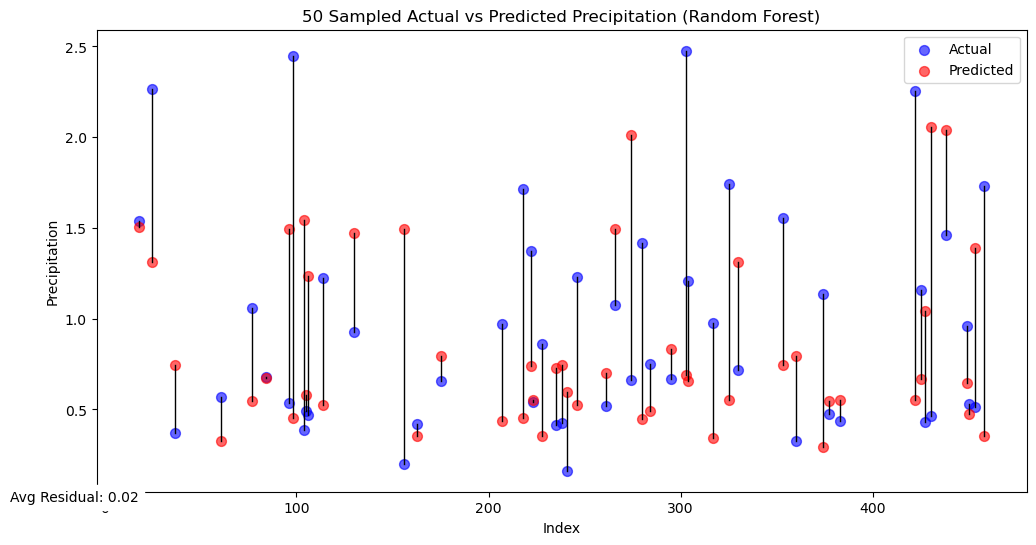

In [845]:
def plot_sampled_predictions_actual_predicted(actual_values, predicted_values, model_name, sample_size, point_size=50):
    # Sample indices for plotting
    sample_indices = np.random.choice(len(actual_values), size=sample_size, replace=False)
    
    plt.figure(figsize=(12, 6))
    plt.scatter(sample_indices, actual_values.iloc[sample_indices], color='blue', label='Actual', alpha=0.6, s=point_size)
    plt.scatter(sample_indices, predicted_values[sample_indices], color='red', label='Predicted', alpha=0.6, s=point_size)

    # Calculate average residuals
    residuals = predicted_values - actual_values.values
    avg_residual = residuals.mean()

    # Plot lines connecting actual and predicted values
    for i in range(sample_size):
        plt.plot([sample_indices[i], sample_indices[i]], [actual_values.iloc[sample_indices[i]], predicted_values[sample_indices[i]]], color='black', linestyle='-', linewidth=1)
    
    plt.text(sample_indices.min(), avg_residual, f'Avg Residual: {avg_residual:.2f}', ha='right', va='center', backgroundcolor='white')
    
    plt.title(f'{sample_size} Sampled Actual vs Predicted Precipitation ({model_name})')
    plt.xlabel('Index')
    plt.ylabel('Precipitation')
    plt.legend()
    plt.show()

    
plot_sampled_predictions_actual_predicted(sorted_actual_values, sorted_predicted_values, 'Random Forest', 50)

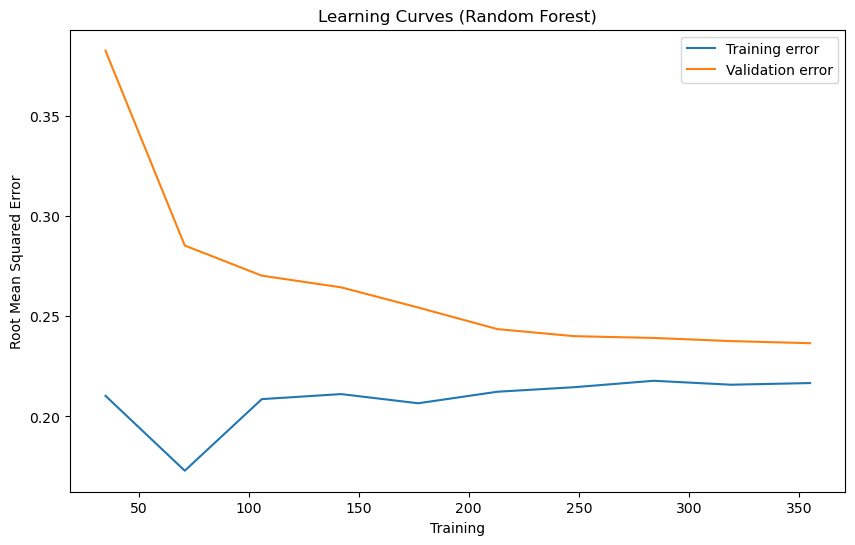

In [850]:
plot_learning_curves(RandomForestRegressor(random_state=42), X_train, y_train, 'Random Forest')

### XGBoost

In [871]:
# X = seasonal_VAR[['location_cluster', 'month_cos', 'year', 'day_of_year', 'quarter', 'week_of_year', 'day_of_week_cos']]
X = seasonal_VAR.drop([target, 'time'], axis=1)
y = seasonal_VAR[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xg_boost = XGBRegressor(random_state=42)
xg_boost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [872]:
# Make predictions
y_pred = xg_boost.predict(X_test)

# Evaluate the model
rmse, mae, r2 = evaluate_model(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

RMSE: 0.2988
MAE: 0.1886
R-squared: 0.6825


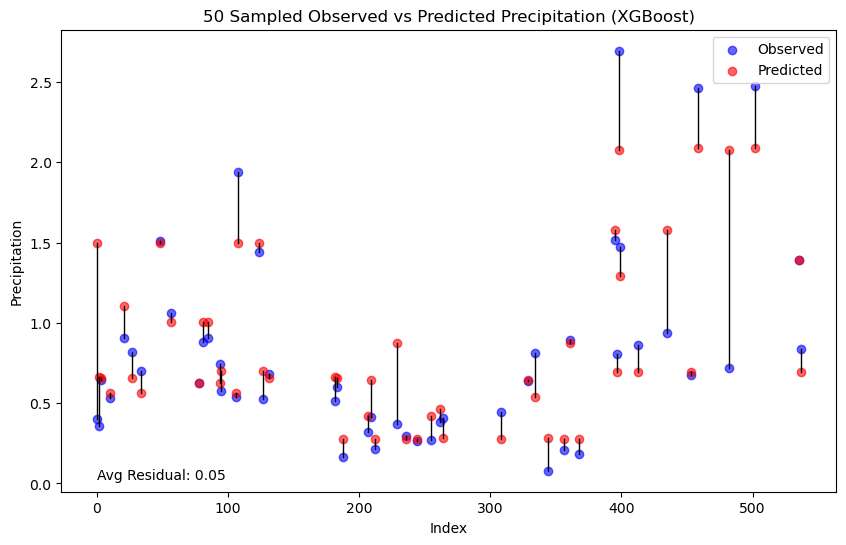

In [873]:
plot_sampled_predictions("XGBoost", y_test, y_pred, 50)

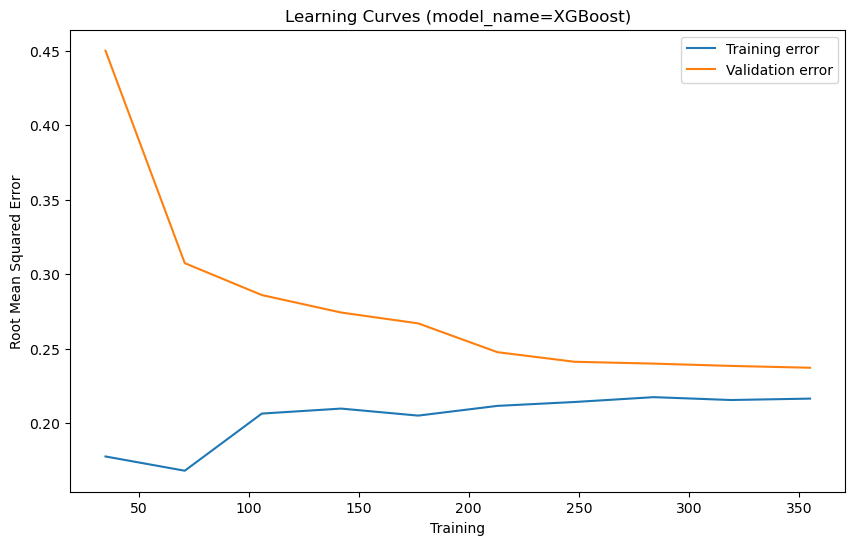

In [874]:
plot_learning_curves(xg_boost, X_train, y_train, 'model_name=XGBoost')

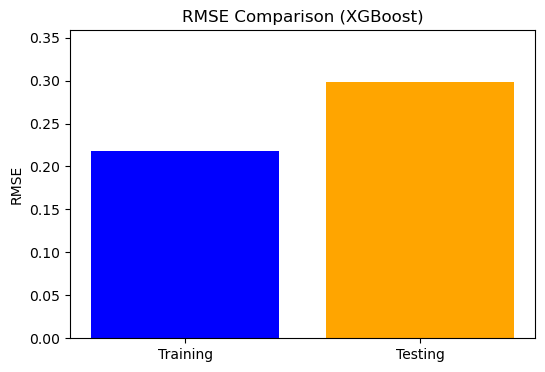

In [876]:
train_score, test_score = plot_model_scores(xg_boost, X_train, y_train, X_test, y_test, 'XGBoost')

In [862]:
X = seasonal_VAR.drop([target, 'time'], axis=1)
y = seasonal_VAR[target]

In [863]:
tscv = TimeSeriesSplit(n_splits=5)

rmse_values = []
mae_values = []
r2_values = []
fold_count = 0

actual_values = []
predicted_values = []

# Iterate over each fold
for train_index, test_index in tscv.split(X):
    # Create training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model =  XGBRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    actual_values.append(y_test)
    predicted_values.append(y_pred)

    # Evaluate the model
    rmse, mae, r2 = evaluate_model(y_pred, y_test)
    rmse_values.append(rmse)
    mae_values.append(mae)
    r2_values.append(r2)
    fold_count += 1
    print(f"Fold {fold_count}: RMSE = {rmse}, MAE = {mae}, R-squared = {r2}")

avg_rmse, avg_mae, avg_r2 = calculate_average_metrics(rmse_values, mae_values, r2_values)
print(f"Average RMSE: {avg_rmse:.4f}, Average MAE: {avg_mae:.4f}, Average R-squared: {avg_r2:.4f} ")

Fold 1: RMSE = 0.2388889856759314, MAE = 0.1623792344473349, R-squared = 0.8060642935364379
Fold 2: RMSE = 0.22826604512977253, MAE = 0.17378881282692488, R-squared = 0.8208143369450069
Fold 3: RMSE = 0.31194808348464426, MAE = 0.21018796544936513, R-squared = 0.6283271233612264
Fold 4: RMSE = 0.19191970487166668, MAE = 0.15654029093749, R-squared = 0.8663603829816972
Fold 5: RMSE = 0.24210588955424311, MAE = 0.17987188422431952, R-squared = 0.7966673152904927
Average RMSE: 0.2426, Average MAE: 0.1766, Average R-squared: 0.7836 


In [790]:
sorted_actual_values, sorted_predicted_values = combine_and_sort_actual_predicted(actual_values, predicted_values)

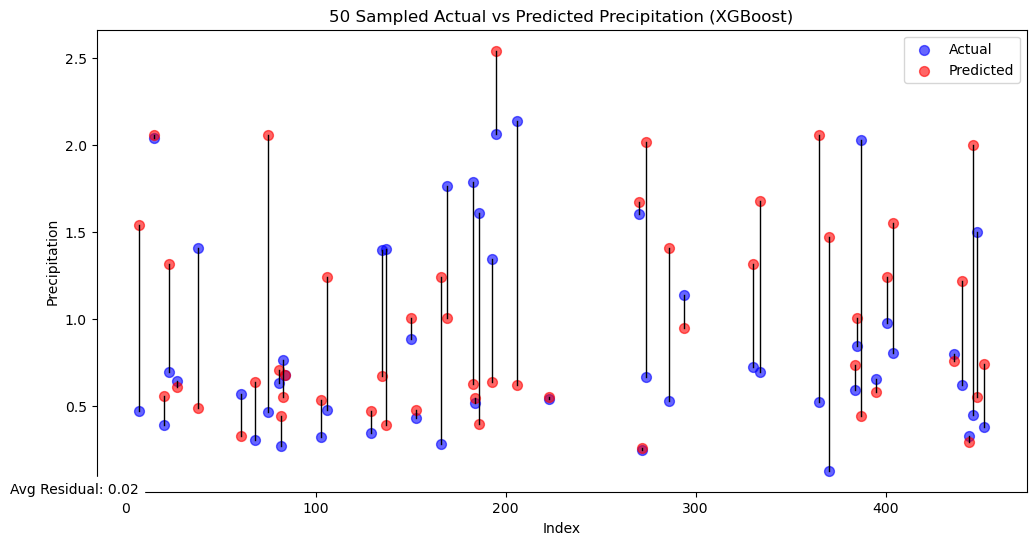

In [864]:
plot_sampled_predictions_actual_predicted(sorted_actual_values, sorted_predicted_values, 'XGBoost', 50)

### Time Series for Each Cluster

In [137]:
def evaluate_time_series(test, forecast, model):
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    r2 = r2_score(test, forecast)

    # print(f"{model}: RMSE = {rmse}, MAE = {mae}, R-squared = {r2}")

    return rmse, mae, r2

In [753]:
def plot_avg_actual_vs_forecast(avg_actual, avg_forecast, cluster_label, model_name = None):
    start_index = max(np.argmax(avg_actual != 0), np.argmax(avg_forecast != 0))
    end_index = min(len(avg_actual), len(avg_forecast))
    plt.figure(figsize=(12, 6))
    plt.plot(range(start_index, end_index), avg_actual[start_index:end_index], label='Average Actual')
    plt.plot(range(start_index, end_index), avg_forecast[start_index:end_index], label='Average Forecast')
    plt.title(f"Cluster {cluster_label}: Average Actual vs Forecast  {model_name}")
    plt.xlabel("Time")
    plt.ylabel("Precitation Change")
    plt.legend()
    plt.grid(True)
    plt.show()

## Data For Training

In [793]:
tscv = TimeSeriesSplit(n_splits=5)

In [520]:
# processed_cluster_data_diff = process_all_clusters(df_clusters_diff)

In [794]:
processed_cluster_data_diff = process_all_clusters(df_clusters)

In [511]:
# processed_cluster_data_diff = process_all_clusters(df_clusters_diff, resample_interval='D', resample_calculation='mean', clip=False)

In [553]:
df_clusters_diff_actual = process_all_clusters(df_clusters_diff, resample_interval='3M', resample_calculation='mean', clip=True)

In [795]:
processed_cluster_data_diff

precipitation  location_cluster
time                                       
1949-01-31       2.336560                 0
1949-04-30       8.168558                 0
1949-07-31       1.814433                 0
1949-10-31       2.792609                 0
1950-01-31      12.149178                 0
...                   ...               ...
1994-01-31       1.031269                 1
1994-04-30       1.281716                 1
1994-07-31       0.921031                 1
1994-10-31       0.456068                 1
1995-01-31       1.857986                 1

[555 rows x 2 columns]

In [761]:
def combine_and_sort_actual_forecast(actual_values, forecast_values):
    # Convert forecasts to Series if they are not already
    forecast_series = [pd.Series(forecast, index=actual.index) for forecast, actual in zip(forecast_values, actual_values)]

    # Concatenate all Series in the list
    combined_actual_values = pd.concat(actual_values)
    combined_forecast_values = pd.concat(forecast_series)

    return combined_actual_values, combined_forecast_values

In [762]:
def reverse_diff_and_clip_forecasts(forecasts, original_diff_data, resample_interval='3M'):
    reversed_forecasts = {}
    target = 'precipitation_diff' if 'precipitation_diff' in original_diff_data.columns else 'precipitation'
    
    # if 'time' not in original_diff_data.index.names:
    #     original_diff_data['time'] = pd.to_datetime(original_diff_data['time'])
    #     original_diff_data.set_index('time', inplace=True, drop=True)

    for cluster, data in forecasts.items():
        # Get the differenced values from the forecasts
        diff_values = data.values
        
        # Get the corresponding original data for the cluster and filter based on forecast index
        original_cluster_data = original_diff_data[original_diff_data['location_cluster'] == cluster]
        original_cluster_data = original_cluster_data[original_cluster_data.index.year.isin(data.index.year)]
        
        # Resample the original data to match the forecast index
        original_cluster_data = extract_process_cluster_data(original_cluster_data, cluster, clip=True)
        original_cluster_data_resampled = original_cluster_data[target].resample(resample_interval).mean()
        
        # # Align the time indices of the original data and the forecasts
        start_date = data.index[0]
        aligned_original_data = original_cluster_data_resampled.loc[start_date:]
        
        # # Reverse the differencing by adding the differenced values to the aligned original data
        reversed_data = aligned_original_data + diff_values
        
        # # Store the reversed data
        reversed_forecasts[cluster] = reversed_data
    
    return reversed_forecasts

### ARIMA

In [796]:
df_clusters_ARIMA = processed_cluster_data_diff
target = 'precipitation_diff' if 'precipitation_diff' in df_clusters_ARIMA.columns else 'precipitation'

In [797]:
cluster_order_map = {
    0: (2, 0, 2),
    1: (3, 0, 2),
    2: (3, 1, 2)
}

K-Fold Cross Validation ARIMA

c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 0, Fold 1: RMSE = 2.4658681756991685
Cluster 0, Fold 2: RMSE = 1.7976794609833657


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 0, Fold 3: RMSE = 2.414643899579199
Cluster 0, Fold 4: RMSE = 1.4709903629040508
Cluster 0, Fold 5: RMSE = 1.521003472518658


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


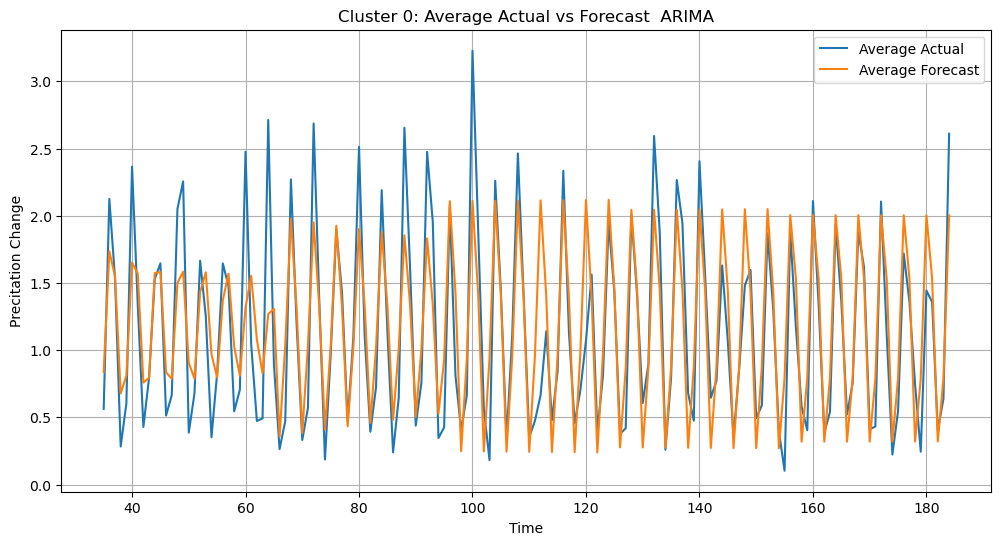

Cluster 0: Average RMSE = 1.9340, Average MAE = 1.4857, Average R-squared = 0.7080 

Cluster 1, Fold 1: RMSE = 0.4781955000639327


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Cluster 1, Fold 2: RMSE = 0.42594525162917096
Cluster 1, Fold 3: RMSE = 0.4739031003410203
Cluster 1, Fold 4: RMSE = 0.5561214339778842
Cluster 1, Fold 5: RMSE = 0.4646937911622488


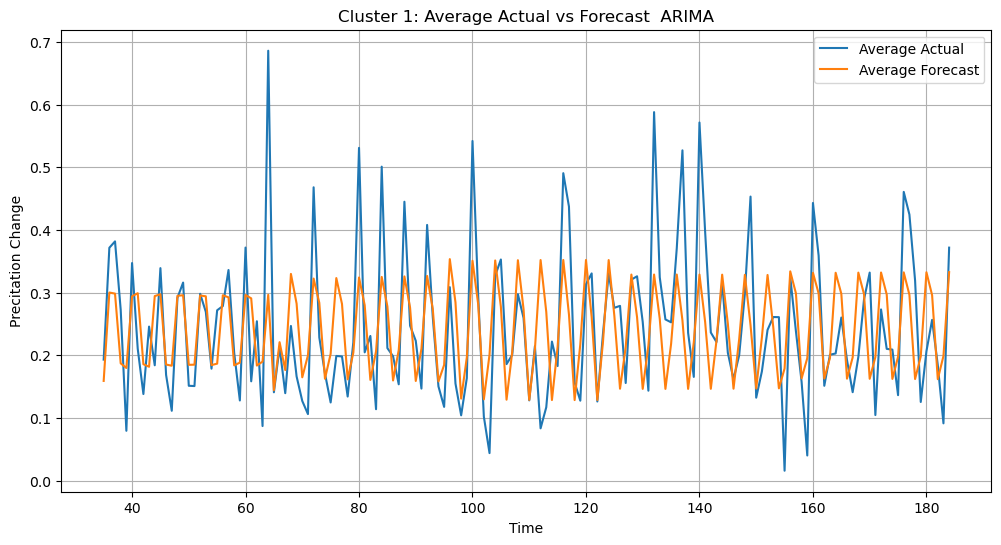

Cluster 1: Average RMSE = 0.4798, Average MAE = 0.3636, Average R-squared = 0.3243 

Cluster 2, Fold 1: RMSE = 0.9238360705893673
Cluster 2, Fold 2: RMSE = 0.7768284414933901
Cluster 2, Fold 3: RMSE = 1.5500907473268648
Cluster 2, Fold 4: RMSE = 0.9545113783787962
Cluster 2, Fold 5: RMSE = 0.7340783310960035


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


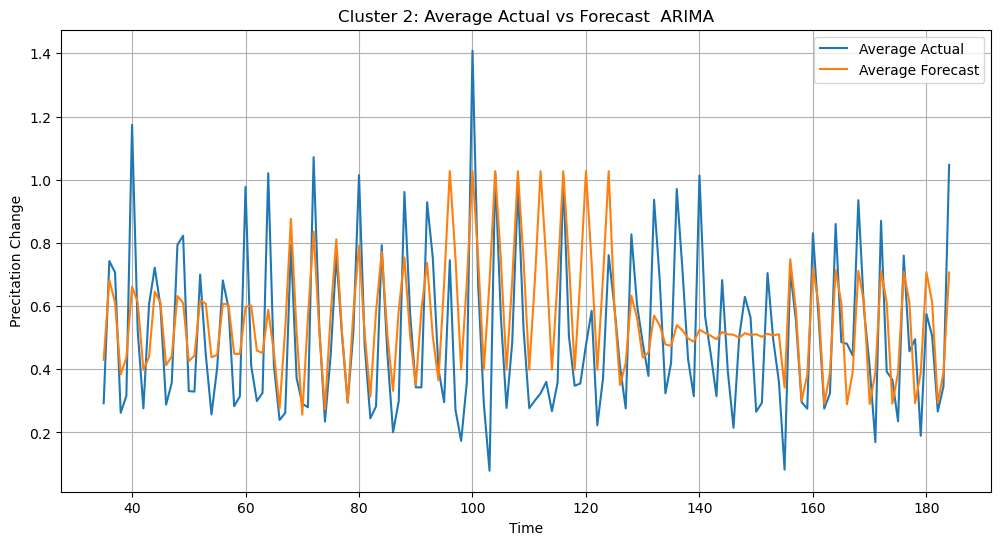

Cluster 2: Average RMSE = 0.9879, Average MAE = 0.7967, Average R-squared = 0.3614 



In [798]:
# Iterate over each cluster
for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    avg_rmse_values = []
    avg_mae_values = []
    avg_r2_values = []
    avg_actual_values = np.zeros(len(cluster_data))
    avg_forecast_values = np.zeros(len(cluster_data))
    fold_count = 0

    # Iterate over each fold of the time series cross-validation
    for fold_idx, (train_index, test_index) in enumerate(tscv.split(cluster_data), 1):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]

        # Fit ARIMA model
        order = cluster_order_map.get(cluster_label, (0, 0, 1))
        model = ARIMA(train[target], order=order)
        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(steps=len(test))

        # Evaluate
        rmse, mae, r2 = evaluate_time_series(test[target], forecast, f"ARIMA{order}")

        print(f"Cluster {cluster_label}, Fold {fold_idx}: RMSE = {rmse}")

        # Accumulate evaluation metrics
        avg_rmse_values.append(rmse)
        avg_mae_values.append(mae)
        avg_r2_values.append(r2)

        # Accumulate actual and forecast values for averaging
        avg_actual_values[test_index] += test[target].values
        avg_forecast_values[test_index] += forecast
        fold_count += 1

    # Average actual and forecast values
    avg_actual_values /= fold_count
    avg_forecast_values /= fold_count

    # Plot average actual vs forecast
    plot_avg_actual_vs_forecast(avg_actual_values, avg_forecast_values, cluster_label, 'ARIMA')
    

    # Calculate and print average evaluation metrics
    avg_rmse = np.mean(avg_rmse_values)
    avg_mae = np.mean(avg_mae_values)
    avg_r2 = np.mean(avg_r2_values)

    print(f"Cluster {cluster_label}: Average RMSE = {avg_rmse:.4f}, Average MAE = {avg_mae:.4f}, Average R-squared = {avg_r2:.4f} \n")

In [756]:
# Initialize dictionaries to store indexed results
cluster_actuals = {}
cluster_forecasts = {}

# Iterate over each cluster
for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    avg_rmse_values = []
    avg_mae_values = []
    avg_r2_values = []
    actual_values = []
    forecast_values = []
    
    # Iterate over each fold of the time series cross-validation
    for fold_idx, (train_index, test_index) in enumerate(tscv.split(cluster_data), 1):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]
        
        # Fit ARIMA model
        order = cluster_order_map.get(cluster_label, (0, 0, 1))
        model = ARIMA(train[target], order=order)
        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(steps=len(test))

        # Evaluate
        rmse, mae, r2 = evaluate_time_series(test[target], forecast, f"ARIMA{order}")
        print(f"Cluster {cluster_label}, Fold {fold_idx}: RMSE = {rmse}")

        actual_values.append(test)
        forecast_values.append(forecast)

        # Accumulate evaluation metrics
        avg_rmse_values.append(rmse)
        avg_mae_values.append(mae)
        avg_r2_values.append(r2)

    sorted_actual_values, sorted_forecast_values = combine_and_sort_actual_forecast(actual_values, forecast_values)

    # Concatenate results with indices preserved
    cluster_actuals[cluster_label] = sorted_actual_values
    cluster_forecasts[cluster_label] = sorted_forecast_values

    avg_rmse, avg_mae, avg_r2 = calculate_average_metrics(avg_rmse_values, avg_mae_values, avg_r2_values)
    print(f"Cluster {cluster_label}: Average RMSE = {avg_rmse:.4f}, Average MAE = {avg_mae:.4f}, Average R-squared = {avg_r2:.4f} \n")

c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 0, Fold 1: RMSE = 0.4415659702870426
Cluster 0, Fold 2: RMSE = 0.42799568040370367
Cluster 0, Fold 3: RMSE = 0.4314803244805159


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 0, Fold 4: RMSE = 0.25977820812705


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Cluster 0, Fold 5: RMSE = 0.2988972706820973
Cluster 0: Average RMSE = 0.3719, Average MAE = 0.2901, Average R-squared = 0.6869 

Cluster 1, Fold 1: RMSE = 0.15396462561018034


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 1, Fold 2: RMSE = 0.16960552076479843
Cluster 1, Fold 3: RMSE = 0.17145280662177162


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 1, Fold 4: RMSE = 0.1911405415350794
Cluster 1, Fold 5: RMSE = 0.16318393008647347
Cluster 1: Average RMSE = 0.1699, Average MAE = 0.1288, Average R-squared = 0.3192 

Cluster 2, Fold 1: RMSE = 0.3397748834117824


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 2, Fold 2: RMSE = 0.24012539630112817
Cluster 2, Fold 3: RMSE = 0.6322072658208109
Cluster 2, Fold 4: RMSE = 0.2796303657206449
Cluster 2, Fold 5: RMSE = 0.2659378154887488
Cluster 2: Average RMSE = 0.3515, Average MAE = 0.2965, Average R-squared = 0.2568 



c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [614]:
reversed_data = reverse_diff_and_clip_forecasts(cluster_forecasts, df_clusters_diff_actual)

In [615]:
df_clusters_diff_actual[df_clusters_diff_actual.index.year > 1957]

precipitation_diff  location_cluster
time                                            
1958-01-31            1.384597                 2
1958-04-30            1.257481                 2
1958-07-31            0.566676                 2
1958-10-31            0.693092                 2
1959-01-31            2.073513                 2
...                        ...               ...
1994-01-31            1.504442                 0
1994-04-30            1.494714                 0
1994-07-31            0.512250                 0
1994-10-31            0.654943                 0
1995-01-31            2.749879                 0

[447 rows x 2 columns]

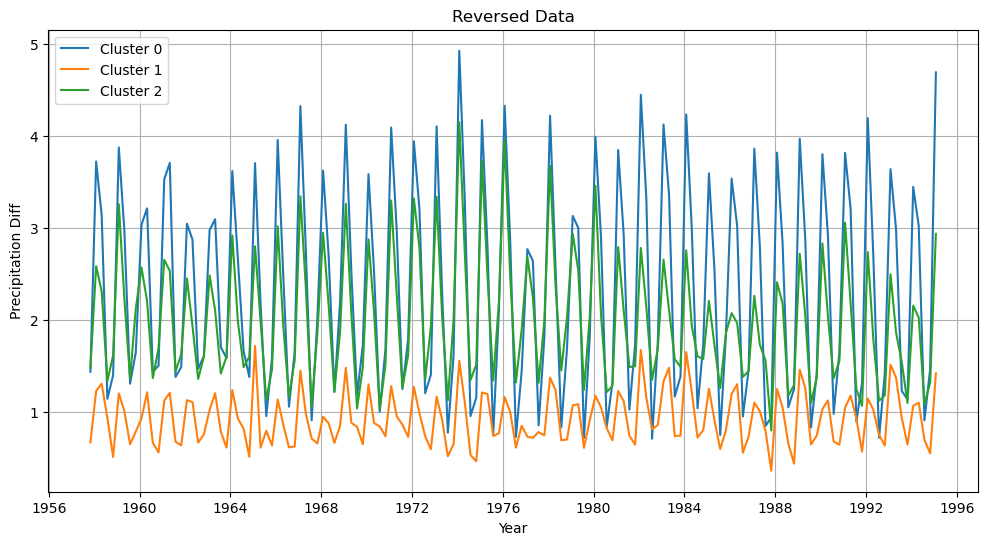

In [616]:
df = pd.DataFrame(reversed_data)

# Plot the data
plt.figure(figsize=(12, 6))
for column in df.columns:
    plt.plot(df.index, df[column], label=f'Cluster {column}')

plt.xlabel('Year')
plt.ylabel('Precipitation Diff')
plt.title('Reversed Data (ARIMA)')
plt.legend()
plt.grid(True)
plt.show()

In [617]:
def plot_cluster_data(cluster_actuals, cluster_forecasts, cluster_labels):
    num_clusters = len(cluster_labels)
    plt.figure(figsize=(15, num_clusters * 5))

    for i, cluster_label in enumerate(cluster_labels):
        plt.subplot(num_clusters, 1, i + 1)  # Creates a subplot for each cluster
        plt.plot(cluster_actuals[cluster_label]['precipitation_diff'], label='Actual', marker='o', linestyle='-', markersize=5)
        plt.plot(cluster_forecasts[cluster_label], label='Forecasted', marker='x', linestyle='--', markersize=5)
        plt.title(f'Actual vs Forecasted for Cluster {cluster_label}')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

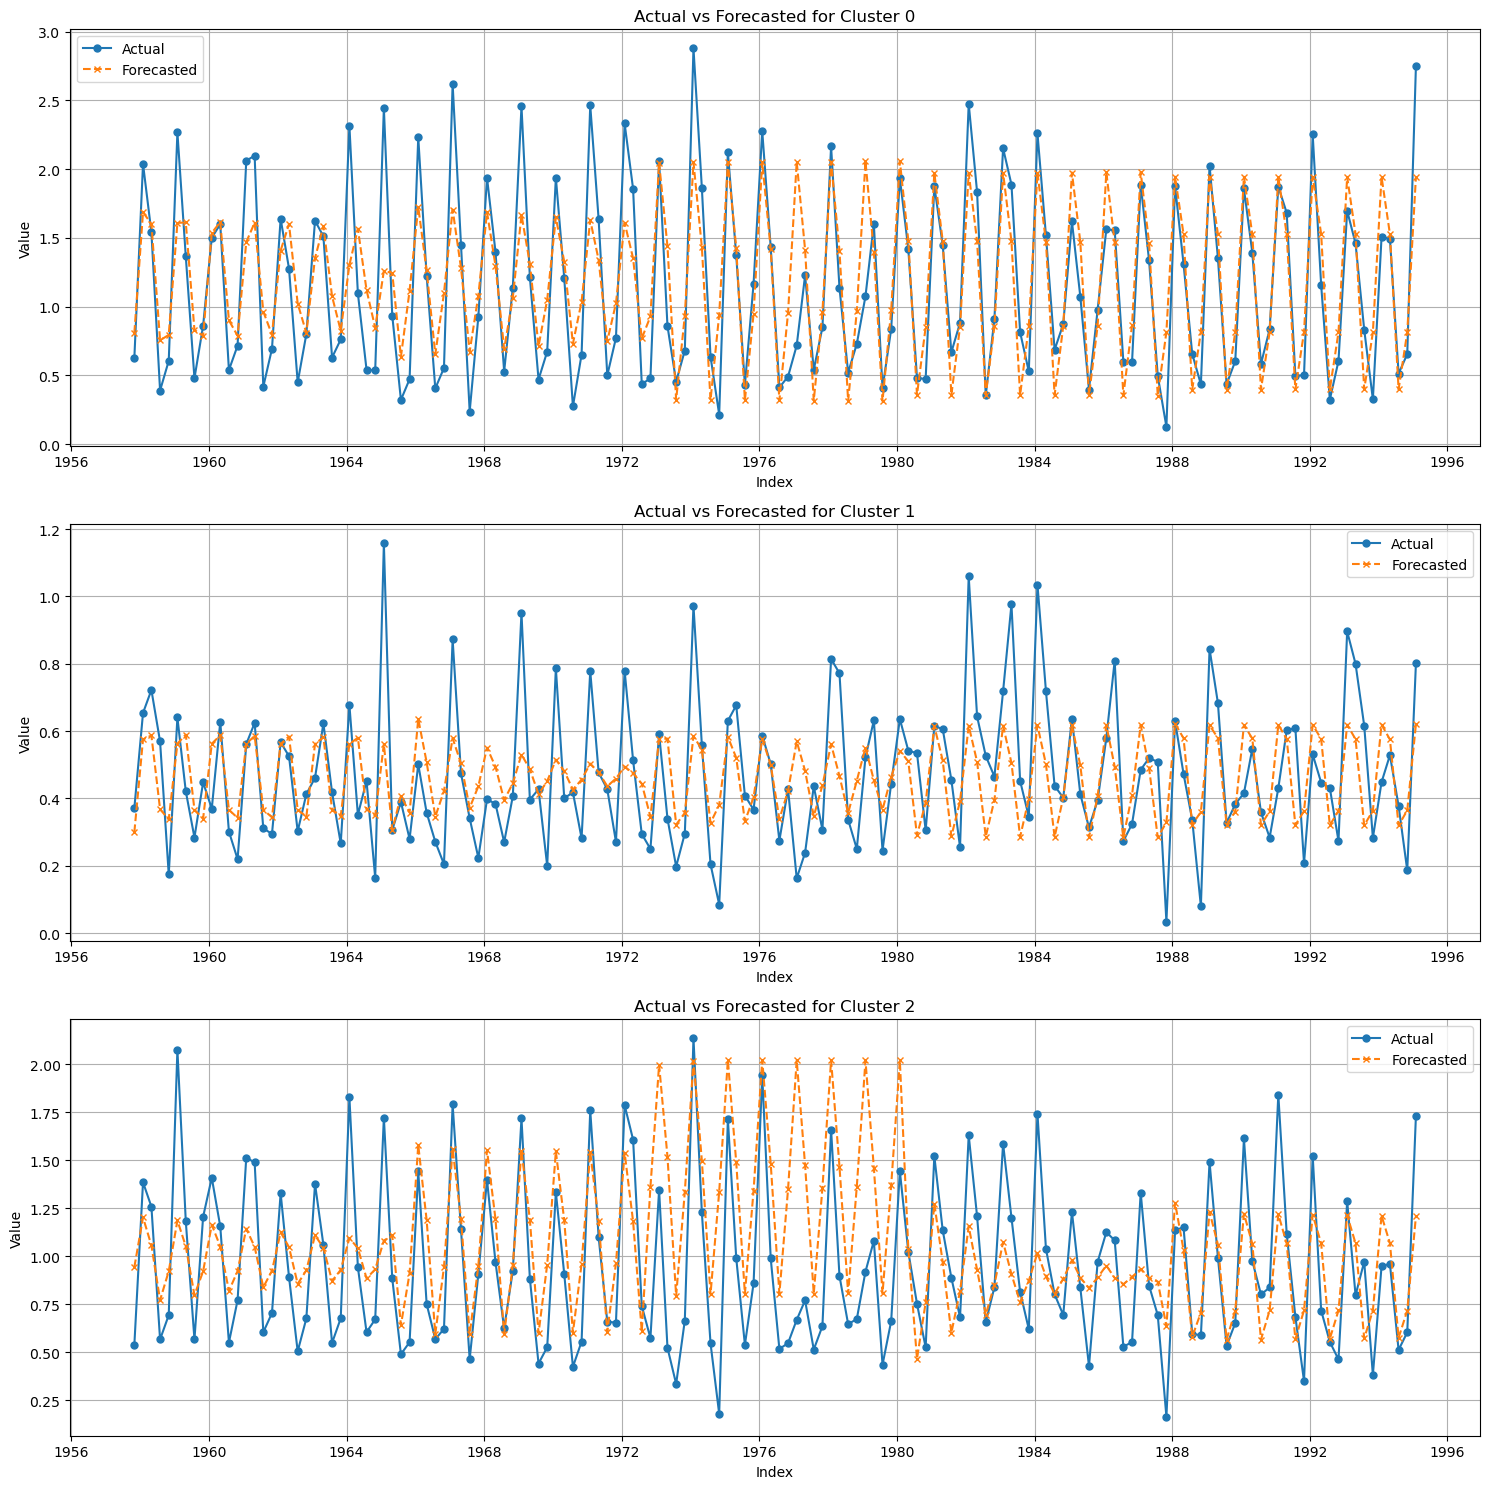

In [757]:
cluster_labels = list(cluster_actuals.keys())
plot_cluster_data(cluster_actuals, cluster_forecasts, cluster_labels)

Hyperparameters Tuning ARIMA

In [319]:
# Define the ranges for the parameters
p = range(0, 3) # AR orders
d = range(0, 3) # Differencing order (I)
q = range(0, 3) # MA orders

# Create a list of all parameter combinations
param_combinations = list(itertools.product(p, d, q))

Tuning (AIC)

In [321]:
tscv = TimeSeriesSplit(n_splits=5)

for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    best_aic = float("inf")
    best_order = None
    avg_aic_values = []  # List to store AIC values within the same fold

    for train_index, test_index in tscv.split(cluster_data):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]

        for param in param_combinations:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
                warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.")
                warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")
                try:
                    # Fit ARIMA model
                    model = ARIMA(train[target], order=param)
                    model_fit = model.fit()

                    # Calculate AIC (Akaike Information Criterion)
                    aic = model_fit.aic
                    avg_aic_values.append(aic)  # Append AIC for this parameter combination

                    # Update best parameters if current model has lower AIC
                    if aic < best_aic:
                        best_aic = aic
                        best_order = param

                except Exception as e:
                    print(f"Error fitting model for parameters {param} in cluster {cluster_label}: {e}")

    # Calculate average AIC across all folds
    avg_aic_fold = np.mean(avg_aic_values)

    print(f"Cluster {cluster_label}:")
    print("  Best ARIMA order:", best_order)
    print("  Average AIC across all folds:", avg_aic_fold)

    # Update results CSV
    update_results_csv(cluster_label, 'ARIMA with Differencing', best_order, 'AIC', best_aic)

Cluster 0:
  Best ARIMA order: (2, 0, 2)
  Average AIC across all folds: 300.6883843817068
Cluster 1:
  Best ARIMA order: (2, 0, 2)
  Average AIC across all folds: 35.02237601391839
Cluster 2:
  Best ARIMA order: (2, 0, 2)
  Average AIC across all folds: 150.54732375367894


Tuning ARIMA (RMSE)

In [320]:
tscv = TimeSeriesSplit(n_splits=5)

for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    best_rmse = float("inf")
    best_order = None
    avg_rmse_values = []  # List to store RMSE values within the same fold

    for train_index, test_index in tscv.split(cluster_data):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]

        for param in param_combinations:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
                warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.")
                warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")
                try:
                    model = ARIMA(train[target], order=param)
                    model_fit = model.fit()

                    # Make predictions
                    predictions = model_fit.forecast(len(test))

                    # Calculate RMSE
                    rmse = np.sqrt(mean_squared_error(test[target], predictions))
                    avg_rmse_values.append(rmse)  # Append RMSE for this parameter combination

                    # Update best parameters if current model has lower RMSE
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_order = param

                except Exception as e:
                    print(f"Error fitting model for parameters {param} in cluster {cluster_label}: {e}")

    # Calculate average RMSE across all folds
    avg_rmse_fold = np.mean(avg_rmse_values)

    print(f"Cluster {cluster_label}:")
    print("  Best ARIMA order:", best_order)
    print("  Average RMSE across all folds:", avg_rmse_fold)

    # Update results CSV
    update_results_csv(cluster_label, 'ARIMA With Differencing', best_order, 'RMSE', best_rmse)

Cluster 0:
  Best ARIMA order: (2, 0, 2)
  Average RMSE across all folds: 4.0500200578218175
Cluster 1:
  Best ARIMA order: (2, 0, 2)
  Average RMSE across all folds: 0.6579367417439753
Cluster 2:
  Best ARIMA order: (2, 0, 2)
  Average RMSE across all folds: 1.4350541696844596


### SARIMA

In [799]:
cluster_order_map_sarima = {
    0: ((1, 1, 1), (1, 0, 1, 4)),
    1: ((2, 0, 0), (1, 1, 1, 4)),
    2: ((2, 0, 2), (1, 1, 1, 4))
}

c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Cluster 0, Fold 1: RMSE = 1.4825453973808036
Cluster 0, Fold 2: RMSE = 1.3939244070138557


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Cluster 0, Fold 3: RMSE = 2.357579498506292


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Cluster 0, Fold 4: RMSE = 1.348191481949138
Cluster 0, Fold 5: RMSE = 1.3118987584243418


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


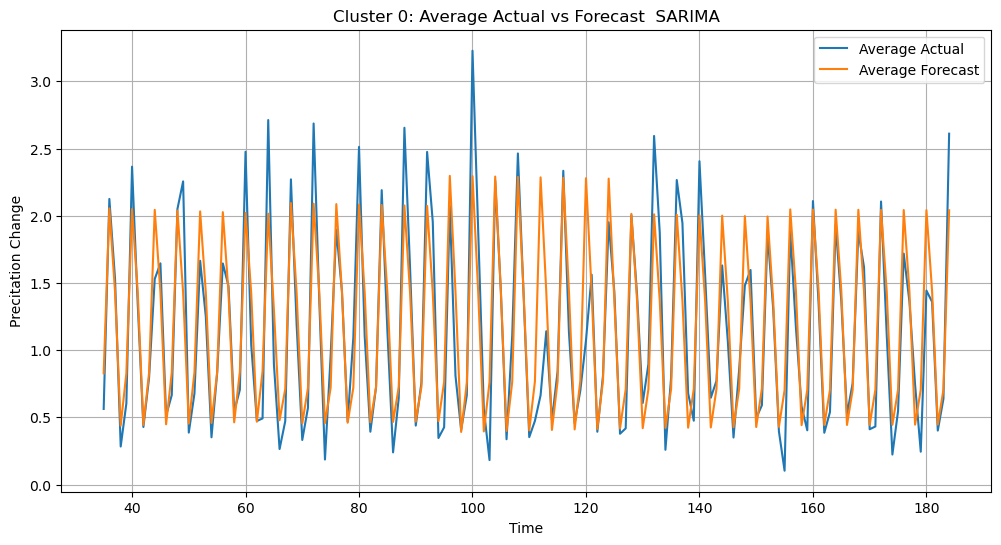

Cluster 0: Average RMSE = 1.5788, Average MAE = 1.1462, Average R-squared = 0.8043 

Cluster 1, Fold 1: RMSE = 0.4913591720832057
Cluster 1, Fold 2: RMSE = 0.3881410292747477
Cluster 1, Fold 3: RMSE = 0.5142107304215349
Cluster 1, Fold 4: RMSE = 0.5114637493827955
Cluster 1, Fold 5: RMSE = 0.4510452963564934


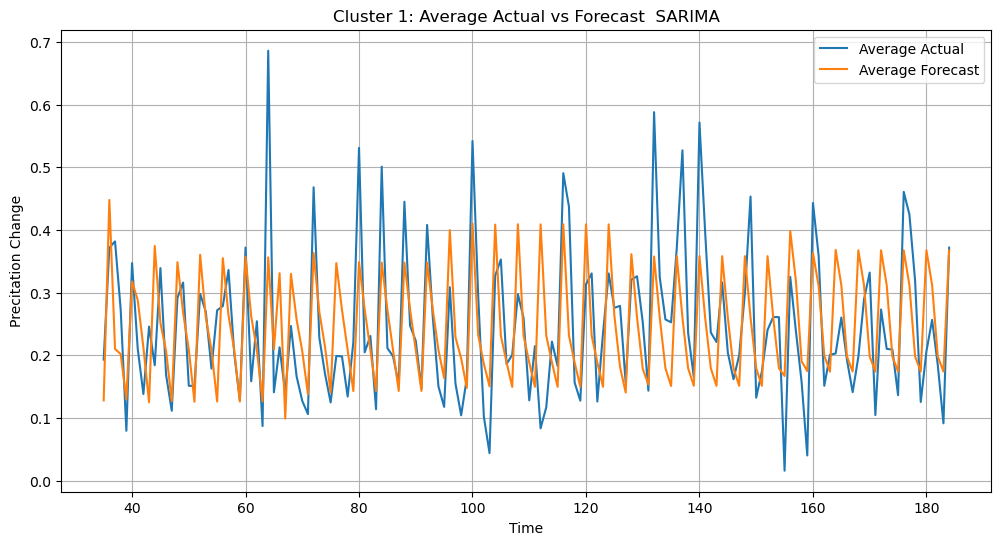

Cluster 1: Average RMSE = 0.4712, Average MAE = 0.3718, Average R-squared = 0.3492 

Cluster 2, Fold 1: RMSE = 0.7220389604067179


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 2, Fold 2: RMSE = 0.5406623413595082


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 2, Fold 3: RMSE = 0.9649594850642942


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 2, Fold 4: RMSE = 0.5635839324426605
Cluster 2, Fold 5: RMSE = 0.5971241445058053


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


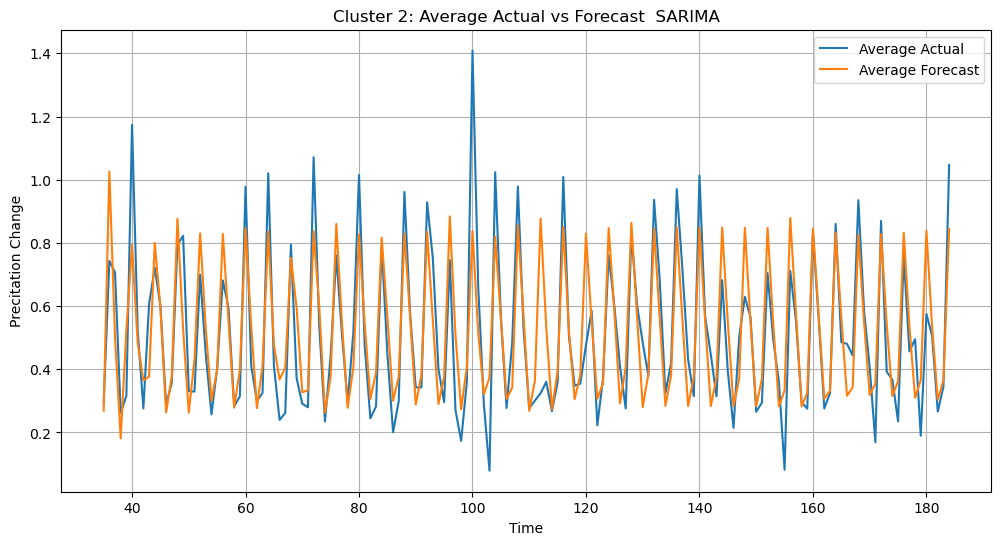

Cluster 2: Average RMSE = 0.6777, Average MAE = 0.5172, Average R-squared = 0.7073 



In [800]:
# Iterate over each cluster
for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    avg_rmse_values = []
    avg_mae_values = []
    avg_r2_values = []
    avg_actual_values = np.zeros(len(cluster_data))
    avg_forecast_values = np.zeros(len(cluster_data))
    fold_count = 0

    order, seasonal_order = cluster_order_map_sarima.get(cluster_label, ((1, 1, 1), (1, 1, 1, 4)))

    # Iterate over each fold of the time series cross-validation
    for fold_idx, (train_index, test_index) in enumerate(tscv.split(cluster_data), 1):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]
        model = SARIMAX(train[target], order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(steps=len(test))

        # Evaluate
        rmse, mae, r2 = evaluate_time_series(test[target], forecast, f"SARIMA{order}")

        print(f"Cluster {cluster_label}, Fold {fold_idx}: RMSE = {rmse}")

        # Accumulate evaluation metrics
        avg_rmse_values.append(rmse)
        avg_mae_values.append(mae)
        avg_r2_values.append(r2)

        # Accumulate actual and forecast values for averaging
        avg_actual_values[test_index] += test[target].values
        avg_forecast_values[test_index] += forecast
        fold_count += 1

    # Average actual and forecast values
    avg_actual_values /= fold_count
    avg_forecast_values /= fold_count

    # Plot average actual vs forecast
    plot_avg_actual_vs_forecast(avg_actual_values, avg_forecast_values, cluster_label, 'SARIMA')

    # Calculate and print average evaluation metrics
    avg_rmse = np.mean(avg_rmse_values)
    avg_mae = np.mean(avg_mae_values)
    avg_r2 = np.mean(avg_r2_values)

    print(f"Cluster {cluster_label}: Average RMSE = {avg_rmse:.4f}, Average MAE = {avg_mae:.4f}, Average R-squared = {avg_r2:.4f} \n")

In [685]:
# Initialize dictionaries to store indexed results
cluster_actuals = {}
cluster_forecasts = {}

# Iterate over each cluster
for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    avg_rmse_values = []
    avg_mae_values = []
    avg_r2_values = []
    actual_values = []
    forecast_values = []

    order, seasonal_order = cluster_order_map_sarima.get(cluster_label, ((1, 1, 1), (1, 1, 1, 4)))

    
    # Iterate over each fold of the time series cross-validation
    for fold_idx, (train_index, test_index) in enumerate(tscv.split(cluster_data), 1):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]

        model = SARIMAX(train[target], order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(steps=len(test))

        # Evaluate
        rmse, mae, r2 = evaluate_time_series(test[target], forecast, f"SARIMA{order}")
        print(f"Cluster {cluster_label}, Fold {fold_idx}: RMSE = {rmse}")

        actual_values.append(test)
        forecast_values.append(forecast)

        # Accumulate evaluation metrics
        avg_rmse_values.append(rmse)
        avg_mae_values.append(mae)
        avg_r2_values.append(r2)

    sorted_actual_values, sorted_forecast_values = combine_and_sort_actual_forecast(actual_values, forecast_values)

    # Concatenate results with indices preserved
    cluster_actuals[cluster_label] = sorted_actual_values
    cluster_forecasts[cluster_label] = sorted_forecast_values

    avg_rmse, avg_mae, avg_r2 = calculate_average_metrics(avg_rmse_values, avg_mae_values, avg_r2_values)
    print(f"Cluster {cluster_label}: Average RMSE = {avg_rmse:.4f}, Average MAE = {avg_mae:.4f}, Average R-squared = {avg_r2:.4f} \n")

c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Cluster 0, Fold 1: RMSE = 0.24207660951634347


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Cluster 0, Fold 2: RMSE = 0.2610039194995669
Cluster 0, Fold 3: RMSE = 0.4189895185832118


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Cluster 0, Fold 4: RMSE = 0.2462771215370723


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 0, Fold 5: RMSE = 0.2726809839888221
Cluster 0: Average RMSE = 0.2882, Average MAE = 0.2085, Average R-squared = 0.8081 

Cluster 1, Fold 1: RMSE = 0.16070770710087626
Cluster 1, Fold 2: RMSE = 0.12947533390557353
Cluster 1, Fold 3: RMSE = 0.17490088526368894
Cluster 1, Fold 4: RMSE = 0.17563463540921023
Cluster 1, Fold 5: RMSE = 0.1504668021374557
Cluster 1: Average RMSE = 0.1582, Average MAE = 0.1254, Average R-squared = 0.4083 



c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 2, Fold 1: RMSE = 0.21339248781837739


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 2, Fold 2: RMSE = 0.19438551253695036


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 2, Fold 3: RMSE = 0.32177378041477206
Cluster 2, Fold 4: RMSE = 0.1812045290475048
Cluster 2, Fold 5: RMSE = 0.2421007292086666
Cluster 2: Average RMSE = 0.2306, Average MAE = 0.1732, Average R-squared = 0.7008 



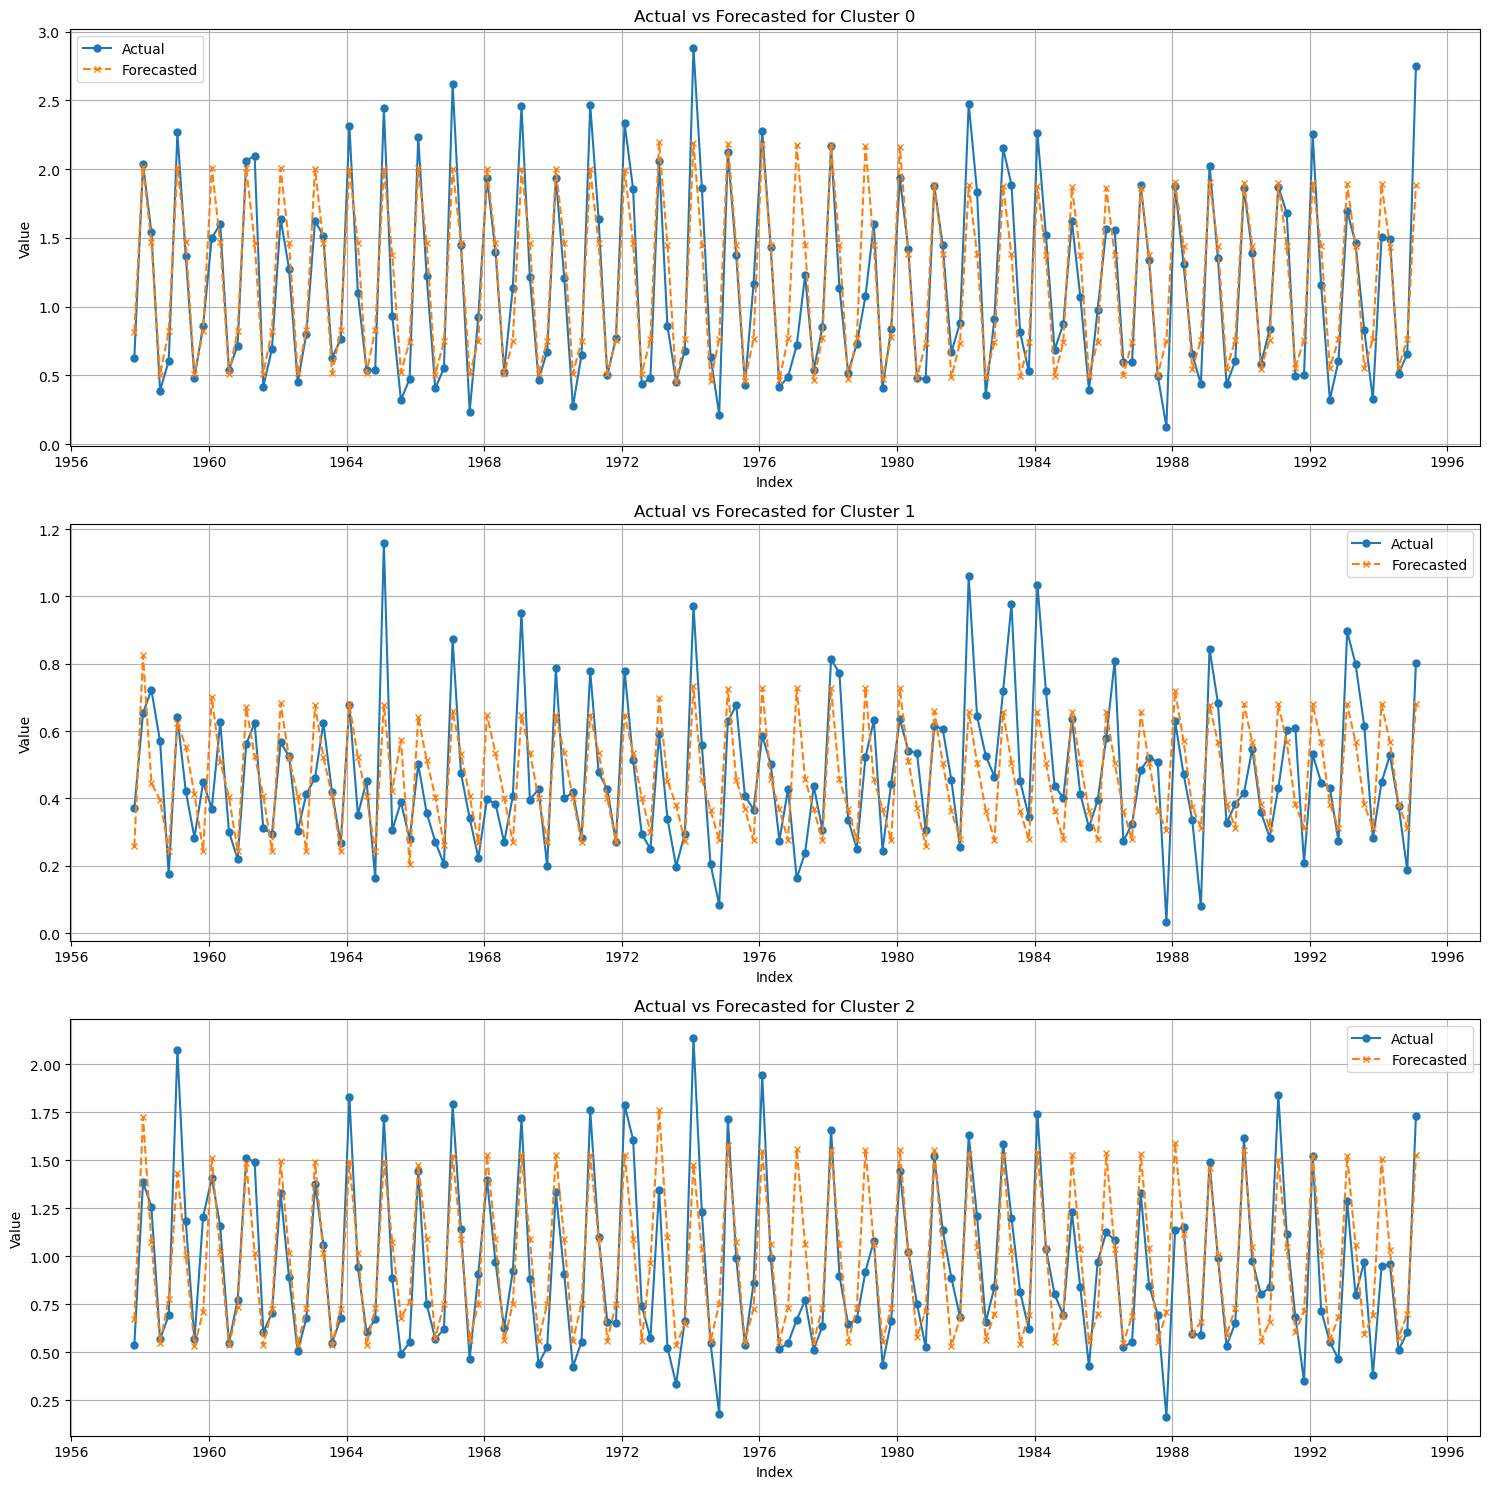

In [686]:
cluster_labels = list(cluster_actuals.keys())
plot_cluster_data(cluster_actuals, cluster_forecasts, cluster_labels)

### Hyperparameters Tuning SARIMA

In [313]:
# Define the ranges for the parameters
p = range(1, 3) # AR
d = range(0, 3) # I
q = range(1, 3) # MA
P = D = Q = range(1, 2)  # Seasonal AR, I, MA
s = 4  # Seasonal period (quarterly seasonality)

# Create a list of all parameter combinations
param_combinations = list(itertools.product(p, d, q, P, D, Q))

AIC

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None

    for train_index, test_index in tscv.split(cluster_data):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]
        avg_aic_values = []

        for param in param_combinations:
            seasonal_order = param[3:6]  # Unpack the seasonal order (P, D, Q)

            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
                warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")
                try:
                    # Fit SARIMA model
                    model = SARIMAX(train[target], order=param[:3], seasonal_order=seasonal_order + (s,))
                    model_fit = model.fit()

                    # Calculate AIC
                    aic = model_fit.aic
                    avg_aic_values.append(aic)  # Append AIC for this parameter combination

                except Exception as e:
                    print(f"Error fitting model for parameters {param} in cluster {cluster_label}: {e}")

        # Calculate average AIC within the same fold
        avg_aic_fold = np.mean(avg_aic_values)
        # print(f"Cluster {cluster_label}, Fold {fold_count}: Average AIC within fold = {avg_aic_fold}")

        # Update best parameters if current model has lower AIC
        if avg_aic_fold < best_aic:
            best_aic = avg_aic_fold
            best_order = param[:3]
            best_seasonal_order = seasonal_order

    print(f"Cluster {cluster_label}:")
    print("  Best SARIMA order:", best_order)
    print("  Best SARIMA seasonal order:", best_seasonal_order)
    print("  Average AIC across all folds:", best_aic)

    # Update results CSV
    update_results_csv(cluster_label, 'SARIMA With Differencing', best_order + best_seasonal_order + (s,), 'AIC', best_aic)

RMSE

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    best_rmse = float("inf")
    best_order = None
    best_seasonal_order = None

    for train_index, test_index in tscv.split(cluster_data):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]
        avg_rmse_values = []

        for param in param_combinations:
            seasonal_order = param[3:6]  # Unpack the seasonal order (P, D, Q)

            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
                warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.")
                warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")
                try:
                    # Fit SARIMA model
                    model = SARIMAX(train[target], order=param[:3], seasonal_order=seasonal_order + (s,))
                    model_fit = model.fit()

                    # Make predictions
                    predictions = model_fit.forecast(len(test))  # Forecast for the test set

                    # Calculate RMSE
                    rmse = np.sqrt(mean_squared_error(test[target], predictions))
                    avg_rmse_values.append(rmse)  # Append RMSE for this parameter combination

                except Exception as e:
                    print(f"Error fitting model for parameters {param} in cluster {cluster_label}: {e}")

        # Calculate average RMSE within the same fold
        avg_rmse_fold = np.mean(avg_rmse_values)
        # print(f"Cluster {cluster_label}, Fold {fold_count}: Average RMSE within fold = {avg_rmse_fold}")

        # Update best parameters if current model has lower RMSE
        if avg_rmse_fold < best_rmse:
            best_rmse = avg_rmse_fold
            best_order = param[:3]
            best_seasonal_order = seasonal_order

    print(f"Cluster {cluster_label}:")
    print("  Best SARIMA order:", best_order)
    print("  Best SARIMA seasonal order:", best_seasonal_order)
    print("  Average RMSE across all folds:", best_rmse)

    # Update results CSV
    update_results_csv(cluster_label, 'SARIMA With Diffencing', best_order + best_seasonal_order + (s,), 'RMSE', best_rmse)

### Exponential Smoothing (HOLT WINTER)

Cluster 0, Fold 1: RMSE = 1.6749543811388703
Cluster 0, Fold 2: RMSE = 1.4139293148732137
Cluster 0, Fold 3: RMSE = 2.3552338667744235
Cluster 0, Fold 4: RMSE = 1.3673299007563608
Cluster 0, Fold 5: RMSE = 1.3399073947696836


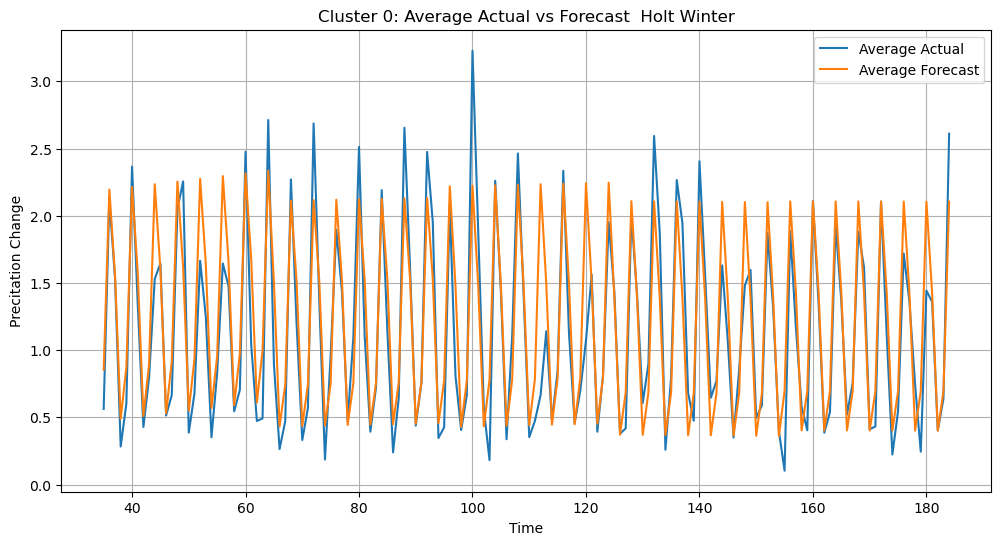

Cluster 0: Average RMSE = 1.6303, Average MAE = 1.2106, Average R-squared = 0.7922 

Cluster 1, Fold 1: RMSE = 0.558619436292242
Cluster 1, Fold 2: RMSE = 0.4547043179238554
Cluster 1, Fold 3: RMSE = 0.4877612484803055
Cluster 1, Fold 4: RMSE = 0.507023571441422
Cluster 1, Fold 5: RMSE = 0.4728908938212616


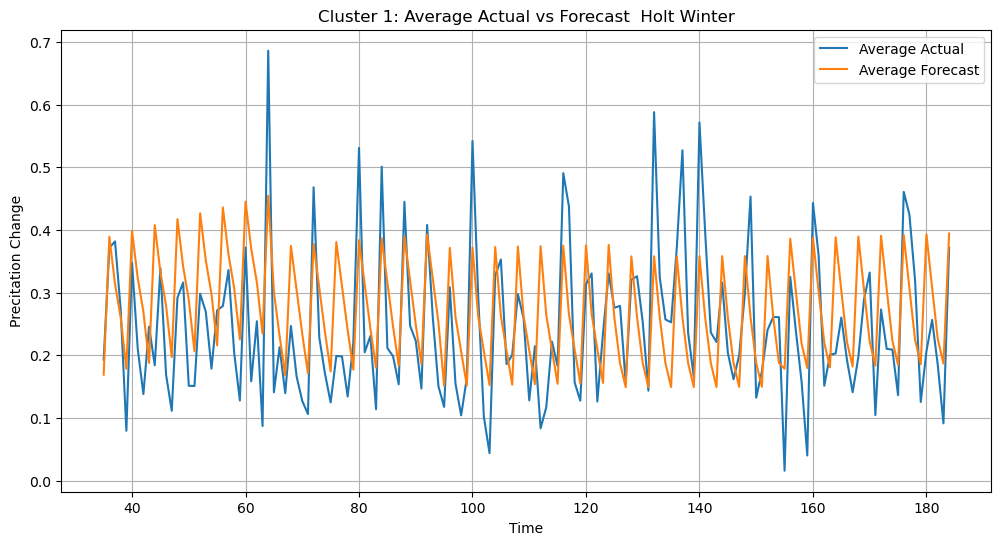

Cluster 1: Average RMSE = 0.4962, Average MAE = 0.4073, Average R-squared = 0.2802 

Cluster 2, Fold 1: RMSE = 0.6604253184703209
Cluster 2, Fold 2: RMSE = 0.5506106884343916
Cluster 2, Fold 3: RMSE = 0.9608980428808908
Cluster 2, Fold 4: RMSE = 0.589548485080258
Cluster 2, Fold 5: RMSE = 0.6076421229060638


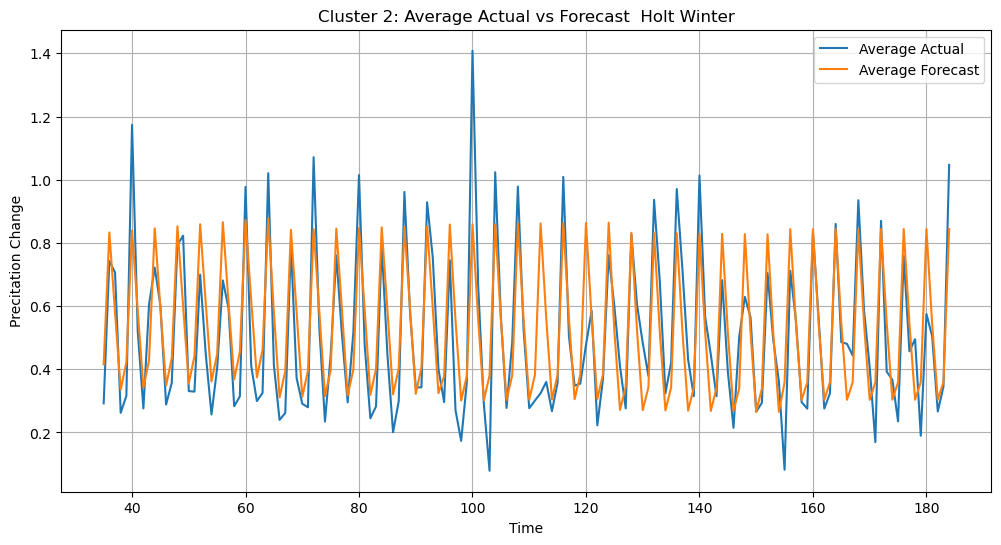

Cluster 2: Average RMSE = 0.6738, Average MAE = 0.5321, Average R-squared = 0.7104 



In [801]:
for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):

    avg_rmse_values = []
    avg_mae_values = []
    avg_r2_values = []
    avg_actual_values = np.zeros(len(cluster_data))
    avg_forecast_values = np.zeros(len(cluster_data))
    fold_count = 0

    # Iterate over each fold of the time series cross-validation
    for fold_idx, (train_index, test_index) in enumerate(tscv.split(cluster_data), 1):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]

        # Fit Holt-Winters model
        model = ExponentialSmoothing(train[target], trend='add',seasonal='add', seasonal_periods=4)
        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(len(test))

        # Evaluate
        rmse, mae, r2 = evaluate_time_series(test[target], forecast, f"Holt Winter")

        print(f"Cluster {cluster_label}, Fold {fold_idx}: RMSE = {rmse}")

        # Accumulate evaluation metrics
        avg_rmse_values.append(rmse)
        avg_mae_values.append(mae)
        avg_r2_values.append(r2)

        # Accumulate actual and forecast values for averaging
        avg_actual_values[test_index] += test[target].values
        avg_forecast_values[test_index] += forecast
        fold_count += 1

    # Average actual and forecast values
    avg_actual_values /= fold_count
    avg_forecast_values /= fold_count

    # Plot average actual vs forecast
    plot_avg_actual_vs_forecast(avg_actual_values, avg_forecast_values, cluster_label, 'Holt Winter')

    # Calculate and print average evaluation metrics
    avg_rmse = np.mean(avg_rmse_values)
    avg_mae = np.mean(avg_mae_values)
    avg_r2 = np.mean(avg_r2_values)

    print(f"Cluster {cluster_label}: Average RMSE = {avg_rmse:.4f}, Average MAE = {avg_mae:.4f}, Average R-squared = {avg_r2:.4f} \n")

In [687]:
# Initialize dictionaries to store indexed results
cluster_actuals = {}
cluster_forecasts = {}

# Iterate over each cluster
for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    avg_rmse_values = []
    avg_mae_values = []
    avg_r2_values = []
    actual_values = []
    forecast_values = []

    order, seasonal_order = cluster_order_map_sarima.get(cluster_label, ((1, 1, 1), (1, 1, 1, 4)))

    
    # Iterate over each fold of the time series cross-validation
    for fold_idx, (train_index, test_index) in enumerate(tscv.split(cluster_data), 1):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]

        model = ExponentialSmoothing(train[target], trend='add',seasonal='add', seasonal_periods=4)
        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(steps=len(test))

        # Evaluate
        rmse, mae, r2 = evaluate_time_series(test[target], forecast, f"Holt Winter{order}")
        print(f"Cluster {cluster_label}, Fold {fold_idx}: RMSE = {rmse}")

        actual_values.append(test)
        forecast_values.append(forecast)

        # Accumulate evaluation metrics
        avg_rmse_values.append(rmse)
        avg_mae_values.append(mae)
        avg_r2_values.append(r2)

    sorted_actual_values, sorted_forecast_values = combine_and_sort_actual_forecast(actual_values, forecast_values)

    # Concatenate results with indices preserved
    cluster_actuals[cluster_label] = sorted_actual_values
    cluster_forecasts[cluster_label] = sorted_forecast_values

    avg_rmse, avg_mae, avg_r2 = calculate_average_metrics(avg_rmse_values, avg_mae_values, avg_r2_values)
    print(f"Cluster {cluster_label}: Average RMSE = {avg_rmse:.4f}, Average MAE = {avg_mae:.4f}, Average R-squared = {avg_r2:.4f} \n")

Cluster 0, Fold 1: RMSE = 0.28799105459570656
Cluster 0, Fold 2: RMSE = 0.2613032673342827
Cluster 0, Fold 3: RMSE = 0.4156856847986269
Cluster 0, Fold 4: RMSE = 0.25261904899465853
Cluster 0, Fold 5: RMSE = 0.2631775339737029
Cluster 0: Average RMSE = 0.2962, Average MAE = 0.2199, Average R-squared = 0.7983 

Cluster 1, Fold 1: RMSE = 0.19092141582259708
Cluster 1, Fold 2: RMSE = 0.1436577105638359
Cluster 1, Fold 3: RMSE = 0.16694291805688496
Cluster 1, Fold 4: RMSE = 0.18035676896681996
Cluster 1, Fold 5: RMSE = 0.15586705716724802
Cluster 1: Average RMSE = 0.1675, Average MAE = 0.1361, Average R-squared = 0.3336 

Cluster 2, Fold 1: RMSE = 0.23869612220137706
Cluster 2, Fold 2: RMSE = 0.2092804928579498
Cluster 2, Fold 3: RMSE = 0.31165893576192194
Cluster 2, Fold 4: RMSE = 0.19233987095358795
Cluster 2, Fold 5: RMSE = 0.2310836106975331
Cluster 2: Average RMSE = 0.2366, Average MAE = 0.1920, Average R-squared = 0.6871 



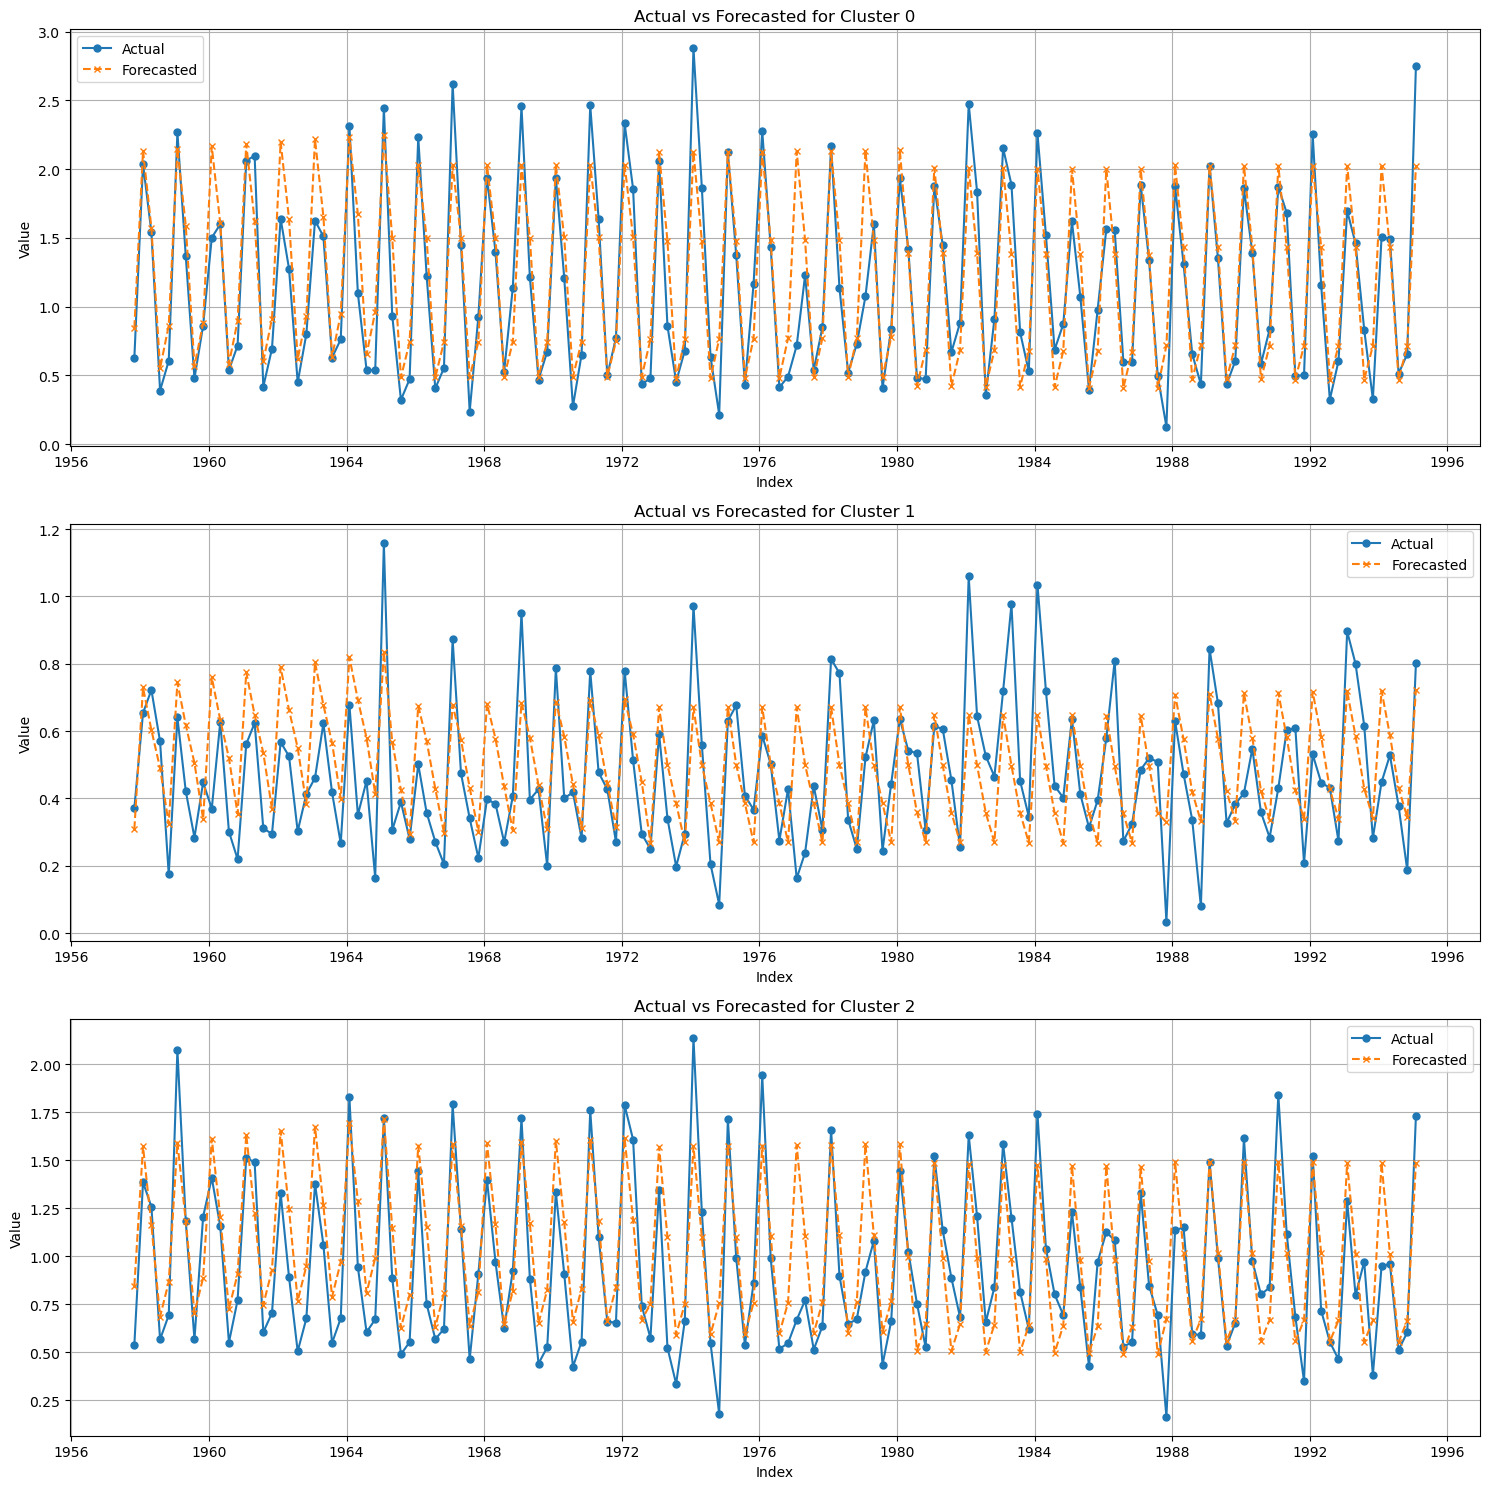

In [688]:
plot_cluster_data(cluster_actuals, cluster_forecasts, cluster_labels)

HOLT WINTER Hyperparameters Tuning

In [356]:
# Function to evaluate Holt-Winters model with given hyperparameters
def evaluate_holt_winters(train, test, trend, seasonal, seasonal_period):
    model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_period)
    model_fit = model.fit()
    forecast = model_fit.forecast(len(test))
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    r2 = r2_score(test, forecast)
    return rmse, mae, r2

In [354]:
trend_types = ['add', 'mul']
seasonal_types = ['add', 'mul']
seasonal_periods = [4, 12]  # Quarterly and monthly seasonality

# tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    best_rmse = float("inf")
    best_trend = None
    best_seasonal = None
    best_seasonal_period = None

    # Iterate over hyperparameters
    for trend in trend_types:
        for seasonal in seasonal_types:
            for period in seasonal_periods:
                avg_rmse_values = []
                for train_index, test_index in tscv.split(cluster_data):
                    train, test = cluster_data.iloc[train_index][target], cluster_data.iloc[test_index][target]
                    rmse, _, _ = evaluate_holt_winters(train, test, trend, seasonal, period)
                    avg_rmse_values.append(rmse)
                avg_rmse = np.mean(avg_rmse_values)
                if avg_rmse < best_rmse:
                    best_rmse = avg_rmse
                    best_trend = trend
                    best_seasonal = seasonal
                    best_seasonal_period = period

    print(f"Cluster {cluster_label}: Best RMSE = {best_rmse}, Trend = {best_trend}, Seasonal = {best_seasonal}, Seasonal Period = {best_seasonal_period}")

    update_results_csv(cluster_label, 'Holt-Winters', f'Best Trend = {best_trend}, Best Seasonal = {best_seasonal}', 'RMSE', best_rmse)

### ML Models Training and Tuning (Each cluster)

RANDOM FOREST

In [699]:
df_clusters_RF = processed_cluster_data 

df_clusters_RF = df_clusters_RF.reset_index(drop=True)

df_clusters_RF = derive_temporal_features(df_clusters_RF)

df_clusters_RF = label_encode_feature(df_clusters_RF, 'season')

df_clusters_RF = df_clusters_RF.drop(['year', 'month', 'day_of_week', 'day', 'time'], axis=1)

target = 'precipitation_diff' if 'precipitation_diff' in df_clusters_RF.columns else 'precipitation'

In [700]:
n_splits = 5

kf = KFold(n_splits=n_splits)

scorer = make_scorer(mean_squared_error, squared=False)

All Clusters

In [171]:
X = df_clusters_RF.drop(columns=[target])
y = df_clusters_RF[target]

# Create the Random Forest model
rf_model = RandomForestRegressor()

# Perform cross-validation
rmse_scores = cross_val_score(rf_model, X, y, cv=5, scoring=scorer)

print(f"Random Forest : RMSE = {rmse_scores}")

# Calculate the average RMSE
avg_rmse = np.mean(rmse_scores)

print(f"Random Forest : Average RMSE = {avg_rmse}")

Cluster 2: RMSE = [1.97088754 1.46127333 0.49423311 0.64751711 0.80052548]
Cluster 2: Average RMSE = 1.0748873134325354


Each Cluster

In [172]:
for cluster_label, cluster_data in df_clusters_RF.groupby('location_cluster'):
    X = cluster_data.drop(columns=[target])
    y = cluster_data[target]

    # Create the Random Forest model
    rf_model = RandomForestRegressor()

    # Perform cross-validation
    rmse_scores = cross_val_score(rf_model, X, y, cv=5, scoring=scorer)

    print(f"Cluster {cluster_label}: RMSE = {rmse_scores}")

    # Calculate the average RMSE
    avg_rmse = np.mean(rmse_scores)

    print(f"Cluster {cluster_label}: Average RMSE = {avg_rmse}")

Cluster 0: RMSE = [1.83995741 1.61657553 2.0337913  1.8735897  1.46255026]
Cluster 0: Average RMSE = 1.7652928389285052
Cluster 1: RMSE = [0.41020975 0.45584726 0.50190176 0.4955377  0.41885187]
Cluster 1: Average RMSE = 0.45646966785468257
Cluster 2: RMSE = [0.78084897 0.62268159 0.86855809 0.77064361 0.59919956]
Cluster 2: Average RMSE = 0.7283863653252278


### Grid Search Random Forest

In [703]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [280, 300, 320],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
}

Each Clusters

In [887]:
for cluster_label, cluster_data in df_clusters_RF.groupby('location_cluster'):
    X = cluster_data.drop(columns=[target])
    y = cluster_data[target]

    # Create the Random Forest model
    rf_model = RandomForestRegressor()

    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scorer)

    # Perform the grid search
    grid_search.fit(X, y)

    # Print the best parameters found
    best_params = grid_search.best_params_
    print(f"Cluster {cluster_label}: Best Parameters - {best_params}")

    # Get the best model
    best_rf_model = grid_search.best_estimator_

    # Perform cross-validation with the best model
    rmse_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring=scorer)

    # Print the average RMSE
    avg_rmse = np.mean(rmse_scores)
    print(f"Cluster {cluster_label}: Average RMSE - {avg_rmse}")

    # Update the results CSV
    update_ml_results_csv(cluster_label, 'Random Forest', best_params, 'RMSE', avg_rmse)

Cluster 0: Best Parameters - {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Cluster 0: Average RMSE - 1.7775929479349457
Cluster 1: Best Parameters - {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 350}
Cluster 1: Average RMSE - 0.4556212278659128
Cluster 2: Best Parameters - {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Cluster 2: Average RMSE - 0.7284037284434596


All Cluster

In [704]:
X = df_clusters_RF.drop(columns=[target])
y = df_clusters_RF[target]

# Create the Random Forest model
rf_model = RandomForestRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scorer)

# Perform the grid search
grid_search.fit(X, y)

# Print the best parameters found
best_params = grid_search.best_params_
print(f"Cluster {cluster_label}: Best Parameters - {best_params}")

# Get the best model
best_rf_model = grid_search.best_estimator_

# Perform cross-validation with the best model
rmse_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring=scorer)

# Print the average RMSE
avg_rmse = np.mean(rmse_scores)
print(f"Cluster {cluster_label}: Average RMSE - {avg_rmse}")

# Update the results CSV
update_ml_results_csv('ALL', 'Random Forest', best_params, 'RMSE', avg_rmse)

Cluster 2: Best Parameters - {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 280}
Cluster 2: Average RMSE - 0.24835670516664274


### Grid Search XGBoost

In [713]:
param_grid = {
    'n_estimators': [60, 70, 80],
    'max_depth': [6,7,8],
    'learning_rate': [0.2, 0.3, 0.4, 0.5]
}

In [715]:
# param_grid = {
#     'n_estimators': [60, 70, 80, 90, 100],
#     'max_depth': [6, 7, 8, 9, 10],
#     'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
#     'subsample': [0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
#     'gamma': [0, 0.1, 0.2, 0.3],
#     'reg_alpha': [0, 0.1, 0.2, 0.3],
#     'reg_lambda': [0.9, 1.0, 1.1, 1.2],
#     'min_child_weight': [1, 2, 3, 4]
# }

All Cluster

In [693]:
X = df_clusters_RF.drop(columns=[target])
y = df_clusters_RF[target]

xgb_model = XGBRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scorer)

# Perform the grid search
grid_search.fit(X, y)

# Print the best parameters found
best_params = grid_search.best_params_
print(f"XGBoost : Best Parameters - {best_params}")

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Perform cross-validation with the best model
rmse_scores = cross_val_score(best_xgb_model, X, y, cv=5, scoring=scorer)

# Print the average RMSE
avg_rmse = np.mean(rmse_scores)
print(f"XGBoost : Average RMSE - {avg_rmse}")

# Update the results CSV
update_ml_results_csv('ALL', 'XGBoost', best_params, 'RMSE', avg_rmse)

XGBoost : Best Parameters - {'learning_rate': 0.31, 'max_depth': 8, 'n_estimators': 80}
XGBoost : Average RMSE - 0.41915466596803935


In [ ]:
for cluster_label, cluster_data in df_clusters_RF.groupby('location_cluster'):
    X = cluster_data.drop(columns=[target])
    y = cluster_data[target]

    xgb_model = XGBRegressor()

    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scorer)

    # Perform the grid search
    grid_search.fit(X, y)

    # Print the best parameters found
    best_params = grid_search.best_params_
    print(f"Cluster {cluster_label}: Best Parameters - {best_params}")

    # Get the best model
    best_xgb_model = grid_search.best_estimator_

    # Perform cross-validation with the best model
    rmse_scores = cross_val_score(best_xgb_model, X, y, cv=5, scoring=scorer)

    # Print the average RMSE
    avg_rmse = np.mean(rmse_scores)
    print(f"Cluster {cluster_label}: Average RMSE - {avg_rmse}")

    # Update the results CSV
    update_ml_results_csv(cluster_label, 'XgBoost', best_params, 'RMSE', avg_rmse)